# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [77]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [9]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"

my_path = os.path.abspath(__file)

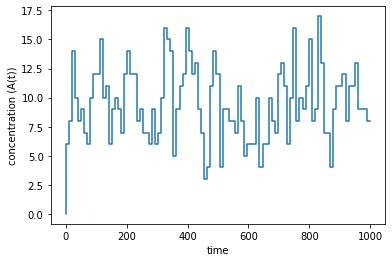

In [20]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 100)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.3], [0.5, 1.7])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

# Calculating the posterior

In [3]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

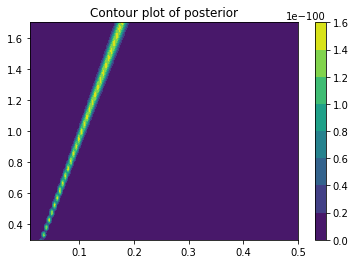

In [4]:
xlist = np.linspace(0.01, 0.5, 100)
ylist = np.linspace(0.3, 1.7, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute integral

In [5]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.5]

def bounds_y():
    return [0.3, 1.7]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    if 0 <= x and x <= 0.5 and 0.3 <= y and y <= 1.7:
        return p_stationary([x, y], values[10:]) / res[0]
    else:
        return 0

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(1.8211254397553877e-102, 5.1387860661369676e-102)
new integral should be 1=(1.0203293773974849, 1.4105436687747898e-08)


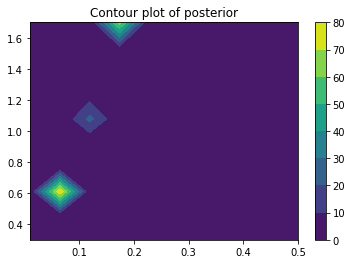

In [6]:
xlist = np.linspace(0.01, 0.5, 10)
ylist = np.linspace(0.3, 1.7, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

1 = 1.020329377397486


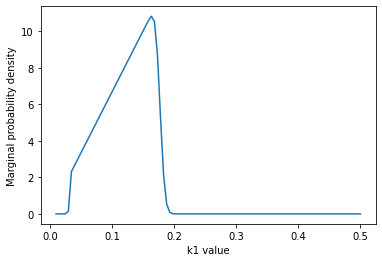

In [10]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.3, 1.7)[0]

thetas = np.linspace(0.01, 0.5, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))


res_int_x = integrate.quad(marginal_distribution_x, 0, 0.5)[0]
print("1 = "+str(res_int_x))

plt.plot(thetas, results)
plt.xlabel("k1 value")
plt.ylabel("Marginal probability density")
plt.savefig(my_path + '/marginal_posterior_k1.pdf')


1 = 1.0203293773974849


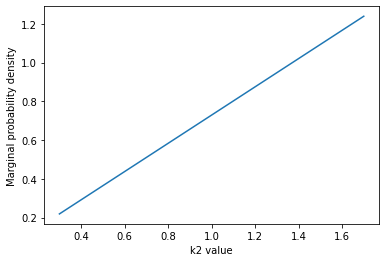

In [11]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.5)[0]

thetas = np.linspace(0.3, 1.7, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.xlabel("k2 value")
plt.ylabel("Marginal probability density")
plt.savefig(my_path + '/marginal_posterior_k2.pdf')

res_int_y = integrate.quad(marginal_distribution_y, 0.3, 1.7)[0]
print("1 = "+str(res_int_y))

# Rejection ABC

In [9]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(4.4)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     4      0.25             0:00.2
2     5      0.4              0:00.2
3     9      0.333333333      0:00.3
20    376    0.0531914894     0:15.4
40    745    0.0536912752     0:27.8
60    1145   0.0524017467     0:40.8
80    1436   0.0557103064     0:50.9
100   1739   0.0575043128     1:00.8
120   2200   0.0545454545     1:16.3
140   2654   0.0527505652     1:32.2
160   3150   0.0507936508     1:48.5
180   3590   0.0501392758     2:03.2
200   3911   0.0511378164     2:14.3
220   4380   0.0502283105     2:32.2
240   4777   0.0502407369     2:45.4
260   5090   0.0510805501     2:56.0
280   5353   0.0523071175     3:05.6
300   5726   0.0523925952     3:21.0
320   6176   0.0518134715     3:36.8
340   6644   0.0511739916     3:52.6
360   7174   0.0501812099     4:10.5
380   7510   0.0505992011     4:22.7
400   8079   0.0495110781     4:42.6
420   8403   0.0499821492     4:53.6
440   8695   0.0

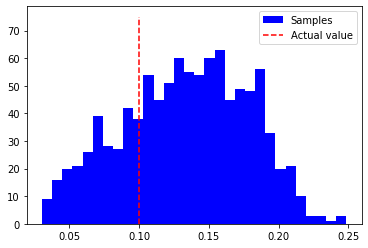

In [10]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], 30, color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=75, label="Actual value", color="red")
plt.legend()
plt.show()

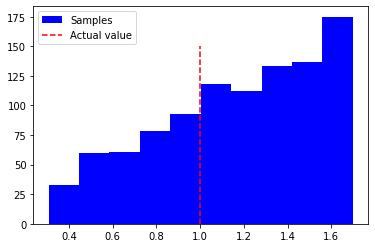

In [11]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
plt.legend()
plt.show()

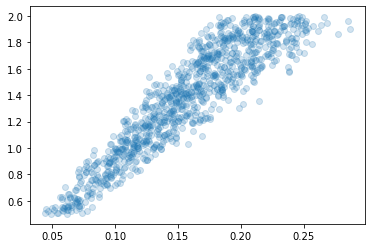

In [109]:
plt.scatter(samples_flat[:, 0], samples_flat[:, 1], alpha=0.2)
plt.show()

In [12]:
rej_samples = samples_flat

In [84]:
print(rej_samples.tolist())

[[0.15317284224672856, 1.3423125487782335], [0.06657758078303877, 0.6501009112942302], [0.07272037208652582, 0.6259694416419076], [0.07706675216111158, 0.6491880836944763], [0.14029354572876362, 1.4272477382354938], [0.05890745487366961, 0.5179503801710224], [0.16035348217727574, 1.3198768545377373], [0.149675487809033, 1.2641827915068382], [0.0823165464607869, 0.9182122631485361], [0.1802352143778128, 1.4645286131377917], [0.10152641895777043, 1.1165274982545699], [0.16320270535457332, 1.1987497645894103], [0.09091158096224539, 0.6481593217923465], [0.12134662956122905, 1.0831206435344245], [0.13735366551831346, 1.0703352965414579], [0.18957250644670443, 1.5286540139775726], [0.11876509618647962, 1.2656262890357437], [0.14434079653911236, 1.1628702284269359], [0.1434156774753626, 1.1176746997004907], [0.04716458764098136, 0.46905161814961766], [0.04766142597147727, 0.3939662015069478], [0.15104272405708924, 1.3959689143330047], [0.16693094608329617, 1.4540853767793969], [0.06719838446

In [71]:
samples_rej_abc = [[0.15317284224672856, 1.3423125487782335], [0.06657758078303877, 0.6501009112942302], [0.07272037208652582, 0.6259694416419076], [0.07706675216111158, 0.6491880836944763], [0.14029354572876362, 1.4272477382354938], [0.05890745487366961, 0.5179503801710224], [0.16035348217727574, 1.3198768545377373], [0.149675487809033, 1.2641827915068382], [0.0823165464607869, 0.9182122631485361], [0.1802352143778128, 1.4645286131377917], [0.10152641895777043, 1.1165274982545699], [0.16320270535457332, 1.1987497645894103], [0.09091158096224539, 0.6481593217923465], [0.12134662956122905, 1.0831206435344245], [0.13735366551831346, 1.0703352965414579], [0.18957250644670443, 1.5286540139775726], [0.11876509618647962, 1.2656262890357437], [0.14434079653911236, 1.1628702284269359], [0.1434156774753626, 1.1176746997004907], [0.04716458764098136, 0.46905161814961766], [0.04766142597147727, 0.3939662015069478], [0.15104272405708924, 1.3959689143330047], [0.16693094608329617, 1.4540853767793969], [0.06719838446453608, 0.5226202298628317], [0.14510976716667479, 1.196139367221519], [0.11891431346150427, 0.9925608402700015], [0.11160622267633519, 1.1260408145652403], [0.18221881181449556, 1.6111647708434949], [0.17451455490847467, 1.5110149724486417], [0.08842709155627643, 0.6911474020558794], [0.16673834046085617, 1.646173323084325], [0.10971987943215067, 1.0612761887124622], [0.1780717123231415, 1.6464715371290233], [0.17594433372449503, 1.4993260524768677], [0.20987751042091551, 1.581393845160118], [0.08881593653888853, 0.7754549861846756], [0.11987502140850365, 0.7958116872279242], [0.11397008511816359, 1.074952557657086], [0.06984910766806574, 0.5347352699709517], [0.18319048876669358, 1.6476547232640957], [0.10989011793683418, 0.9899172879631413], [0.11731538779162348, 0.9487268143735306], [0.14770943400119113, 1.2752335467072156], [0.03058732481636406, 0.34243778323199575], [0.14273890616218365, 1.3018553735777583], [0.14433780137652347, 1.12280369338079], [0.15414432836481284, 1.516330356252109], [0.12653078087663383, 1.161515554247237], [0.16021752852048066, 1.2139874550348562], [0.16970999295639438, 1.6264059993556002], [0.157528926302838, 1.2231253942225992], [0.13655454188761967, 1.2537134398719463], [0.1451666856311321, 1.4651029541193794], [0.03855776471038064, 0.3138761535377923], [0.13084350610314266, 1.425827277615583], [0.22163673651136634, 1.6909755653629417], [0.1361169588823395, 1.065939371411594], [0.0689188113128007, 0.8374749651858562], [0.10350955389086647, 1.0662988503513333], [0.17056549463471155, 1.3151074874884012], [0.21283041153536714, 1.666933744838861], [0.11557607764362154, 0.8350149233428834], [0.18802079958043033, 1.3770960932519267], [0.05931205938608858, 0.49834841972617233], [0.1584070682855961, 1.2352280731117709], [0.08061470090231354, 0.748889000399243], [0.12440386433556966, 0.886669116554627], [0.1420723507663354, 1.3696909315117847], [0.12077158939397947, 0.9026853873273792], [0.18461071099600246, 1.6956575391745854], [0.1209640558513096, 0.8885531891395815], [0.13020032347054944, 1.1623906731831306], [0.17471504480031758, 1.4150542025344939], [0.15686192254561881, 1.3244699770321895], [0.07805923292739758, 0.8551378940721646], [0.10613075602610772, 1.0390658727500692], [0.1834186662047998, 1.6854114860187832], [0.1664822475356037, 1.3039244980568716], [0.051246203584700944, 0.4980993814017925], [0.09906700553621683, 0.8270861776901302], [0.17861447154036947, 1.5875061282767928], [0.18459160175040462, 1.6675534043170752], [0.09735355811836, 0.6381430364417471], [0.1787893849735021, 1.508903293434493], [0.05989356149572178, 0.5705169196141902], [0.04713102584196549, 0.41126928587756584], [0.1539721627697665, 1.2438364790013259], [0.1839279299372759, 1.441495238148162], [0.14279117980272504, 1.2998450826336623], [0.09294423073451175, 0.8242523368972567], [0.07836188842664199, 0.67581504191379], [0.09156157948875143, 0.9795249552289798], [0.09598060264324632, 0.9329373999758679], [0.07887925517703609, 0.6953719294004959], [0.10561045855348827, 0.9534829714812263], [0.07903432940041333, 0.7842771856682832], [0.11445068190568342, 1.0680876548042701], [0.15795839511920845, 1.1853039297456096], [0.1900808522618591, 1.4800640843230495], [0.09816890795823535, 0.9921871114887382], [0.10624355075886971, 0.9201612625617008], [0.15260158057215256, 1.3634101343357963], [0.17513428964175176, 1.4257569231778067], [0.1353761096224474, 1.3472384314348127], [0.0939143894034396, 0.7670145443501939], [0.09939892446881177, 0.7916260640992061], [0.15680807100859606, 1.5270535881128195], [0.12880732372560866, 1.1476091250730078], [0.18540815516678677, 1.672541726884764], [0.06305805994636293, 0.6551438800188195], [0.05671109126848756, 0.5209380899120584], [0.18719578785254526, 1.363601874852414], [0.10455565709547393, 1.0647104532370857], [0.1421678927917811, 1.4815916653212242], [0.031770215345687136, 0.31492410808581944], [0.19789117131147171, 1.5930745918518006], [0.09513106467745053, 0.8100328741297591], [0.1147464945757587, 1.09672081366491], [0.18996011474644509, 1.5386382346718563], [0.07357957459580045, 0.837633814873608], [0.11681362311972676, 1.1357172701566403], [0.1345943825807765, 1.3491681924254044], [0.1515065409832556, 1.2743516049070163], [0.13510068030557698, 1.1862213751049118], [0.18152172762245328, 1.6130065885626377], [0.039668219342894995, 0.3745664855477249], [0.08702412973850826, 0.7388200939062098], [0.09439742987341299, 0.9352616038395485], [0.14006968095682054, 1.0525982873651236], [0.15516640023144013, 1.3204994102663725], [0.1684783240039771, 1.5721603976675096], [0.09105763815482809, 0.7727696101476785], [0.15410599163865762, 1.1919302488406973], [0.04236734334837511, 0.5121987620297255], [0.18666344281645353, 1.5999471986724025], [0.1971908843451995, 1.4465854993299931], [0.1138440641190182, 1.1561974692774981], [0.2115424210517201, 1.6642650804402603], [0.0871523049904141, 0.9329609594799442], [0.2006131271653575, 1.6061980291659077], [0.08735731845822686, 0.7283699141172952], [0.15439784273910817, 1.5855463653300834], [0.046028969891515226, 0.47069730912819874], [0.14893021336089807, 1.2904069638731295], [0.11488028146872725, 0.92390619830677], [0.1398758112045433, 1.4819354850441444], [0.1090313452437795, 0.8691372240070618], [0.10815442314420248, 0.9802586763202357], [0.1897343165481623, 1.4831326209423648], [0.11520602744086084, 0.8885229431605837], [0.1291252435260717, 1.106291429953608], [0.10326221470796942, 1.1440845153571106], [0.1309746658417425, 1.2302409089933857], [0.12862052703282284, 1.4034214257627953], [0.06555278528178049, 0.5595559441650619], [0.044623898768282544, 0.36826745765200986], [0.129721798929274, 1.0678731282588576], [0.11628140905884926, 1.103894789656713], [0.17486662105253015, 1.370019819001348], [0.12950400389215028, 1.1976981220934892], [0.191092905778862, 1.6264306523332162], [0.08036462593640958, 0.7495921981742371], [0.20243140633174045, 1.6234394526435927], [0.08031994766987638, 0.7091569420905319], [0.14070020095610636, 1.4785244568209712], [0.09575980765798153, 0.7445524445417955], [0.15623967430827568, 1.4138955065182444], [0.19601932017950108, 1.397895892535486], [0.17153577302489453, 1.556272099983011], [0.07263974006068852, 0.5000516121337579], [0.19594742696027784, 1.3744388154836527], [0.17675968848928003, 1.524628658398592], [0.13165382747048116, 0.8822054634948175], [0.06025096642496003, 0.4452490748228858], [0.16599374522188393, 1.5694340314925501], [0.17271734865917765, 1.4863590895718475], [0.08859871817633264, 0.6765889826292091], [0.13257269708063246, 1.3404682357316409], [0.21270133483897635, 1.6147100928297273], [0.08511061732875497, 0.7691785286073374], [0.13197647820413383, 1.4806994804284133], [0.18303479402699974, 1.377936515308672], [0.10788357694153838, 1.2212666145091293], [0.1405782071474838, 1.2040086662440228], [0.12686617679089035, 1.1926004921155027], [0.2039215447169495, 1.6276317690379138], [0.17138181521767204, 1.6088985730713918], [0.05981605872275381, 0.6717470744267462], [0.20680008523432775, 1.6858445357838334], [0.05084974647329138, 0.5451228489261882], [0.18581079166490838, 1.6199533330274278], [0.13761713803386372, 0.9116440887131487], [0.10765659424168861, 0.8609830325123387], [0.16345256320967588, 1.3044893290287887], [0.13879203732781803, 1.500023581699676], [0.08709390518349291, 0.8914395089313016], [0.04334249059189621, 0.34568598071755957], [0.21010433781988969, 1.6994017283828904], [0.18731817050840682, 1.4412480572577595], [0.19893868973984463, 1.5183085451265248], [0.131618997852346, 1.273398489373426], [0.047534148612939864, 0.435231574203872], [0.046257130047450856, 0.38552004222797087], [0.13154645283857436, 1.1629450958618728], [0.08926549166792574, 0.7904440449107567], [0.22606752429496596, 1.6608787474359998], [0.1408794680476771, 1.36806579054124], [0.13137014153513094, 1.2192329406252485], [0.15673371879473286, 1.3796985479506767], [0.12584723428247063, 1.059376644935982], [0.2289547119072372, 1.6872117863871932], [0.1539513921782506, 1.403266953120854], [0.04948874159172506, 0.4270873942777871], [0.06844234368304397, 0.7242174778201731], [0.06519849596946109, 0.6341973498483866], [0.18727787168147103, 1.5360845825687515], [0.12135417785462554, 1.1943845549927432], [0.12799493323297756, 1.350680080432079], [0.156694578491546, 1.4028519871998106], [0.0736671660237343, 0.5357466091899031], [0.14620201203548833, 1.4602809610783782], [0.13600342008026117, 1.4642306215144512], [0.07138536007653601, 0.7155749038086889], [0.1124737194178968, 0.8582194389725188], [0.09051185998584743, 1.0232615353196362], [0.08556410107846935, 0.7375696270262052], [0.16455308289458564, 1.3926749883444745], [0.1976014859898419, 1.6036023816402822], [0.04261237989573835, 0.37389363369751877], [0.20678983396561923, 1.6776816642855603], [0.06422484254677902, 0.5316078877697801], [0.1285712500187819, 1.0998719330712727], [0.17788762159702404, 1.3126572485194876], [0.089935349483722, 0.8065280744923449], [0.09260072058713853, 0.840074926017379], [0.09243410552003228, 0.8253667947965884], [0.06231900949158187, 0.514561248534765], [0.19716199265338874, 1.4630299513062703], [0.10209509998728755, 0.8659364179886089], [0.04937815877089319, 0.45538721260419257], [0.0967329456920843, 1.096764547070065], [0.18464462022260592, 1.6640215713337316], [0.1443706046404002, 1.1892259677621753], [0.10009593244562431, 0.7970506385333642], [0.07530256329377416, 0.575703023700171], [0.13936890348766517, 1.0772723555812018], [0.11600307037291235, 1.0149339350878004], [0.03176665470054757, 0.3160121568448413], [0.06998652285437512, 0.5144760666617247], [0.1000547947653399, 0.7418452920020056], [0.15855926226452316, 1.5932618975164907], [0.2409174274471152, 1.6874300527818051], [0.2277194797714771, 1.6885602091227587], [0.14083566565085492, 1.2570868258902532], [0.14062506405836345, 1.4969369453614598], [0.20939428026551388, 1.6629841314571343], [0.1178919972479025, 1.2084362805102005], [0.11400932686133114, 0.9432969480616356], [0.1385080796884165, 1.414676258353473], [0.14929294764603512, 1.1132736578645974], [0.09423653718248137, 0.6888222649941411], [0.11232184225210567, 0.8616966304476608], [0.05201656042198688, 0.5065167868700158], [0.1477466651474697, 1.2902995484703346], [0.20131677171142925, 1.404729490514324], [0.16230240351149516, 1.3751384000528253], [0.17864235933289296, 1.5404529670193086], [0.057591616762311226, 0.5379707157100512], [0.13790174056384086, 1.3311138602927433], [0.1212746577212302, 0.9970153980883898], [0.053330257704485906, 0.4871639123169841], [0.1991692579535878, 1.4577915445574046], [0.10592804413330253, 1.0594612457399901], [0.0765201140905079, 0.749300453512084], [0.16366602439891242, 1.6063534017179186], [0.12930254778697425, 1.1972324292083767], [0.16791831515958622, 1.4199590192239584], [0.13458523635520314, 1.5749152959756534], [0.15134469846030907, 1.1733581126077928], [0.10690080027982868, 1.123046126908464], [0.18328022055558396, 1.429825061887351], [0.15662148207870097, 1.468433958069944], [0.12454186333390149, 0.9479764263905759], [0.182051893266982, 1.5094764130165559], [0.07136341216472869, 0.6687829676534348], [0.1748397938808326, 1.566016140917144], [0.1379239601501806, 1.1958493104597863], [0.06181702288108898, 0.6672809006117237], [0.17368587276833503, 1.5580815395677845], [0.1503354751916544, 1.3213669557068262], [0.033637832147610014, 0.4076331003422534], [0.17111956675105172, 1.5976555421460268], [0.16392568065368135, 1.5498031178582985], [0.18662569194998713, 1.5535483189170785], [0.10406979067365518, 0.7137023652732435], [0.1534764829794391, 1.40476546074796], [0.1659877339580927, 1.216857098238141], [0.1037749255025317, 0.9355475438100032], [0.10991889375732228, 0.9401381581680683], [0.14100095624237668, 1.2843248389689927], [0.14336849560075038, 1.0556755279724617], [0.08800728287102316, 0.7041002509029458], [0.17043916972546996, 1.6340329941528835], [0.1448185275495884, 1.4150960601526514], [0.17676601995109675, 1.4488655144482423], [0.05743454503109713, 0.6156155362845437], [0.1871677146906458, 1.5009613546316098], [0.19878899644832848, 1.698576729534571], [0.08739581049376033, 0.8029238071683193], [0.11735768904424809, 0.8430506504461566], [0.20170272918323462, 1.6045107330426], [0.2172836879385352, 1.6468923067197672], [0.10089070546467743, 0.8721141298285917], [0.06029733824348421, 0.6883419140876241], [0.12096763012445833, 1.0408904045148322], [0.15709064096762454, 1.3796561879157774], [0.06791821267254372, 0.7260263688553148], [0.19752253188050606, 1.63029162034107], [0.08005744322242819, 0.7137745992867022], [0.1364701498651481, 1.3581460307520252], [0.18568572848218995, 1.4754736970485611], [0.14043913374252925, 1.3955107025603741], [0.21098731413700744, 1.678601361652586], [0.18185007935687264, 1.215990187947688], [0.18707635995330985, 1.397426156744342], [0.17716908264394843, 1.6648551060453332], [0.15013682112147614, 1.6739099433876665], [0.10288593720708855, 0.9893551316786293], [0.04215833975486777, 0.3655826354804984], [0.14768384224223963, 1.1929460072768001], [0.06384754149343458, 0.6105375941517264], [0.1537053218633866, 1.422353071615381], [0.11855157040744146, 1.022635459067262], [0.09625526035726129, 0.9149875739477455], [0.13410917177955523, 1.0873914589369413], [0.15604397447684304, 1.6882514262715889], [0.07190978918339114, 0.6500627815432347], [0.06832828593295498, 0.6882739793288117], [0.11675381214408753, 1.058777996639432], [0.13634604653377524, 1.1343048267001823], [0.16016539416302406, 1.387439422960153], [0.21057826539575897, 1.6860011916631883], [0.1563086131642501, 1.6009234037313251], [0.04831269231205404, 0.4170658797192746], [0.1516116293980599, 1.3478829696215178], [0.060705092898492796, 0.6166636627304062], [0.12716416712624257, 1.153786063228738], [0.1535309803197223, 1.2452544401684866], [0.1448688259192749, 1.4959828577767642], [0.1681874520801015, 1.4292263493035142], [0.1627717878792047, 1.3785498577738735], [0.10242303045299989, 1.1197217916970386], [0.1178849645019236, 1.2138490557724], [0.12187572052224349, 1.1613747236914636], [0.10658864716779332, 1.0275958365353517], [0.1920615154829569, 1.6335922581527835], [0.13649329707158186, 1.3029167639973425], [0.08924294365599167, 0.7893820102061989], [0.13779063922036883, 1.0023172266628242], [0.07169173434324494, 0.5603532980637035], [0.08510901180233443, 0.705533373004189], [0.14550116880390918, 1.204308387250361], [0.11329108297091145, 1.1771268841975948], [0.16464879940613458, 1.5499829489531138], [0.10421342821080476, 0.8952744395844268], [0.13707611707394607, 0.9888679087746552], [0.12637392882677012, 1.0757158782473757], [0.1018427054716109, 0.8597087405373545], [0.17821355870284322, 1.573283749173251], [0.18157089671158172, 1.5407778406901331], [0.07836483869539246, 0.649163848431157], [0.06697047842432119, 0.6061264556797541], [0.11581267201563539, 0.9012333014030827], [0.1565309747635718, 1.0926656472374034], [0.20214329784940271, 1.6232847943388988], [0.1276653311112323, 1.0853954272854833], [0.12193868348667425, 1.349939090005967], [0.180867457767802, 1.4824709547357298], [0.17307583199774385, 1.590908756538934], [0.17124739444004172, 1.2068801915666865], [0.1762430735306877, 1.6523624094388265], [0.055697422338154, 0.609498261986201], [0.1882521220170848, 1.5371553657871393], [0.17735680291736106, 1.5988019138450744], [0.08050534343614352, 0.9126142549087457], [0.16721766849279918, 1.5517851664660378], [0.18764096403264324, 1.57260772007349], [0.17369593051403148, 1.4652384435791133], [0.14817538571876238, 1.1585468015818734], [0.21380321690433013, 1.5598231285781072], [0.10402647166509704, 0.971507601742494], [0.1114307338304022, 0.9541529146381116], [0.1544099494146493, 1.1359824142749901], [0.12810083129132427, 1.1528940016550326], [0.09114900644691043, 0.8509901224891083], [0.1275491799172716, 1.1045640473092262], [0.05202509481622203, 0.5656107059401483], [0.17824165264550357, 1.5529245452269582], [0.17462114896440833, 1.4232833892746604], [0.19175822736635167, 1.5102038369000552], [0.11815652650687286, 1.29818378514208], [0.14677307589621363, 1.5037953419885832], [0.07082584650593449, 0.6502743397357036], [0.1343836352647475, 1.3230080964249173], [0.07083679470993415, 0.5590718425812422], [0.14834098648037392, 1.4123767522368738], [0.1981055776903221, 1.635512802372312], [0.150651605411944, 1.1955746887085208], [0.12732593752430343, 1.2040576211123346], [0.12565321259008894, 1.320094688345972], [0.18721473190544963, 1.4924931838156719], [0.1832545011204187, 1.671724371853973], [0.19081239080637147, 1.6678186676845692], [0.12982782118450564, 1.1885051866833776], [0.15831978793457702, 1.3040250527342383], [0.2073264197335405, 1.4538831457165045], [0.13051578847377754, 1.2757289281771755], [0.099756882851736, 1.0718584617699212], [0.15873327177013247, 1.2907300516368456], [0.15154958734208152, 1.4152876510445127], [0.07383871357724503, 0.7040009778846372], [0.12818839680112443, 1.0715292325732095], [0.1484290250709815, 1.3925547016712196], [0.12354773157114468, 1.3802516614635039], [0.17366930414542453, 1.6217785760057146], [0.11829709114118808, 1.002891912922922], [0.07967641573743173, 0.7331290422552281], [0.11228609742375767, 1.0776897352932358], [0.0962666716163138, 0.8421951848569018], [0.04978671997185674, 0.5352332257035879], [0.15262898853452977, 1.4026509276462003], [0.18790849637160306, 1.6027169429557182], [0.1690892804647337, 1.4401379908332934], [0.1498381167483634, 1.3846158747063493], [0.16891246491192224, 1.6967890152677716], [0.10202918886501877, 0.9816283320208703], [0.15581995292976264, 1.3887483420496451], [0.20892311523357598, 1.6393936046885031], [0.2486092510032351, 1.672106121046201], [0.12132503214875828, 1.0135987677026495], [0.10019853771031184, 1.0730743497312891], [0.16522342716799293, 1.5832152750244732], [0.09329485408222132, 0.8395606196927448], [0.15251188135647792, 1.19422683619042], [0.05288066786897677, 0.5069425973450357], [0.18060037618066405, 1.4552753849890352], [0.04476205598390076, 0.37938884337928147], [0.11846977428524719, 1.1366240308212525], [0.19560363437230782, 1.6862527882403495], [0.1874177954121215, 1.6489522536267045], [0.07241459711556214, 0.7773243800839733], [0.10628083915723469, 0.8578531837182615], [0.1903073052974955, 1.6211247894984904], [0.1161996541567264, 1.0822711643397795], [0.16399452108682544, 1.571714578364912], [0.1139504705046146, 1.1027921558043559], [0.14008937449893816, 1.3747665236206645], [0.15213053940636823, 1.3553894374809798], [0.10739898768622069, 0.9839719655616885], [0.17305050329257216, 1.6716785168381938], [0.15437370999003364, 1.219206723897166], [0.17578147953455447, 1.6460091418197424], [0.13828530973591235, 1.340231155533525], [0.057238078715795004, 0.5093245098594341], [0.1468079757412843, 1.5063721117088242], [0.04301542820661691, 0.4659644537444537], [0.07970393820590482, 0.7699001742581085], [0.10342966267120962, 0.8200746134465076], [0.11772831952395346, 0.9150195675455073], [0.13453787111853238, 1.5649396756114973], [0.04792314066427045, 0.44640651453917163], [0.15367031998414693, 1.342156831386581], [0.16355979779360513, 1.5964482873480852], [0.11800300663589358, 0.9787422167664159], [0.12735864478453424, 1.2753282373053165], [0.17702443011036045, 1.6022491839811825], [0.09239572501125715, 0.8126047644349046], [0.12007129043846054, 1.154068011581825], [0.1000876779964549, 1.0796264067789276], [0.09299240588911295, 0.8805949387665881], [0.138352843602705, 1.3198446502801349], [0.12656552781570413, 1.034178852121613], [0.08638999363553085, 0.9089856685897206], [0.11907036253956998, 1.007368302952273], [0.1523921460062963, 1.6377597241972441], [0.1336400512062808, 1.0661840849511526], [0.1297402258123067, 0.9748356817441168], [0.17444643146456373, 1.4993701429862047], [0.18179198797869672, 1.6151056758134497], [0.07158120722216099, 0.7323556690284987], [0.18751020782810285, 1.6893221410627821], [0.1917788381136633, 1.530479463435804], [0.10075169317832378, 0.9722469473926452], [0.16503270628282418, 1.418500638007274], [0.08119835034342499, 0.6516998992753616], [0.07911949943778607, 0.8331356708290727], [0.13077967124396073, 1.2893726118089746], [0.11034557419782809, 0.9540576998685268], [0.06114460480944034, 0.6149564498885864], [0.12753828119522898, 1.0697454265722486], [0.19789110889984513, 1.59476614395682], [0.11407514333379332, 1.0136416862504565], [0.10372852284869544, 0.8237343048998929], [0.09075040552597347, 0.9045903889811497], [0.1168675553987159, 1.060784948478165], [0.1687242545694143, 1.4844099318181685], [0.1421838053534647, 1.0296116675891325], [0.19223200744715263, 1.5923115955490799], [0.142937654250884, 1.2833899277324614], [0.11646149805173128, 0.9230445859886343], [0.14693884733824691, 1.4706137471111003], [0.1267211378116483, 1.0821766910121071], [0.16030455566821178, 1.5337713690471078], [0.18672879047450874, 1.5203442656577493], [0.1783430607547969, 1.6947198757922415], [0.12031314615181998, 1.2155694452908987], [0.16939492540708828, 1.571901175672812], [0.1913639435618395, 1.4550151633508401], [0.1336320254146215, 1.3305439383166502], [0.15602293579497756, 1.2318452989192814], [0.034471846211597545, 0.3585005946329378], [0.17792731217423657, 1.601653889569475], [0.13840173467845368, 1.4260390892425283], [0.09239938663627667, 0.7637340219568374], [0.09830791269177774, 1.004873982807562], [0.09604722879953298, 0.9438254728357984], [0.10795881616074393, 0.9346085750478714], [0.1864850216251956, 1.5282070222550128], [0.18737000495534578, 1.6079320421792536], [0.07986942994868601, 0.5833031323429041], [0.18632000102334356, 1.5725391956157482], [0.15589464408193104, 1.1510704435203931], [0.06611978242765304, 0.5283650222727692], [0.08980983236196549, 0.9645883861018523], [0.13461943844089802, 0.9621385168910563], [0.17870313676469918, 1.5408345862501953], [0.14037880661491536, 1.2175874717471238], [0.17481681804064592, 1.5441741513664204], [0.09982084575951916, 0.9164552030980346], [0.12286471742550265, 1.3476026228728843], [0.09419453919498338, 0.9739394261109666], [0.14219177864170562, 1.4914533738469713], [0.17077068845292886, 1.5104201206503607], [0.11818829362689481, 1.2052663397300494], [0.12909745305330567, 1.2047538087726], [0.16684049040651033, 1.4926246667461514], [0.05904988841608405, 0.5356226648119438], [0.19306434936223826, 1.6173878953804992], [0.08710409626644322, 0.7954645713009567], [0.11981725031113111, 1.2316826966066523], [0.17425514941113063, 1.6949581454057123], [0.055428257199105546, 0.5242032946606752], [0.16920509541655132, 1.427062951357025], [0.21381609938371615, 1.6635031254050723], [0.12475681509543546, 1.2701146880605318], [0.18295674139353285, 1.5595152338723313], [0.15715609941181446, 1.4696272698899937], [0.1002984299902761, 0.8257151762138437], [0.12063268515918246, 0.9515714824754022], [0.14457606725981115, 1.2383758276810597], [0.16205732811291623, 1.6657016694634892], [0.16237601422397852, 1.5944041084077611], [0.05945184859977665, 0.5445034108306399], [0.11013755090043187, 1.0797345088104218], [0.15820308610790873, 1.3038772477472498], [0.16435504900662257, 1.2766245676043984], [0.16811263363933493, 1.5042410694732593], [0.07968850818995105, 0.75333972490487], [0.17410915366899027, 1.6972788878375378], [0.08542685335205275, 0.8618010165559109], [0.04711386385543598, 0.49019965773995966], [0.1088281474265676, 0.9058257232866909], [0.030853668027773617, 0.30603253906391764], [0.1023842386372194, 0.9047263440020259], [0.1871446771826562, 1.6991556923452729], [0.13417451539733677, 1.3048099527984802], [0.16118405219490767, 1.315764834354403], [0.05460400320962111, 0.5636083158685973], [0.137665898704801, 1.3947716503854761], [0.1672619444332475, 1.6798551377830786], [0.1951640220398967, 1.4227111706064648], [0.16383925915457154, 1.3542543544854497], [0.15929117333930404, 1.123378458859911], [0.1653863994490109, 1.6604060553226898], [0.10583045415768955, 1.0839936564589137], [0.17811536116461985, 1.304029204458526], [0.19830354480688672, 1.6082389070803589], [0.18002221499328153, 1.6026394247806164], [0.11586328044804517, 1.3259613797672827], [0.08207919767815014, 0.6228140430341222], [0.19154141596002733, 1.5276705275306306], [0.0844586022532135, 0.8807271867209903], [0.09718574284257225, 0.7828889877564583], [0.13285600524641794, 1.187287988425571], [0.07930823198827641, 0.6862457728010714], [0.12891209408273246, 1.0696759739299524], [0.12065714487373341, 1.2734377149881462], [0.19143965222677933, 1.6569494323252305], [0.06568140504021014, 0.5030030080312364], [0.19251895943690928, 1.5991249275084976], [0.13965338945113126, 1.3341542431124942], [0.15220472300048987, 1.586250511675585], [0.13762904589775737, 1.2543345783836475], [0.21621056455162307, 1.6853836313564976], [0.10952092204909519, 1.0615794819748967], [0.18655002263601383, 1.6493017339272347], [0.11372777257689537, 0.9358784610180897], [0.1589187684535155, 1.3941578665921948], [0.10839526833887186, 0.9418861555610356], [0.1390531045493481, 1.2481437478444954], [0.14738593724764792, 1.2244366529667714], [0.17048350701815285, 1.362275056814631], [0.11396905443652172, 1.1456704920729313], [0.14622339073666796, 1.4692467409591168], [0.07214580631684786, 0.53565352560345], [0.15437031289974817, 1.3520940223351179], [0.183213525967369, 1.368178998647211], [0.15154912852348734, 1.2952670822889216], [0.17847669240981273, 1.6886003063935242], [0.10169172207255872, 1.0486910460108587], [0.1259204980007061, 1.361760944502638], [0.11526650316534082, 1.0970542946250288], [0.1838321280834101, 1.4830190166224526], [0.2083527467228004, 1.6007118124232227], [0.10350144886107487, 0.915728503524073], [0.1343217140779785, 1.1485244746800407], [0.1521128871052279, 1.2461958403372027], [0.1677602252838174, 1.6548523599293792], [0.12911831509116, 1.0117691098709165], [0.14893665474480267, 1.5229474852738176], [0.10930106119307087, 0.7325406582655523], [0.10900325460504107, 0.9869402232157958], [0.15378202433102656, 1.3384481978453573], [0.1276039894870848, 1.007629048222014], [0.13110005397105562, 1.104319363095829], [0.10849719865545171, 0.9428482789617088], [0.19387545956508262, 1.397315272462063], [0.0952140212608309, 0.9540665480762052], [0.15221480872169452, 1.5969469125777445], [0.19399356048948485, 1.5471539507800056], [0.11877136198235089, 1.005956148486541], [0.13928313515811686, 1.4390093765476921], [0.10665777842738733, 1.0031561447719237], [0.07027963947088711, 0.6787981535259885], [0.0831090939215835, 0.6703986197840934], [0.15411822911676554, 1.299103622594091], [0.19153648489862007, 1.4661428961231033], [0.0677168981106892, 0.6333597326185731], [0.11855553284141174, 1.1044571106053123], [0.13955775772995, 1.2061222389415849], [0.18914590162048617, 1.5694196114530505], [0.09281404031105017, 0.8546967222490884], [0.1794017616500555, 1.6274343652152963], [0.19215214025782723, 1.4270172691718064], [0.08727449343174776, 0.9524699504435037], [0.05556577148790648, 0.43458016419582257], [0.15919676112013592, 1.6234231116525966], [0.21136210757217544, 1.6963953598517112], [0.18728103436171067, 1.5885497739412362], [0.11986919829850817, 0.9161650118535991], [0.19425944026492759, 1.643079249070268], [0.12657889790564303, 0.8014247985439447], [0.04199195291227109, 0.40098856283900536], [0.18883105704270464, 1.5200218671504682], [0.12697785209847628, 1.1906302174080483], [0.13796055965609255, 1.13880070998207], [0.15368407949022245, 1.3303332917478206], [0.1387634711944717, 1.3246323536697011], [0.1693783391637374, 1.5533409079081542], [0.12988987730409546, 1.1344390364418342], [0.16886017386493446, 1.3327263958815696], [0.17522810166573088, 1.4411454867572102], [0.1286324629795002, 1.5076711220112264], [0.17218563741041704, 1.427704691596081], [0.12127801946374367, 1.0152041522538136], [0.16284123152357965, 1.3267853848329172], [0.03296923142028613, 0.3491833160566249], [0.075473840728913, 0.759487102741309], [0.15751466980137246, 1.5975661999957642], [0.18467467230162876, 1.6011108053027614], [0.17141277488049017, 1.4706474551520154], [0.18966830929115946, 1.5520829932579603], [0.15325148392122007, 1.2045521413220244], [0.05302656224804814, 0.48850379688657786], [0.06743653120791482, 0.6868262233353359], [0.18546754817468797, 1.5151457334611602], [0.08126827052200097, 0.6924338953066536], [0.05724882313961094, 0.512376081677921], [0.10372886670530856, 1.154024224580092], [0.11717912152488541, 0.8841218687637211], [0.20655717714858762, 1.681357130547492], [0.17358517622380598, 1.4308178207162192], [0.1575225619197671, 1.6053774075598852], [0.2114263385018516, 1.6498420699528413], [0.16555874801342424, 1.6886168594129676], [0.07840826327986095, 0.7706993220847953], [0.23126237735638133, 1.6662553389533503], [0.10541176174006883, 1.0387273172423317], [0.14435580269003673, 1.3787455035221663], [0.11386067309915299, 1.1897101583627414], [0.15467036924221694, 1.5758241999917044], [0.08400959233190841, 0.8803677514761861], [0.10273228614794777, 0.688411642013308], [0.1264805125529801, 1.0976108341963513], [0.10473634594031656, 0.9263391335490274], [0.13276741173141732, 1.3627601500041522], [0.0972981549723606, 0.9767001307513086], [0.17076592085357772, 1.534207005176724], [0.08239398312996227, 0.6196961239761305], [0.1582652033727619, 1.230802169560207], [0.0640666839206353, 0.6300484811390255], [0.12478058700296968, 1.395747873686097], [0.18215329761334004, 1.5989767311892267], [0.11361563158296706, 1.2463972349732804], [0.17562716303007048, 1.5237709291600217], [0.14497540149371985, 1.0181999134052369], [0.04417060069061379, 0.36821673607295213], [0.17477537350846484, 1.3918832391765186], [0.16190729101691037, 1.632473752042356], [0.17656073519009446, 1.466579963650533], [0.15605690971069686, 1.5074764759079804], [0.1128744759150846, 0.8741577359753603], [0.18974790972475786, 1.4880365145881547], [0.06444016469379049, 0.5701904394030287], [0.14312793551621883, 1.1757887599279502], [0.2122953880645681, 1.6571011305710792], [0.07507453383270168, 0.8421743873487089], [0.20753672879344082, 1.6301512883465887], [0.16291010487601, 1.4502991868284245], [0.043955421490176394, 0.3663195584020487], [0.16187369776586635, 1.4743581485049808], [0.180919538282373, 1.3174617314224175], [0.12303052318416946, 1.0646780981803083], [0.17834811547954965, 1.4941130636831395], [0.13786961927818614, 1.0669653230392604], [0.13313846519708022, 1.0946450230701739], [0.21612663804634336, 1.6777018188420856], [0.11041353764659556, 0.9468058987306083], [0.12439883955135006, 1.1485252109597737], [0.24185417223643463, 1.6864587676742464], [0.08007644797306263, 0.7359096834276291], [0.16097390780261606, 1.445304689971753], [0.050209148193977926, 0.4008534084978311], [0.16307510361746907, 1.3424499475394085], [0.20188581871876982, 1.6066839606328707], [0.10459144749921612, 0.9776360993464945], [0.1618681111706246, 1.463900372288476], [0.17483607420484804, 1.5733933055529081], [0.20308462476610284, 1.6887091411227904], [0.15531542990474673, 1.346739319580094], [0.17632745832139912, 1.625262706160196], [0.10329453318143395, 0.7635369454298941], [0.17321865349650983, 1.4195449206430633], [0.09491988799188078, 0.8410887528935174], [0.1977833251471796, 1.655095896172099], [0.11160037351082625, 0.9176489576151212], [0.10739084527918413, 1.1128005939192824], [0.17691884561434196, 1.5998160238783243], [0.20674421755130556, 1.6440858650183825], [0.0959014490131912, 0.9809800867053073], [0.19622634161030827, 1.6496818978654435], [0.19695924660791592, 1.4677393571579869], [0.2176167894211326, 1.6655651304672936], [0.07218870442740882, 0.8191454075691371], [0.10199508803280144, 0.7762243640968971], [0.1786379708700035, 1.2538858497462495], [0.15045626857065814, 1.4801204346652836], [0.20954741435043, 1.6381477161121563], [0.0967441514285649, 1.055139066179847], [0.13049186104696725, 1.0476887465232025], [0.07093414877916382, 0.6175488131321948], [0.14724678098730748, 1.517706057630751], [0.1721741120071253, 1.6020534907595188], [0.06628312354881966, 0.5479143993753046], [0.06458668059710343, 0.5899679262411842], [0.10289285035002282, 0.7957779504033835], [0.19614321492622805, 1.4207032172063052], [0.05574414578595793, 0.5369403043457007], [0.1251676381448053, 1.2619070181209018], [0.1325082153110289, 1.10946445202304], [0.10338063333116243, 1.1561824777740723], [0.13571000873835898, 1.5651698460397123], [0.0696964679867495, 0.5829074139668745], [0.205475676565136, 1.5031245301062053], [0.15570998311970974, 1.3713428757422836], [0.0884903139565909, 0.7791972053521891], [0.20454878031323448, 1.540518238167243], [0.14030062701465773, 1.3721018507597487], [0.12045989760667547, 0.9446164966462991], [0.1835996402639326, 1.6846454422793717], [0.09334023999308927, 1.0227823383332686], [0.15799148370298316, 1.5916311045411], [0.14729479349480123, 1.6917377158097304], [0.08641547981335507, 0.8458538692344437], [0.08983132742359212, 0.9081827360595409], [0.14423672313412483, 1.0114238521758165], [0.08619282603700673, 0.6828010161704957], [0.19038367352966795, 1.5477261619565623], [0.1403453725966035, 1.094862515909419], [0.1563922806596983, 1.45074596997503], [0.14292119318550817, 1.0670750373779159], [0.08928705901045042, 0.6812466762385864], [0.15024281825301788, 1.5855946188906422], [0.07339868342158012, 0.6964358445080207], [0.19707918066208657, 1.6161044085419565], [0.14265330093490697, 1.351467587344794], [0.15825989250744837, 1.5173560104900654], [0.0720008265436784, 0.6899435750341172], [0.18825894808444188, 1.655314391724726], [0.03609399133700364, 0.3716282351422757], [0.18665144441848364, 1.6194665717611192], [0.17043678575957988, 1.503335503579783], [0.07588464567156711, 0.7226049950726874], [0.14645218806711185, 1.3530746824752737], [0.057162092758906435, 0.6336297140270974], [0.15883057074690698, 1.2536409823344123], [0.12025409912853419, 1.1381504417356412], [0.06249171722365143, 0.5647196869850026], [0.17593287857887702, 1.3467964363229579], [0.16128276698611288, 1.4846060736213782], [0.13888859672884135, 1.3048141627943783], [0.06775311430385605, 0.5504505317101702], [0.14741872849414456, 1.067101145063202], [0.11793288770966259, 1.0277011861418386], [0.14815081803666696, 1.312764697506541], [0.16655821236995233, 1.3655953247725419], [0.15204519212368844, 1.524423537392112], [0.17876144088763057, 1.376507366103947], [0.12808690844546916, 1.3541140121541095], [0.1232448839543479, 1.1416895938180656], [0.11000197179476984, 1.1259969941721386], [0.18664113639098845, 1.618318691071647], [0.19657378452580893, 1.5664789926127902], [0.13379202847373323, 1.0126809370927499], [0.0919810589565409, 0.7447696921191853], [0.09196396845514665, 0.8922529747807635], [0.1128527642919056, 1.2495520786100305], [0.05361726065347544, 0.5312160103757708], [0.17648085059496044, 1.6384483258912628], [0.03234717146095234, 0.36633092129042377], [0.13701376773696744, 1.4148419861289294], [0.15833540180320071, 1.508729637834926], [0.07208724694105034, 0.6625518392294192], [0.09180491994813245, 0.8555056943045174], [0.10738810474063032, 0.9400910428704874], [0.10147275725294874, 0.8393153218959859], [0.08239424164482878, 0.7198481908065257], [0.1536005990265693, 1.4954404524357505], [0.07471342038888446, 0.7727253224820557], [0.13077611063904282, 1.2066618877388309], [0.0466462471931523, 0.4669422314864773], [0.17960063679999705, 1.6534527555069933], [0.1748492839668992, 1.2383184013722601], [0.20256659293625967, 1.693868359358169], [0.16185280365903665, 1.2361101517549196], [0.06274313775406881, 0.5035106437523491], [0.14301787726482584, 1.2313836932626585], [0.14522406829580864, 1.2187769404562794], [0.15860769222876586, 1.223316869531989], [0.09719976334236391, 0.8086860001884149], [0.08675878520855634, 0.7588227221552538], [0.1205058782601729, 1.0840479942254149], [0.18675065990875317, 1.5208169792910542], [0.09828702697019237, 0.772759750431627], [0.15586873555293457, 1.4605242559297533], [0.1976100851163743, 1.6111364258723628], [0.13107741820088403, 1.2537593835222776], [0.11389080041720068, 1.170590216901316], [0.15380250215762098, 1.2164672118343627], [0.16255736962854916, 1.5704262240351317], [0.12608831851340685, 1.0956821380689667], [0.15320100898882516, 1.1275828339495644], [0.1579117497535425, 1.1957724003808585], [0.14081340583559432, 1.2420094367025711], [0.16764375470304965, 1.2709452187972194], [0.12664220252387004, 1.0616584764691588], [0.11074311874245413, 1.0682327162267593], [0.1323495026297617, 1.1962138374380746], [0.1566259874354678, 1.4690350443126057], [0.15890124825997204, 1.0633395686933145], [0.13592926507681075, 1.134251106700655], [0.1100350759559024, 1.2658067958333006], [0.06823800877069064, 0.6152008689939947], [0.18925787608507855, 1.4325768005188486], [0.14371682413211434, 1.3390488737697008], [0.10142314781749762, 0.9948430855300265], [0.05213498475265904, 0.3921964945831694], [0.14519189283789596, 1.3676895245877267], [0.07972569096021759, 0.6801022952121403], [0.10465417848626923, 1.000272215554735], [0.12884119950456846, 1.3275641016446027], [0.157392548267901, 1.4665286546735203], [0.08972710488258429, 0.8263348950256824], [0.17737828748701134, 1.6022051407175404], [0.10479315572421954, 1.053785815468773], [0.15653395179678564, 1.5798443794684232], [0.15013233578530122, 1.5346760779440685], [0.06328324113290323, 0.5407208519959195], [0.19185928593542828, 1.4317302696107015], [0.12721784663647628, 0.9807809664040421], [0.11943094116892472, 1.0427068222675253], [0.1381922517413693, 1.518887240428387], [0.1451914578896819, 1.3516673930255498], [0.03832890406992745, 0.3541329706823052], [0.11688712640213339, 1.099012024502887], [0.16013962770671852, 1.2100446374644471], [0.16021365069371768, 1.3403734444240205], [0.10716185770680459, 1.0526720262193152], [0.16973275133532473, 1.5655055769868338], [0.14160977287885174, 1.4277377968574299], [0.14570459436963634, 1.2913981221997681], [0.1767084969082905, 1.2823421454406854], [0.2002085883178435, 1.4804397555543818], [0.1687399449282474, 1.6258366729856308], [0.13346817022938956, 1.1795247476821313], [0.13256348585942435, 0.9188738775737695], [0.04254691333289151, 0.34890379226579127], [0.10740634029766238, 0.8222603265314172], [0.1218436114338336, 0.9498238156917382], [0.11189672727810374, 1.129104488974275], [0.10871674518409541, 1.148553072228941], [0.1062863022771458, 1.1412017505066172], [0.16454769405638242, 1.5095369888182413], [0.07139434510129472, 0.552712966063881], [0.1519534426032252, 1.3375637115337993], [0.0502747751721746, 0.5393913941066745], [0.09439788296387569, 0.6243785751247344], [0.16207736479031637, 1.6726133018623695], [0.17674708130651734, 1.6913203091812006], [0.12485376075800064, 1.194672739017401], [0.04251868146236759, 0.36721650301525854], [0.15142136883958401, 1.2492170580474382], [0.18526246038707161, 1.626336649324609], [0.10105989436706164, 0.9289389361233005], [0.09120841595329893, 0.9138749979218943], [0.11140179481485935, 0.9287239039450013], [0.09614566269673025, 1.0564857492513622], [0.17802231020421083, 1.4722940784547267], [0.0667306572134646, 0.6389262508867104], [0.15322302191540615, 1.3007887095666544], [0.15120832374069143, 1.183795082490748], [0.13224975634738284, 1.2717944490197344], [0.18505094678486406, 1.6501146682415158], [0.20957717752488997, 1.6537830488160676], [0.12387008954145556, 1.2128046387009492], [0.1126048979883606, 1.0465779381390024], [0.219688670286171, 1.6381094746343818], [0.18907695484903192, 1.6389596111576128], [0.06752039147984817, 0.49687737195748516], [0.12408355014644235, 1.3787867232823114], [0.13498940581462332, 1.0169156221851354], [0.06809325128366106, 0.5772667816306194], [0.06456679834181606, 0.5296091826192546], [0.07307558057269103, 0.6198595998111502], [0.0704240463218534, 0.5620070399790991], [0.17297241333797125, 1.6348780298041827], [0.11511498887663779, 1.208417869724458], [0.21206077768708415, 1.5903818029629582], [0.1570353696279982, 1.106128253101351], [0.1588860569352213, 1.3820207904877895], [0.05942808916261538, 0.5431844356269957], [0.15911641632965245, 1.3556543300622388], [0.1671974428216626, 1.6107168710226123], [0.0951905460432596, 0.9213962700345322], [0.19358329322357587, 1.585105699474787], [0.12513738953939252, 1.0927279057642445], [0.1540116929206929, 1.5244387589981212], [0.11303097531693201, 0.9670943613911269], [0.1895934964059881, 1.5658965386299055], [0.19295349432394404, 1.4935037205224668], [0.1512716697080444, 1.4180780342270858], [0.059369412498648744, 0.5673829594552398], [0.1208675945677799, 1.3130963316399842], [0.08284101968255914, 0.6377473307842885], [0.13766303766740062, 1.2737118101261373], [0.1263157602755392, 1.1326013002480015], [0.15839667198732865, 1.4055295532478231], [0.04304944168817626, 0.4341807107674174], [0.24380601189091872, 1.6666760634653692], [0.13299114517439642, 0.9731987790534837], [0.10726985404899192, 1.0644279272385355], [0.09346488616110515, 0.9597783408974399], [0.2031890973725673, 1.6393067317897263], [0.06042667813597452, 0.5131663628628146], [0.09524853814133682, 1.1484894002980472], [0.13980206825910885, 1.2948048384372772], [0.1279227459304268, 1.345253456594718], [0.16236739571955144, 1.4885454582816617], [0.12064354636427999, 1.1019476289826888], [0.17854812282661003, 1.4044771088857693], [0.21607065679003018, 1.6011023219169904], [0.06763951771729465, 0.636026704638438], [0.12816252569496211, 1.1280611337545625], [0.14723499790521943, 1.5040396212571825], [0.18972312681315284, 1.3685074984615782], [0.1224242630948238, 0.8749663413792981], [0.0893028656451777, 0.8508822509650307], [0.15979260669559187, 1.622846121224786], [0.14038550816811896, 0.9571402567241489], [0.2116070062525125, 1.5675907146890429]]
print("done")

done


# True PMC

In [20]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([9, 6, 4.4]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=6.0
Trying t=2, threshold=4.4
Iter. Eval. Acceptance rate Time m:s
1     4524   0.000221043324   2:56.3
2     4525   0.00044198895    2:56.3
3     4532   0.0006619594     2:56.7
20    4630   0.00431965443    3:00.7
40    4728   0.00846023689    3:04.6
60    4888   0.0122749591     3:10.8
80    5030   0.0159045726     3:16.4
100   5141   0.0194514686     3:20.5
120   5254   0.0228397411     3:24.7
140   5386   0.025993316      3:29.7
160   5514   0.0290170475     3:34.8
180   5649   0.0318640467     3:39.9
200   5759   0.0347282514     3:43.9
220   5865   0.0375106564     3:48.1
240   5975   0.040167364      3:52.3
260   6072   0.0428194993     3:56.1
280   6218   0.0450305564     4:02.1
300   6311   0.0475360482     4:05.8
320   6462   0.0495202724     4:11.5
340   6585   0.0516324981     4:16.4
360   6734   0.0534600535     4:22.2
380   6842   0.055539316      4:26.4
400   6949   0.0575622392     4:30.4
420   7112   0.059

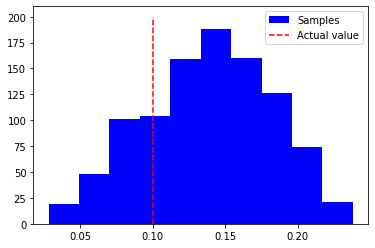

In [21]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

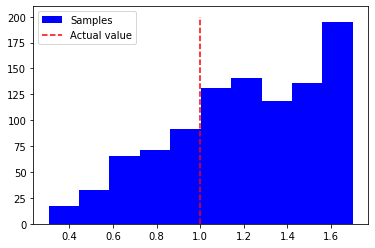

In [22]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [23]:
res_pmc_true = samples

In [85]:
print(res_pmc_true.tolist())

[[0.09838005540756882, 0.9837714900298781], [0.11569271912276904, 0.8273246167867934], [0.11374629504205257, 0.8757220776249764], [0.12034855308185878, 1.0568325132413758], [0.12582989601418146, 0.961892336193515], [0.1794733317016941, 1.632278271602093], [0.1206507880017916, 1.1013149701997715], [0.16488718706180694, 1.5883685043205422], [0.0653292788895871, 0.5825338280753456], [0.1997837346779396, 1.5727877264144527], [0.11265611880496397, 0.882992411150225], [0.22891195570308442, 1.6364869391098837], [0.1826003364673489, 1.6472200718157055], [0.19332966676593383, 1.6086403116939834], [0.15579115459286702, 1.6365859631379633], [0.1365816667859006, 1.08187954695947], [0.15480970036378633, 1.3943648647025246], [0.13292272096836036, 1.2230619403785195], [0.11721277651651871, 1.039668463485526], [0.19324558835970376, 1.6612030237187607], [0.1968046569843785, 1.600544932524943], [0.054314458798523965, 0.55644050778011], [0.04748882561454924, 0.41730504071745766], [0.14234246481048596, 1.

In [73]:
samples_pmc_true = [[0.09838005540756882, 0.9837714900298781], [0.11569271912276904, 0.8273246167867934], [0.11374629504205257, 0.8757220776249764], [0.12034855308185878, 1.0568325132413758], [0.12582989601418146, 0.961892336193515], [0.1794733317016941, 1.632278271602093], [0.1206507880017916, 1.1013149701997715], [0.16488718706180694, 1.5883685043205422], [0.0653292788895871, 0.5825338280753456], [0.1997837346779396, 1.5727877264144527], [0.11265611880496397, 0.882992411150225], [0.22891195570308442, 1.6364869391098837], [0.1826003364673489, 1.6472200718157055], [0.19332966676593383, 1.6086403116939834], [0.15579115459286702, 1.6365859631379633], [0.1365816667859006, 1.08187954695947], [0.15480970036378633, 1.3943648647025246], [0.13292272096836036, 1.2230619403785195], [0.11721277651651871, 1.039668463485526], [0.19324558835970376, 1.6612030237187607], [0.1968046569843785, 1.600544932524943], [0.054314458798523965, 0.55644050778011], [0.04748882561454924, 0.41730504071745766], [0.14234246481048596, 1.4559499684587085], [0.04820739423929847, 0.3968594763113698], [0.0713743750367585, 0.6776728964351919], [0.047168771135998766, 0.43730987754184136], [0.20927402435049255, 1.6985631600095084], [0.14366761631229202, 1.232115140867688], [0.16666611732350525, 1.6921271930925044], [0.2168904901873681, 1.6165671737955754], [0.1424269001731224, 1.3297521978106523], [0.076077279509941, 0.7447233789809767], [0.10792499957453244, 0.8958727449776637], [0.22909680897906495, 1.4796324050736755], [0.04450108034226266, 0.32183960334028816], [0.13004026024082377, 1.3011931418082958], [0.16253096699672315, 1.2517258673782579], [0.08107734042214723, 0.6901820498891758], [0.14708985105403652, 1.459002655623776], [0.1040879079959088, 0.9062369194630523], [0.11814636303003939, 1.0902054509499952], [0.15544352094793162, 1.6275715499976435], [0.0993719634743296, 0.913876649165484], [0.1573853408813856, 1.2808750092034458], [0.08115552855322135, 0.7397228424807172], [0.17827721113912567, 1.6069487758967738], [0.1851354783383216, 1.6476096766726647], [0.14064913428996664, 1.294889908096041], [0.09471861573866339, 0.7653661955704515], [0.1144338482416394, 0.9707882957313831], [0.11714802305073047, 1.1532325872126856], [0.12664334953076656, 0.9981177075361589], [0.21329188265478824, 1.623872288166656], [0.17746681296000474, 1.2158743247731172], [0.23676626925262928, 1.6082794791693293], [0.10017163536801378, 0.7529306240655212], [0.17102437586254127, 1.6941823041473707], [0.08332803862815259, 0.8460910689505978], [0.14650359322144224, 1.0562346617782254], [0.14178464814733746, 1.1690860814639965], [0.1548866436359092, 1.4364950772572502], [0.14691321275275585, 1.1382143353720557], [0.14338319918628728, 1.221721843622531], [0.13865900571848994, 1.3161900762345706], [0.14060105235048387, 1.1208705468400963], [0.1775276435396862, 1.6620236735756324], [0.12477099651381889, 1.1698139240353902], [0.22644701685138147, 1.6232330940192174], [0.15637388635821803, 1.3181605025489858], [0.11357141229823202, 1.0252395777476582], [0.18098944720368534, 1.3880173472801713], [0.1051801479576519, 0.9125383318976874], [0.0687198761362853, 0.6831555523883892], [0.14607787055867227, 1.1460987282266177], [0.14051442397796837, 1.287272748243858], [0.182310143291982, 1.658058736873361], [0.17579400580044086, 1.4354605810004564], [0.08443493809886427, 0.7370572297922623], [0.1620910223727115, 1.5399333666977744], [0.13361680779135665, 1.1826957174571522], [0.09722579444298247, 0.9292564133811416], [0.17736075719101113, 1.5588881458820512], [0.12596998302897405, 1.0133313665835757], [0.17870650402846255, 1.4793128056955518], [0.10964961673637677, 1.2785698995835824], [0.16479333544272012, 1.391157877655308], [0.07856158951821801, 0.8635723573586312], [0.07340897525341185, 0.6391466554390342], [0.09609444496329257, 0.7383133619495187], [0.12248767102014702, 1.2903870562492232], [0.1439771223088992, 1.1370814986900668], [0.1548830391532603, 1.1913872457456804], [0.14784411830095773, 1.1452522246716028], [0.0820929094440179, 0.9268168299156158], [0.08354016870385784, 0.6870508040790211], [0.14303999829239633, 1.247714841725715], [0.16979656354719042, 1.484873494135198], [0.14403067641158185, 1.0804613279309465], [0.13515940637325993, 1.2699360347801796], [0.10379270071279365, 1.0348529648024383], [0.16235693608891372, 1.4373323258113677], [0.21840927485466108, 1.6667855498698605], [0.12894734985682313, 1.4172480044332818], [0.04784902004837938, 0.5213342708652158], [0.1907479535909654, 1.4592604079355347], [0.14823631434484832, 1.2797703604501345], [0.22352567706237364, 1.6382306161528013], [0.10878101397589321, 0.9407984340654623], [0.09249539339656641, 0.6695253111210417], [0.08922499143135428, 0.5961296726952692], [0.14501521227351113, 1.1494832488559892], [0.08733334658148349, 0.8651572888388932], [0.1657773472305541, 1.5571027125846204], [0.08221927676044974, 0.7396287952227835], [0.19808015269097942, 1.5292645565826113], [0.08324421256178077, 0.7925233461007523], [0.14611874557685828, 1.2491410134705216], [0.20027158378252188, 1.6182626448489301], [0.1799654873962604, 1.5701721806824198], [0.13929360529829177, 1.2424703943656066], [0.09369188863088665, 0.9784556889305812], [0.08452055522086113, 0.7422909509485655], [0.06265649500475906, 0.5791172484843116], [0.1599457881181488, 1.6319457103622652], [0.234682720372134, 1.5176232654526156], [0.15260518325357647, 1.0663267186559404], [0.11475240459388351, 1.2024582338122856], [0.18180362706531852, 1.6960958401431632], [0.17795333781973277, 1.4891704439175293], [0.13797677428402763, 1.3122887633970803], [0.18793113357542413, 1.6877049682613707], [0.11489064685251595, 1.0732680533622088], [0.10839992001719284, 1.0162739664430895], [0.14176125757243205, 1.3483369991839367], [0.13659143789186057, 1.0874714430265155], [0.10653083975139026, 1.0661254819896964], [0.13328513063106923, 1.0078213899872044], [0.06910676391070897, 0.7154026266015957], [0.18448789327488616, 1.3878996966734634], [0.14458338551631258, 1.2185714955688447], [0.15262670036682568, 1.6901498335604017], [0.15561915834816673, 1.256855757587147], [0.19959617495868703, 1.4744017193106627], [0.12842492421854484, 1.0779396170349647], [0.14495042633677807, 1.1388244991889716], [0.10935304539747995, 0.8575578719792412], [0.10114528044065386, 0.7682759736255986], [0.2170009344345303, 1.6939683910619183], [0.11380763816939247, 1.0077205914858725], [0.21275859976849268, 1.5821886064375437], [0.05995249614511707, 0.6515146022889742], [0.12348428440380256, 1.237142321284413], [0.13431729536991405, 1.2446761958345436], [0.1580357312170738, 1.1670599690414387], [0.15231547239262247, 1.1707781989383514], [0.1473805893914048, 1.3189880086100978], [0.08299762128159924, 0.8362521589910199], [0.08025482415032209, 0.7167956084130203], [0.08700915947808281, 0.7577953711148644], [0.1713550725394316, 1.428262807895579], [0.10877935845310666, 0.8401947275944113], [0.1336812150533129, 1.2231908224491315], [0.04114961342469439, 0.4187273536240289], [0.18140301850430962, 1.6457142847496453], [0.13712984349167293, 1.2990347930396506], [0.08864153469519177, 0.8728528386248489], [0.05244532690594627, 0.37454215175120364], [0.11387339250623266, 0.9258624821271928], [0.09930749031130073, 0.9582524825083344], [0.2018613178146863, 1.593227486932333], [0.20960132670150514, 1.4322082197775279], [0.17408989124829916, 1.4849474463367034], [0.16245657219398324, 1.4464265691612694], [0.08554826494306084, 0.6471500319196467], [0.16168941422307773, 1.396472197130444], [0.18829860847451155, 1.4525113417174185], [0.1645116675313717, 1.5156398806960942], [0.0955232345915537, 0.9490845717809915], [0.053700984979545736, 0.47714906103911026], [0.11469095919823012, 0.8893125636281233], [0.194304709613802, 1.5031419284259768], [0.14204579083719726, 1.3308013186810594], [0.10273806550171498, 0.8080035779310528], [0.13563263936521322, 1.162754069736495], [0.21598284660686112, 1.5219800099019365], [0.05725374797394946, 0.4886500764051174], [0.051729986845583706, 0.6437954348584546], [0.20324347432115059, 1.673536584249953], [0.0935859073372709, 0.7917234313514488], [0.17585062334273088, 1.6306224953558284], [0.12529171500974495, 1.104940432580031], [0.10783830859813512, 0.8444426726981795], [0.18857275727712422, 1.6529748241947468], [0.1772805518884264, 1.6794583570191344], [0.1506003236863196, 1.3316387792449202], [0.07343633260731737, 0.6024861110495976], [0.06803780932962808, 0.6514596082556319], [0.10843038913021928, 1.1502949304143815], [0.07169734993171628, 0.693818215948501], [0.1594965979784183, 1.545264897291524], [0.12683902906224767, 1.1537283346048155], [0.1535675307043094, 1.562011306096939], [0.12941808750370706, 1.0232932381601916], [0.1174930561701847, 1.2013940624057389], [0.15541094924877835, 1.4162172218884772], [0.17095657767238115, 1.4907353838774442], [0.13361296218746846, 1.4504350038473675], [0.18154095778042773, 1.3271329161847227], [0.1310875501087565, 0.96934821817923], [0.08664087233954453, 0.7732991983732445], [0.23045806611132394, 1.6828637251918988], [0.05178808291500914, 0.4776329249624711], [0.16807253749771717, 1.6442972373848237], [0.13395282648530168, 1.4143943297322796], [0.04576718891560167, 0.33628493317492725], [0.08058152123311053, 0.7768334695245069], [0.11951479317665219, 1.2336278092484374], [0.1504757853438103, 1.281719352000752], [0.17989655261478166, 1.456084369853631], [0.1290377553432487, 1.139852601831759], [0.15518628889014557, 1.2803045267566369], [0.13654873593852138, 1.1813299824457997], [0.11886020924483309, 0.9663759438519206], [0.14924984038401132, 1.294040542175862], [0.06583614838889497, 0.6193922193770826], [0.21397553497042643, 1.561429143374124], [0.130012412247768, 1.350397099451634], [0.15264394985239954, 1.1637266438370977], [0.20096484682582072, 1.6897831958698148], [0.17316731012286746, 1.3366767059764428], [0.16295497176901333, 1.3870077769072524], [0.16667350304658843, 1.5070836979488957], [0.11834871470757806, 1.2960305061520117], [0.1582011459850313, 1.4216715709780936], [0.11613887050436249, 1.18540227067705], [0.10736669908744506, 0.8876343729397119], [0.1098723235707211, 0.8968129921491035], [0.22386637675830245, 1.639934518050996], [0.12473015272208657, 1.1658802323829158], [0.1349344392133056, 1.478803877651094], [0.18521699323239552, 1.6514194380422214], [0.2016749455349718, 1.5291862220268941], [0.185379003924293, 1.6399209732865592], [0.16842998526057984, 1.5014355108823294], [0.1567416440509088, 1.2391701508193318], [0.1261622839307866, 1.2598723267314245], [0.15155146890446844, 1.1567394791600718], [0.1302403845921054, 0.9018284746312549], [0.13117484751349592, 1.0610258964677413], [0.11816491161149784, 1.0298052634976052], [0.11066772663565586, 1.1049985328430576], [0.0808587864586332, 0.7473379498226095], [0.07917153612344006, 0.7232011339353454], [0.06582935406744274, 0.631204754032185], [0.16190581886425862, 1.3736109748766192], [0.16340726845481499, 1.6294963912938203], [0.15422637110308124, 1.542010410996402], [0.2183945172885521, 1.6577190988101629], [0.11187073039239007, 1.0542326011148628], [0.09792667258499549, 0.7016261408226788], [0.17675351141908063, 1.6220363371961568], [0.14407590629904007, 1.0941489270613471], [0.05170680153962655, 0.40286031336531586], [0.16315300348405593, 1.537768422949323], [0.17446141456257125, 1.4110927474014743], [0.14788819395105482, 1.136283300732528], [0.0921817244350623, 0.8804258203254144], [0.04579587534915552, 0.5351433867971892], [0.13572950578323384, 1.2073611788879874], [0.12055148708512461, 0.9507992348758407], [0.12940512106970917, 1.1995236478193647], [0.09164714044278735, 0.6621145554467478], [0.12635118310340443, 1.0220658841635888], [0.1268042208315384, 1.1016383633177653], [0.13720950719464528, 1.011981818889493], [0.1464553253709554, 1.0269383998686499], [0.23813355975232375, 1.6463912442289073], [0.1771781559666505, 1.6464827372821893], [0.17390561245642266, 1.365247716398981], [0.1564979562429186, 1.2004609632917635], [0.1266877164703694, 1.12492138570219], [0.17402126139628557, 1.651297724328149], [0.11022792610132506, 0.9389980915975031], [0.08232501517002176, 0.8635104425921918], [0.1403859367568803, 1.0137341186638602], [0.1789009290355804, 1.51730094320313], [0.14936308219871453, 1.2150010719541118], [0.19070304905219415, 1.357836192073587], [0.1765910360479564, 1.5628705421506681], [0.21532272576996933, 1.6791776554768314], [0.09892607239263694, 0.802952585866697], [0.07822731085622342, 0.636017835245353], [0.0738685977638587, 0.7453669360669083], [0.06023813323229242, 0.6195648487957227], [0.13436192149255893, 1.3571527948618596], [0.13157507069733665, 0.9581875945328165], [0.07882955903102364, 0.887175394971762], [0.2155643065301605, 1.5245200433553316], [0.1940153776458383, 1.638682226321371], [0.12829569634694468, 1.1861120951066375], [0.20494333759431466, 1.6536013277840342], [0.20942834717877726, 1.6997584947785418], [0.1607593944305377, 1.5562582873859778], [0.11544137662133203, 1.2066799483296746], [0.05521556039813287, 0.5671076796304595], [0.21444166482259835, 1.5571713937050127], [0.19408384677506113, 1.660465611279016], [0.11663477906691554, 1.0437409946203424], [0.11529896836021088, 1.0118292319257796], [0.11331676151812113, 0.9326282289971368], [0.11307025898648768, 1.0432865900324733], [0.0787244292611955, 0.6876069603568593], [0.14993495154658254, 1.5341152195261731], [0.22097346117629027, 1.6154922921120256], [0.14427920343398165, 1.3177438152359502], [0.14642010626203117, 1.3516373349211686], [0.08680857769792012, 0.6646981940475334], [0.15975637478656254, 1.497944863628398], [0.18375991662398028, 1.5236976838228313], [0.15033658225927682, 1.5634697028672047], [0.11095538182558262, 1.0299359951595652], [0.1544232651806701, 1.65352211393757], [0.1522721868786426, 1.4257874124485235], [0.08849813757059041, 0.843881839472253], [0.06705950581858507, 0.6423819455009692], [0.08956313413865279, 0.9946008982664809], [0.11817707810017822, 1.0862619284225903], [0.04161623204765239, 0.32021219267217726], [0.15110935821910498, 1.1122976368942472], [0.1305467587714235, 1.0589468595555946], [0.18373775473278012, 1.490651138342463], [0.11183949297145608, 1.185400506915516], [0.04399204355657307, 0.34257104952143314], [0.13460427344273754, 1.1188852300308323], [0.12312115339859239, 0.9157813693480006], [0.1578364948413183, 1.4325083651814388], [0.12770455359132168, 1.1636381938933744], [0.19614336006309624, 1.6655880273308026], [0.14209615540790171, 1.585559645820039], [0.1211651999031709, 1.1046321732202635], [0.20283379544499364, 1.5968538938577528], [0.18649393568176392, 1.5954066053870948], [0.1694454118894681, 1.3401161575457448], [0.21781905840386567, 1.6727501153650963], [0.1451478165730935, 1.6379451320426084], [0.13732674874026154, 1.26318849306691], [0.062428109291964774, 0.606988144437322], [0.10146775316468319, 0.9462230546244732], [0.1543452651212309, 1.5503394310456926], [0.1004840722319553, 0.9033963655606158], [0.13485217689915704, 1.0812960641466782], [0.09213007348816349, 0.789473174240979], [0.1284314661443845, 1.165913982770785], [0.14810138611018997, 1.5124945600999984], [0.17672376419408986, 1.2575367058066045], [0.08029774233088569, 0.6454489361402779], [0.202938178727687, 1.6077201102381018], [0.21083792513594174, 1.6583445048950483], [0.14086730695833505, 1.322097394309113], [0.16173500428377866, 1.602860854550747], [0.13507977139185315, 1.216431408044288], [0.1543354074815444, 1.6769128579121795], [0.18039357235010461, 1.656643634663416], [0.11715485204095796, 1.2374850795705876], [0.07956992566612447, 0.7948892547862884], [0.19759195294009285, 1.4954131872249048], [0.12033181878892317, 1.123448526796109], [0.0667883203063229, 0.7420470207169472], [0.14114147595647375, 1.5620271842289353], [0.18426695141056387, 1.6059074376636437], [0.12557191907076704, 1.2696520558085418], [0.16177030371618062, 1.4050429737468826], [0.1976351672115419, 1.6030970416772068], [0.05003193029561466, 0.5046614001313944], [0.18210315930515997, 1.5006631704886522], [0.18834721586152087, 1.6599540337828023], [0.07299824957142335, 0.7045930860598736], [0.14215535969786763, 1.3246125045397419], [0.12919031873746217, 1.2736852268858185], [0.08252803865118097, 0.7325769088529862], [0.20244551905515776, 1.5992532182786587], [0.15442903686036755, 1.4551661444170079], [0.17662789790352929, 1.5951029873174936], [0.15455933404277267, 1.1981583671238027], [0.13792903005223678, 1.134275521347817], [0.07509256413445896, 0.544853467688256], [0.05592947249124437, 0.5727800993575901], [0.07818826226197544, 0.7041627550382697], [0.15150234481051833, 1.3178818387153972], [0.17046989810364516, 1.2983390904237422], [0.1676622122240273, 1.5301298562740004], [0.1426303079471397, 1.142533467460763], [0.15382415196933533, 1.1610604198102294], [0.10020212716841564, 0.7799425790061082], [0.18438714725299932, 1.5597753084909314], [0.23276301553646236, 1.6249342148373582], [0.17957190817007765, 1.4936175976129704], [0.08983625400521404, 0.937154554634586], [0.2205369633670973, 1.6204051667985948], [0.1626282091562665, 1.4674789558833266], [0.07055485186360078, 0.6721727135717515], [0.20758717141347968, 1.541228655937556], [0.08641299590014799, 0.9280832347690982], [0.11524388322598851, 0.8635246871096157], [0.18313581072214669, 1.5141638682080512], [0.15249454101422497, 1.633895994503667], [0.13085305724470186, 1.035455253455784], [0.09122294692909742, 0.7643381623957438], [0.16170267099861396, 1.5923582528279632], [0.1975581295318439, 1.428921915259779], [0.18907490563876564, 1.597872605718619], [0.08580439914156529, 0.7739240699726945], [0.19618410148041257, 1.6326325683004759], [0.08766270894912319, 0.754999457803416], [0.09687939022703254, 0.766237834436299], [0.17157567346015343, 1.2170472558888445], [0.173067332696508, 1.4471762065732114], [0.1733361224026197, 1.513072351482314], [0.18075846896830786, 1.5119025026370974], [0.14124794466239635, 1.1256887430122984], [0.11864303812186688, 1.2032004266258953], [0.17469018195489497, 1.698329950037888], [0.20493443639203807, 1.5837348407618423], [0.10835413465703686, 0.9347616980574036], [0.13625176166587175, 1.1881189475976939], [0.2059334833348542, 1.6247461320148746], [0.03599984718692599, 0.36919038316765407], [0.1616985426668943, 1.1681874943642745], [0.08420960748042183, 0.8133362403140052], [0.1774872159679373, 1.2377108544463253], [0.07078966548511753, 0.6449078588694092], [0.1397538880175785, 1.075590982904204], [0.12947525602096624, 1.4568376099436393], [0.17998211931793823, 1.6207237727038408], [0.09734774448017276, 1.0745510846504758], [0.07391851280885053, 0.6777447583148255], [0.06418427387980968, 0.5583144139627119], [0.18900792859639767, 1.6122981365979587], [0.14105361309947054, 1.424267452870443], [0.1280530162919183, 1.3354116207360012], [0.16127494647492852, 1.294477197925805], [0.04065840422263552, 0.4595081218410085], [0.07964484522276308, 0.9722178318667838], [0.062249303501802675, 0.5274031522362727], [0.07909089174584334, 0.7402422279798715], [0.1977854456235289, 1.6609678525520495], [0.19937027243435143, 1.6721613502963795], [0.13774376207649397, 1.3837500963487155], [0.11229799669462129, 1.0879585877662232], [0.19859299900361657, 1.4648004516458335], [0.15442673787025485, 1.2069591279022243], [0.03896157266166761, 0.3208089550279877], [0.2206727080644039, 1.6495013835256598], [0.08694413480188436, 0.6913068451521286], [0.2051688209238978, 1.5683143135286115], [0.14636927959617296, 1.1331312267324896], [0.09099852307712564, 0.9299554972719962], [0.1337116076040438, 1.165006786122193], [0.18181795944650975, 1.6051255692729383], [0.18343721035530614, 1.5862820276882728], [0.131428019455063, 1.0756409272777816], [0.13379778204309603, 1.1361315244847952], [0.17503650277669117, 1.5693414197170514], [0.1665782180796082, 1.4797268713430098], [0.04101301993657193, 0.4703697599191522], [0.1787485242237133, 1.6370808284469929], [0.12384761466985778, 1.0459297135066397], [0.1432750882158931, 1.2050199935982953], [0.08542267265100734, 0.7550388223610746], [0.12779429582980179, 1.234805175356761], [0.1914831671668925, 1.6730163408651337], [0.19316317111465334, 1.6935509642865867], [0.11851789738998228, 1.0357890038040127], [0.09403526305776508, 0.7450519098514323], [0.08481907160004694, 0.9451219768773117], [0.14008183039676675, 1.2967659090150156], [0.15995331864236761, 1.2794907812075682], [0.13534914009855317, 1.0251662522992915], [0.11498011349228834, 0.9685399427947958], [0.1576334727122384, 1.5802524542385998], [0.07345186085524925, 0.6805936726218946], [0.14045169080700984, 1.3645195980795757], [0.08058992986196836, 0.734136644437242], [0.160238678649885, 1.35464946093168], [0.1969270390580845, 1.6933905287119837], [0.12781321578664587, 1.4346180753420332], [0.15388740586347155, 1.3351457017468533], [0.15382982802674405, 1.4528887452110233], [0.1145919273230463, 1.127106271750435], [0.15174403588930743, 1.5236667693573365], [0.06070885084622314, 0.4999173598301317], [0.1606486751720146, 1.505727276436742], [0.06730549645717548, 0.6344128233030415], [0.17318722645896073, 1.4201421307345174], [0.1041040775668652, 0.7468706432447951], [0.1846104233385179, 1.646683732014184], [0.11018977798433621, 0.8763034424968427], [0.14196945954271536, 1.2489205639002923], [0.13965459467644376, 1.271523132962407], [0.11922805247115381, 0.9861751695828866], [0.14184556512317992, 1.5493437319828625], [0.13276840897904593, 1.3068406871594038], [0.12647931029793533, 1.093773961419305], [0.21017552073194634, 1.6971103550083753], [0.13806649294868814, 1.329921675205848], [0.15446358216808914, 1.539480486063419], [0.09653461216615279, 1.1109857300398445], [0.08381404287099324, 0.9316393686067873], [0.11315634165594937, 1.1666998230362466], [0.08719513987536939, 1.1027091716527386], [0.0911161076054719, 0.7557036670342268], [0.1622146512993266, 1.1340054798708517], [0.1698952923636738, 1.3867645434937477], [0.0905865630654086, 0.6995375533734047], [0.2192307213341212, 1.6144413648997462], [0.0819151701664389, 0.6318082909477286], [0.11006663534272215, 0.8128301280041912], [0.10772944820583676, 1.147487642876235], [0.18902897582018766, 1.5862472157729324], [0.13908587149505947, 1.4098428036943254], [0.1474778972108235, 1.678475652046674], [0.19131874570155033, 1.6527785244548943], [0.18095371327665907, 1.4819258995010993], [0.19199881694406867, 1.6033709624932508], [0.1292696242084273, 1.1335219723964656], [0.11437623809794516, 0.8822369018012779], [0.09920156194282964, 0.9845814248722331], [0.14868970404927717, 1.4195202857532407], [0.1864618462852358, 1.6622962785562947], [0.11967384738414763, 0.9172258646762252], [0.23404580889293775, 1.673591438910569], [0.10983785371218026, 1.0097617496243714], [0.05962420498781254, 0.4995652648768218], [0.15008204457851995, 1.1510235040699333], [0.18559906301168147, 1.5560223572862417], [0.10065428920715744, 0.7409586096917623], [0.060909150586709634, 0.5207856588705386], [0.06579464556988845, 0.6219674611100505], [0.10829246916121336, 0.9793950788950022], [0.10259359820528224, 0.8602197829412705], [0.14365063114980284, 1.1463933820101664], [0.1319893740812567, 1.1411518997796748], [0.19521313483015873, 1.631407851742384], [0.15316509171160567, 1.1820018571399487], [0.15633487150501782, 1.6951660827980126], [0.08505972550907026, 0.7935478789526982], [0.13318589665213879, 1.1544296778939231], [0.16904740717953254, 1.6279604365903246], [0.14756482283199387, 1.216041275190984], [0.1013141489288914, 0.8596937195750025], [0.1481958215180538, 1.442245748624815], [0.16571504446439175, 1.3612507936399372], [0.19429894722869634, 1.6619489352422603], [0.04932752777802134, 0.4716054424349346], [0.12944318316350006, 1.060813116812344], [0.21197702234881208, 1.6528879647971388], [0.08268378260629539, 0.7581608128158107], [0.07607883365270611, 0.6096089393409378], [0.10916938508061313, 1.0219578805670282], [0.10685951377256535, 1.230692531112958], [0.12439294259821332, 1.0709797107993102], [0.17867244035447544, 1.5019378939501677], [0.10787881716032627, 0.8577964738219288], [0.22761097212432302, 1.5678783561782677], [0.14599939247748212, 1.2241832321116388], [0.1672864615360724, 1.6744917752169308], [0.21645577364101828, 1.6901499395413127], [0.08857804188885388, 0.7388182582215519], [0.15494768954414756, 1.2867730008274672], [0.13845468819361567, 1.282536877558526], [0.2357235854831787, 1.6129253482549444], [0.07600393158422612, 0.6456291188542963], [0.177318034355899, 1.315172460191483], [0.1631015652313534, 1.666405481750986], [0.15343694323284893, 1.3824858468310655], [0.14926361599897073, 1.3349218173542432], [0.12445624564672986, 1.01671088660329], [0.18351593338994268, 1.5324848401141276], [0.05483445459659836, 0.5760733408490154], [0.15970438897815406, 1.5478103065510478], [0.1829195080788295, 1.5390925278514418], [0.1732833815012862, 1.5280513290707913], [0.15095096547557796, 1.2068478781845642], [0.12431610996927353, 1.0504151002764073], [0.2025369968222267, 1.6174263216147802], [0.1924505232726061, 1.6391808603655755], [0.18744663430942693, 1.4770426324919124], [0.19847893014536566, 1.553483101200765], [0.06335422784035766, 0.5547469871402936], [0.05595908373532652, 0.5434512194884376], [0.1260242389618331, 1.068140291532611], [0.14483292971471018, 1.3192478332127862], [0.12316244204764486, 0.9511560699468424], [0.09304744164005312, 0.8988496777308126], [0.16246268274772294, 1.660673511313047], [0.12879677553903252, 1.0259366076780116], [0.13639142837561943, 1.5018264870848586], [0.20324216309123155, 1.6948908121343593], [0.08520231725899548, 0.7662209224224764], [0.13944281656301458, 1.385893224236512], [0.18981000887077037, 1.3131663652045837], [0.08632144356733958, 0.8768255881650084], [0.1859320113693817, 1.460395422390444], [0.1931937303594505, 1.389763368879102], [0.15586303156469503, 1.4286369803807313], [0.19406531224680848, 1.6883819964845463], [0.032610547277981794, 0.3597476688488358], [0.2147702874777268, 1.6668451087292815], [0.040846241610828955, 0.42317993573241625], [0.08666673038751352, 0.6459538485434115], [0.1531034530781088, 1.4638047453562975], [0.11162277392691036, 1.0500305817454088], [0.20669266721420904, 1.497996385792257], [0.0824615940746554, 0.6570854306682322], [0.09214992860629569, 0.8826165666733592], [0.1351413400039449, 1.240573112609371], [0.15298944344374787, 1.4486246771942668], [0.14061386662783437, 1.2501340440025324], [0.23588452410646055, 1.6615276274524715], [0.17209488640047216, 1.4195655718631472], [0.1993692529216337, 1.4263085254577301], [0.18930407698617793, 1.2170520585079352], [0.11089450464660652, 1.186760838957213], [0.09971538409071151, 0.8793897450227076], [0.20639315062730856, 1.5333468394902765], [0.047294609809687506, 0.4496615553255738], [0.15672047722597462, 1.1621452373915162], [0.1398254622962344, 1.1522661073483809], [0.14295607389027074, 1.2654287565647016], [0.1718011767181872, 1.5581703429649643], [0.11361089325451364, 1.1548797001953952], [0.1731898989586542, 1.4476900395635826], [0.1793386914862643, 1.5020410179216084], [0.13722577512617667, 1.2320567852781321], [0.2121832895743481, 1.611859303115167], [0.16342166838065403, 1.3001153427222327], [0.17973446534745655, 1.638922380144131], [0.191972142179751, 1.6437162188449306], [0.12768928927318726, 1.1915530851397977], [0.07136167906097243, 0.7006257234549528], [0.19144369076508394, 1.6057815955570627], [0.1529340773850245, 1.580032679501469], [0.16748171227601308, 1.462836331482782], [0.125969360792608, 1.2307208433788621], [0.19122781337935785, 1.6134195709174595], [0.0811195676614622, 0.6733103859398993], [0.1303069015463254, 1.0364407092792873], [0.10877553832153347, 0.9821520005312858], [0.12737951858448338, 1.091721938955807], [0.15232545609023707, 1.5868390845376752], [0.12947403361126417, 1.0465924864579197], [0.20030251878746813, 1.538788830527848], [0.16822165719013493, 1.5370322736366975], [0.0941952366098526, 0.8680083098055468], [0.028160818219378096, 0.30502267108220704], [0.05853057830720985, 0.5265160329318941], [0.162564156693897, 1.379407686523519], [0.2135466516719741, 1.6770699780966882], [0.16305417035661537, 1.6582406967270629], [0.06685862154358563, 0.6035392322806387], [0.18273912188497377, 1.6074176817292551], [0.06040170928612351, 0.5737596869185799], [0.12722158874843328, 1.3600931963312404], [0.1429485257235883, 1.1784716602321836], [0.1483814107182174, 1.584702024219022], [0.16413823619785745, 1.4410731826667542], [0.18086161239724416, 1.4621980286065122], [0.10240394872787366, 0.8128246445298075], [0.1371782794829018, 0.912981349715752], [0.1409142061595821, 1.294604654329287], [0.09886916646684502, 1.0093018594234353], [0.2107756367791589, 1.6800000743390724], [0.19149665897393423, 1.5498884574599783], [0.17110726267823312, 1.447485384438969], [0.14668870935172867, 1.3903108220608889], [0.20792667309070476, 1.6009147515486943], [0.05070140602579553, 0.42378033954084576], [0.12317687851900497, 1.1965189133930014], [0.05402212481950512, 0.6322879627601634], [0.15589811947827328, 1.1391174710606498], [0.16931028990590868, 1.5325487306786882], [0.1199854192230641, 1.1212426420294477], [0.15258581399515375, 1.3404014328651392], [0.18769827117197824, 1.6936247417411767], [0.1186068610713185, 1.2167851590075114], [0.09798066231344338, 0.749311902605796], [0.2111730828179041, 1.400181742433283], [0.17717561958322164, 1.492864960123035], [0.18383948252951576, 1.478469698954378], [0.102774233317589, 1.0162483931093356], [0.17313917474506288, 1.4962762265272394], [0.18859148588093047, 1.4359199050119478], [0.11753681341226604, 1.1133334624020441], [0.0721078137928807, 0.6685151755600998], [0.12982090487834214, 1.0767005079846728], [0.16321131087808116, 1.2668090862567425], [0.14635896752888916, 1.3113805030306933], [0.0833733820077547, 0.7878746355278763], [0.0650917891693196, 0.48046678876709115], [0.1205219241258427, 0.9556301618195623], [0.12118415146364123, 1.1602706758871155], [0.10520313306907556, 1.0823223660931236], [0.12908094843997936, 1.11069764777443], [0.15902815473090567, 1.4667724324934004], [0.1465187064642311, 1.2085952058761145], [0.09780029931872679, 0.7269272463616824], [0.1863291259173505, 1.6658348482209229], [0.13764052787561895, 1.1143397352139113], [0.07925440691089633, 0.845061450067065], [0.1258388516692056, 1.0815409475152076], [0.09553980643501804, 0.9472931222327673], [0.18004391011318122, 1.45084725140278], [0.17364232306413174, 1.6575884042971678], [0.07448326908811351, 0.6408439540501655], [0.16376740425697203, 1.221289854465612], [0.1366249534089166, 1.039830146128573], [0.1738534056707834, 1.3890026285274983], [0.12469255423727107, 0.7758723581331447], [0.05815237239866303, 0.4470104602449592], [0.16058104729640202, 1.3425915145171334], [0.15129025733530696, 1.3494419973856868], [0.134564989319197, 1.128183925415013], [0.12710000742482622, 1.2612329692173263], [0.16644839724453722, 1.5059607404203135], [0.1684672972911873, 1.2831630769943962], [0.1122571065100422, 0.967015416469508], [0.14800061150372906, 1.3725394353963467], [0.14213561646406547, 1.1868305922958795], [0.17440622830049635, 1.617674904976929], [0.13768929071639172, 1.0738200387959915], [0.07915269702608453, 0.5596836436452356], [0.0649653311946779, 0.6001180107822806], [0.14525599453637708, 1.0930549257042723], [0.12365049530396414, 1.0216502790548092], [0.20468486008714804, 1.6287821713346395], [0.19669103316765668, 1.68094422755647], [0.08226369292153562, 0.6905889545919736], [0.1862926431636768, 1.5129097259750317], [0.1028540850979218, 0.9447126900077132], [0.1444174335583737, 1.1734236206566677], [0.10690059535406535, 0.9079034094087371], [0.09115043823240056, 0.979477035559176], [0.1800559943778841, 1.2020224527732968], [0.12130094481119004, 1.0788604874901848], [0.16325170751912943, 1.5941700711030389], [0.10472456734595657, 0.9041811722752752], [0.10288790432303621, 0.8889992102808745], [0.1581713900698857, 1.3109162512776755], [0.11472607740808027, 1.0574986847936194], [0.1210591177186345, 1.4460717827801575], [0.19095589539044713, 1.6139242117247126], [0.14772044493191294, 1.487846055398963], [0.1630544011315056, 1.27922886190156], [0.16173886446083136, 1.4852078886749247], [0.09991874526954792, 0.9184826263385631], [0.18427128315599617, 1.3759617031070945], [0.10121444460399116, 0.8967899020159511], [0.16293960544648212, 1.655352912935509], [0.19769616021343112, 1.6194280951251319], [0.12308537670684792, 1.0331350201970637], [0.13552579530172582, 1.0757138167481428], [0.1622832177529113, 1.2554387812965926], [0.21429220336000662, 1.5772986450005317], [0.2135213685464225, 1.6598650221568871], [0.14988412185132619, 1.302169619266696], [0.17500198392682978, 1.6119162268887055], [0.10774281328038786, 0.8331703864732894], [0.0783352296449647, 0.8113428819918794], [0.2023165951868644, 1.6057746306593248], [0.14848561160582902, 1.373469263153509], [0.15576630518449364, 1.6668349932292328], [0.07128154919715562, 0.7580884385472832], [0.1325695109216039, 1.2392697060394715], [0.1817436063624553, 1.5426819074194016], [0.0638190157795724, 0.6525104638969451], [0.1177122981196351, 1.0721676456128388], [0.1706808560241913, 1.3873080041766923], [0.16546838437940217, 1.571771710245945], [0.14818326880349614, 1.4770309827381796], [0.15232165350498855, 1.3286309925144841], [0.09819944950410764, 1.0842421045426982], [0.12361197229996154, 0.9480828047305129], [0.1273383437702742, 1.144305972015615], [0.17788082221642942, 1.6367587523893965], [0.15742472396520812, 1.3647081188381422], [0.11752818825446883, 1.0730520052111152], [0.06236862345324374, 0.6419121237784562], [0.1970099956084008, 1.6989453493128632], [0.07523370527769518, 0.6116605588693053], [0.12386606850773618, 1.0806987617449404], [0.1684918764136447, 1.3877326468620685], [0.08626540702680029, 0.7129888670481417], [0.06405535934472731, 0.6802783099623184], [0.15235585857868966, 1.3170826032911427], [0.14696833357425768, 1.40903696932509], [0.1562681951007373, 1.426194940281997], [0.11156599795098324, 1.0812553422244136], [0.18017976516655343, 1.6612066735338231], [0.10118349043583093, 1.0999162616390037], [0.15419891416761564, 1.3051736054864236], [0.15827162586156396, 1.1941110055485173], [0.19899341008242877, 1.6258686238348976], [0.19245746494951327, 1.609073077714293], [0.10579529302807583, 1.0071109835045136], [0.12519981894611928, 1.1586535622809069], [0.11718174000774825, 1.1371167122927393], [0.1513277315016128, 1.3189233882752307], [0.15883729693735366, 1.2741916821649721], [0.13457233077875874, 1.2885728758865507], [0.14250692080155553, 1.1767904251528059], [0.08462791113947463, 0.6833173794592268], [0.12812721522525194, 1.340380739574973], [0.08818660488826435, 0.7524986118874042], [0.10168013769016578, 0.9246268856979067], [0.12381705935073252, 1.3151035693834188], [0.1579078899622852, 1.3704286653838442], [0.06293166397412672, 0.5585753359789466], [0.16700469600752674, 1.3205066940149377], [0.10853963750241591, 1.0061497233191], [0.14146478926146053, 1.5127323763700076], [0.18768254156464775, 1.5886662748787823], [0.16981305693156912, 1.5563826359543398], [0.08918566614074358, 0.8191787949054361], [0.10536464978941085, 0.7469008390264092], [0.19405938525581673, 1.418576375459535], [0.16662211853966583, 1.1125945026529633], [0.0760663168367709, 0.8893388958074769], [0.09301901565985007, 0.8724464901448465], [0.07843777655392185, 0.6627421844017265], [0.06137913720387104, 0.5324145608104265], [0.18267771721206227, 1.6701422126729022], [0.1311045882759858, 1.2057997835855705], [0.189712751236628, 1.5318254490666336], [0.14492758193450872, 1.2184846092333201], [0.15778586579205894, 1.5772657636213823], [0.13345383728319454, 1.0775311721628258], [0.07847116358182434, 0.5876544402952185], [0.11718817008325871, 1.1431469830900536], [0.12471623461514122, 0.9211824449298065], [0.16697681781258725, 1.4254555763963745], [0.1314068616940818, 1.362413936634674], [0.12955867055634687, 1.090906460480099], [0.1711039962128915, 1.6423675579596027], [0.0638267073931167, 0.5254502430284235], [0.1106944988123822, 1.1193186299778104], [0.13227050579851024, 1.1074568207819], [0.1067349635291059, 0.7846396611584951], [0.07685191059198576, 0.6832717261321308], [0.10790068128617672, 0.8337383216741534], [0.11769944447541585, 0.8465057926424245], [0.15662131840505752, 1.1757266404545865], [0.12389412818108479, 1.158208930070957], [0.10041491387144909, 1.1489007449250574], [0.15270454177944426, 1.2549433454479157], [0.12781768618479827, 1.084411215526629], [0.1519801426350188, 1.525536963207925], [0.11965221974709088, 0.9323696112691164], [0.16973745179891825, 1.6182146413116767], [0.09468247055721887, 0.9475604169846767], [0.1298236042682384, 1.171504070481901], [0.1899254406120154, 1.4878139138660202], [0.1690064023759663, 1.6084048992587077], [0.16235779044109142, 1.2006126855637773], [0.05268133702053888, 0.4471001326049491], [0.17248713262213555, 1.5583226343198857], [0.15149849910909996, 1.2787241816790158], [0.15895954326118383, 1.4504625673046878], [0.12062024492104195, 0.9199345280695529], [0.17819462742534545, 1.3797722388964053], [0.0952934903414731, 0.9005438695186483], [0.15079608659171356, 1.274905260082202], [0.1867268256934184, 1.3918260796053272], [0.10726842058564351, 1.1764085852984967], [0.1638052974023874, 1.4924225757966658], [0.08558229938922846, 0.6826971272028995], [0.21110980442641822, 1.5955989352295241], [0.1417828136293216, 1.087081136320734], [0.18576327772920415, 1.6180028297012325], [0.15925198138908223, 1.6448494770434745], [0.15808209482194263, 1.596180200986128], [0.19416999700908424, 1.6024076552052555], [0.20069242136211385, 1.5868746111266687], [0.13709313908638113, 1.3569283885226073], [0.1980138103589526, 1.4410946824501107], [0.13918187553243586, 1.391702046733931], [0.14706317725235415, 1.3661016746243486], [0.1796043040250745, 1.4643175928115961], [0.15134859991756552, 1.2106724258615906], [0.15472109650367774, 1.321000761531766], [0.07908844745482353, 0.8125867164210513], [0.13938255139171576, 1.2177618979756089], [0.19962247169092917, 1.6421761448334151], [0.08580218147833671, 0.6762543677931706], [0.16518950579923927, 1.3667210982343327], [0.20937406156250815, 1.5187646732861269], [0.11704066993052248, 1.2286594789715162], [0.09593456626811406, 0.8142797667944377], [0.15753433553494287, 1.2888331769222114], [0.12632891512381816, 1.0691081791287693], [0.08254790142124235, 0.6247831273613282], [0.15076417744313417, 1.3893212159175314], [0.14101498068282214, 1.362051628164049], [0.17220629283297625, 1.5629778528282943], [0.0878338437090764, 0.8194854663356579], [0.2076600786517452, 1.6182204642638827], [0.11907535756684108, 0.9825918811629418], [0.1406325770020853, 1.1182162467357735], [0.11190966803188293, 1.0033536506300023], [0.13405246623328237, 1.1657683843078754], [0.19335902074711042, 1.6522498709760023], [0.08432188180916789, 0.6219433123817526], [0.1713706912095712, 1.415672898131723], [0.1368181842963743, 1.234350085649532], [0.09409473450649922, 0.9573186188271365], [0.14168127852632356, 1.225243868667039], [0.18468040388155996, 1.5679289974434572], [0.12396762355903411, 0.9402898489792065], [0.11601302258666962, 1.1593035825335327], [0.13008207459151214, 1.246870345776412], [0.11986877164318142, 1.0844283332482183], [0.18484722139774928, 1.5779508197727943], [0.148108883572259, 1.2878804968506734], [0.17454230592242592, 1.524061825530451], [0.17574588603727465, 1.4817655217076109], [0.14545294106045376, 1.4050498590293348], [0.17993145182226514, 1.404410556164422], [0.10697904244230885, 0.9688812415344735], [0.13076354913368113, 1.0548385397357865], [0.12356748941579238, 0.9040693858624905], [0.19819170063065072, 1.624946101264235], [0.17113120967337134, 1.574420032000933], [0.15941950127463644, 1.6557572869772104], [0.07588964009925159, 0.6281343951557086], [0.18025471767126522, 1.4532755037402245], [0.09774675749561142, 0.7288360004767617], [0.18753969694405737, 1.3963550054028488], [0.1919592753335398, 1.6356380392769876], [0.13894468769600207, 1.0821397529703851], [0.15580199493949035, 1.1995277568932567], [0.13152523690865647, 1.1315056766136735], [0.1965980981886313, 1.6514076163940035], [0.13653808926060765, 1.0740510010674993], [0.2030016922418915, 1.6420585412725945], [0.15728180253208882, 1.1569706262950574], [0.1182955738234028, 0.9154850209149047], [0.12232561353053609, 0.9137031850037148], [0.1465906285514176, 1.3396319396927938], [0.10030730614086905, 0.9811540882747172], [0.19543815956842137, 1.6425804955639964], [0.1324301564865484, 1.3372396809745866], [0.0882531639219625, 0.7187398587528503], [0.19645136060055765, 1.6278252565663651], [0.18442124972481602, 1.5799073352909638], [0.18459900138125562, 1.6129133253273935], [0.10264129315796024, 0.8769201240674694], [0.12634794168086685, 1.1580251284800562], [0.1466939645381631, 0.9706088250349558], [0.16154603808850546, 1.6075173550793864], [0.1375238472032973, 1.1839684888725654], [0.1493903530709047, 1.1098289534435255], [0.13995815432744893, 1.3998096717207364], [0.14434346301882464, 1.115676877268507], [0.19273205031194893, 1.5222061506439648], [0.1514282092434038, 1.4301638548070659], [0.11289444660903197, 0.9500416026597064], [0.14621372001363456, 1.328679194307091], [0.09599684251163304, 0.8728466619962337], [0.11821133412777421, 1.097793967669859], [0.2139478707983029, 1.631534253204333], [0.16264618594102123, 1.4400137312083114], [0.12401615345454363, 1.0582942988313806], [0.19064859595557615, 1.649545067269677], [0.15630378919585197, 1.4843860352124851], [0.1169185666119677, 1.0921694013266763], [0.17384920822902306, 1.4868495563537167], [0.0796021048005747, 0.828265338591162], [0.17252435394271864, 1.6118096064386336], [0.148341333739278, 1.2558070017953449], [0.1716467192651355, 1.4107433147182673], [0.16074171642270815, 1.6445037022379259], [0.1302965578823795, 1.4462962624587463], [0.1321511373131817, 1.129527967125574], [0.04902749743481122, 0.4210492224077853], [0.12159270571935638, 1.1911694971636981], [0.08347045486198884, 0.7385512719925442], [0.1622355923333475, 1.1943616783254436], [0.158999052701131, 1.517337107112076], [0.18212224329796126, 1.4326949618133988], [0.15311708271221847, 1.1978701159905292], [0.15468638429891624, 1.1676129384297418], [0.11300712838346087, 1.0971582315997146], [0.19284752715972986, 1.6387456621225946], [0.1952710974106565, 1.677542150456705], [0.08413750366129846, 0.8729333924166099], [0.13484423892250402, 1.306718715517183], [0.13995914986488753, 1.379981428833916], [0.10488072746087619, 1.0788891361009452], [0.147416793722864, 1.171111769260579], [0.15109343928503274, 1.12001215380445]]
print("done")

done


# ABC SMC

In [14]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([9, 6, 4.4]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=6.0
Trying t=2, threshold=4.4
Iter. Eval. Acceptance rate Time m:s
1     817    0.00122399021    0:27.5
2     821    0.00243605359    0:27.6
3     830    0.00361445783    0:27.9
20    919    0.0217627856     0:31.1
40    1020   0.0392156863     0:34.7
60    1117   0.0537153089     0:38.0
80    1206   0.0663349917     0:41.0
100   1319   0.0758150114     0:45.2
120   1411   0.0850460666     0:48.7
140   1508   0.0928381963     0:52.2
160   1612   0.0992555831     0:55.7
180   1763   0.102098695      1:01.3
200   1909   0.104766894      1:06.3
220   2042   0.107737512      1:11.2
240   2229   0.107671602      1:18.3
260   2379   0.109289617      1:23.7
280   2488   0.112540192926   1:27.4
300   2606   0.115118956      1:31.4
320   2753   0.116236833      1:36.9
340   2869   0.118508191      1:41.4
360   2954   0.121868653      1:44.5
380   3065   0.123980424      1:48.7
400   3181   0.125746621      1:52.9
420   3358   0.125

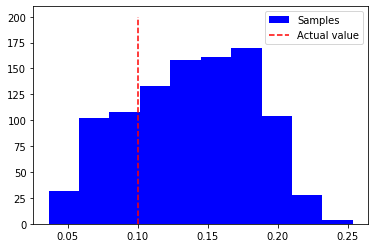

In [15]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

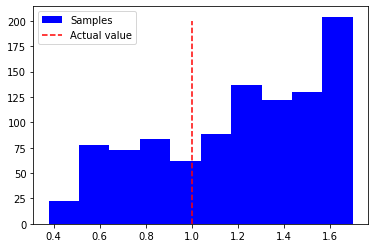

In [16]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [19]:
res_pmc_fake = samples

[[0.160948   1.5438115 ]
 [0.08595913 0.71211951]
 [0.06219443 0.52379897]
 ...
 [0.15641889 1.65381068]
 [0.11079995 1.15542879]
 [0.10668317 0.826208  ]]


In [86]:
print(res_pmc_fake.tolist())

[[0.16094799589476436, 1.543811498730976], [0.08595912589939454, 0.7121195144519014], [0.062194428230645527, 0.5237989744075077], [0.13226140616017612, 1.1345972860675368], [0.07752458352138518, 0.8785060789867296], [0.180693895825659, 1.680190128022492], [0.15853470030156636, 1.5361498957057989], [0.054991012689544774, 0.4673000951336638], [0.0521961048934084, 0.41859562819192897], [0.11200743675362043, 0.8833697456281238], [0.19270644116202976, 1.636155666495334], [0.14028250468797532, 1.1196597801260368], [0.14252012055194263, 1.2929636737750605], [0.09182113827904312, 0.8510351158683325], [0.11195368426092589, 0.9965947307478867], [0.17833105959812948, 1.535218897808016], [0.16151799999275515, 1.3209595257091415], [0.19526404644867082, 1.6625219370704856], [0.100783660801974, 0.8709918293742693], [0.06684815367422897, 0.5883156608350812], [0.1458187338708484, 1.2962510221048877], [0.12868583902966402, 1.1957009014057587], [0.20606074044781045, 1.6757409336171936], [0.14022417071346

In [74]:
samples_pmc_fake = [[0.16094799589476436, 1.543811498730976], [0.08595912589939454, 0.7121195144519014], [0.062194428230645527, 0.5237989744075077], [0.13226140616017612, 1.1345972860675368], [0.07752458352138518, 0.8785060789867296], [0.180693895825659, 1.680190128022492], [0.15853470030156636, 1.5361498957057989], [0.054991012689544774, 0.4673000951336638], [0.0521961048934084, 0.41859562819192897], [0.11200743675362043, 0.8833697456281238], [0.19270644116202976, 1.636155666495334], [0.14028250468797532, 1.1196597801260368], [0.14252012055194263, 1.2929636737750605], [0.09182113827904312, 0.8510351158683325], [0.11195368426092589, 0.9965947307478867], [0.17833105959812948, 1.535218897808016], [0.16151799999275515, 1.3209595257091415], [0.19526404644867082, 1.6625219370704856], [0.100783660801974, 0.8709918293742693], [0.06684815367422897, 0.5883156608350812], [0.1458187338708484, 1.2962510221048877], [0.12868583902966402, 1.1957009014057587], [0.20606074044781045, 1.6757409336171936], [0.1402241707134652, 1.0910489820194902], [0.06210412833428317, 0.5783398675191168], [0.17395796214431206, 1.6441617950903558], [0.1706015324214039, 1.2438098775950912], [0.09863578220961328, 1.0652143591042877], [0.07000587496347091, 0.5395229584449709], [0.14521463701968934, 1.2457592388559398], [0.18834769425489228, 1.6504989582013347], [0.06631707281490978, 0.562252714124762], [0.12842874342818786, 1.1759242649995474], [0.0756785618644041, 0.7070056426974407], [0.14018024037347848, 1.3335202732560294], [0.1222769731021815, 1.2008670940901625], [0.0527868290365123, 0.5231240739661104], [0.08736935678897112, 0.8328124857414846], [0.14335675236662693, 1.3802508562088085], [0.0652979975138126, 0.5908574480485145], [0.18841183065260397, 1.629379322274814], [0.21223198192059115, 1.5226725838610913], [0.13824308973783545, 1.17287651829872], [0.14864609176165072, 1.299997034396729], [0.059040269315175524, 0.5850891514276587], [0.08450658027651056, 0.8762883504401799], [0.11393367258172715, 1.2242948873195725], [0.13383175743366743, 1.1452019092243777], [0.15440303908766254, 1.331877462851557], [0.07656941676514034, 0.7456227777913916], [0.17753213841503618, 1.467808388717434], [0.1190947018616092, 0.9879277600729728], [0.18455875787094417, 1.5917908034691377], [0.17214503157287506, 1.4496354048969309], [0.19037242880861738, 1.546968435871965], [0.12035961415375312, 1.1188424001064374], [0.2026382881413764, 1.5348506610390331], [0.1338847153717783, 1.2472149132473291], [0.14136195790874687, 1.383253805486397], [0.06949431666123884, 0.5757234393106325], [0.12831001735272954, 0.971634193012701], [0.11085670644060837, 0.8364110889476405], [0.12861828708350864, 0.9835712914012514], [0.11914734582169598, 1.201264727698686], [0.13648829378508326, 1.4724665783022797], [0.16816611373583337, 1.2850464623903561], [0.10181976747539884, 0.8283849277913029], [0.10390388456655625, 0.8165644621848918], [0.11272410926902092, 1.1489966070477506], [0.0696913157361871, 0.6749137929309652], [0.06487650928863262, 0.5584000053899169], [0.09005199377992154, 0.6056834413858184], [0.10170770460560917, 0.8274820978900117], [0.11196165753192323, 1.0735759700105911], [0.05468138153226519, 0.538521337638922], [0.21601121831717465, 1.5883597380787982], [0.07676220127960567, 0.6842957841694112], [0.22661112101203434, 1.6953108444730243], [0.15658557993577427, 1.4356864179363535], [0.06011736716871082, 0.5121189212731319], [0.1864024701152484, 1.3541562474725506], [0.189717395397632, 1.5728671419923963], [0.07381214947272102, 0.7214558694980593], [0.0932227901820283, 0.7106215675914189], [0.12438646863958025, 1.1885120603889316], [0.18300882744008426, 1.6877174333336455], [0.14010153577986986, 1.243969476867743], [0.18748337838510118, 1.6173076054067415], [0.11815630676382571, 1.289085648110341], [0.059694016115908535, 0.677484209015929], [0.16573401754646658, 1.286691202711573], [0.17314527995617576, 1.3645065131919387], [0.10637369313655069, 0.9582310720612899], [0.15307029465434296, 1.3782603705952805], [0.1950406697041572, 1.5513359214452176], [0.1696458415499337, 1.6897035885972425], [0.1966416861573456, 1.6551859312364234], [0.17254019715934918, 1.5132833120496463], [0.10452482148440254, 0.8183131252973933], [0.07419526825039824, 0.7110118622551284], [0.17628361888689942, 1.4709719073958882], [0.17843192600054408, 1.5515903247134277], [0.07706573224168299, 0.6911872687680533], [0.17860635351759427, 1.6322091685740423], [0.15701501342224555, 1.6017262739430982], [0.1443299985718851, 1.3133295315501776], [0.14668448654602653, 1.3127309323276706], [0.10143442466868231, 1.060359498693229], [0.09247323890000826, 0.7900823987807319], [0.13052712432765648, 1.2022788746266535], [0.15179694570601776, 1.5492307979935989], [0.08795360729724641, 0.7714903214963859], [0.19452830240171468, 1.3945064786172605], [0.14590088388253017, 1.3088755099425824], [0.11160523105657745, 1.269050334548377], [0.17527494328286833, 1.6759138517543801], [0.20976139794579032, 1.6796881774414285], [0.21990328646349486, 1.639859980374413], [0.17017677765006425, 1.586861586851904], [0.09412079227289569, 0.862246696085399], [0.07084966677451993, 0.5797194146427499], [0.07421432962972332, 0.7021406348741366], [0.21245924860233809, 1.5675960879524184], [0.18628486763035204, 1.5143912834312725], [0.19978408028030484, 1.5884732013960803], [0.14959241974608356, 1.5063919372457477], [0.09705011440865327, 1.0520129285137332], [0.14557054984868653, 1.3178638892839154], [0.13688305800031927, 1.2854591852866168], [0.15500531011750848, 1.68638670907143], [0.06409530668288756, 0.5716177276789564], [0.16942200869219315, 1.6334771131460946], [0.1475095440482408, 1.2484070084686727], [0.10098668521156359, 0.7402782092385024], [0.16579760551139566, 1.4548734165737363], [0.14178471088442401, 1.1221371896704966], [0.18515119191485782, 1.6576301131430218], [0.20066361721231765, 1.6405883885271297], [0.12251598802753287, 1.2571604244220136], [0.1401877343953134, 1.0431877253808275], [0.06406091713841985, 0.5824061665990801], [0.14605795754693063, 1.2671381331127365], [0.05402168010366682, 0.535607585720526], [0.19129478731157887, 1.6105989239430532], [0.22250864042931356, 1.4974415444539415], [0.10116462251889026, 0.9323855130575593], [0.16304796332648955, 1.2603371074451182], [0.15341824017796646, 1.55288867410155], [0.12195154895598788, 1.1040096576395668], [0.20490215089473163, 1.6030915033954423], [0.16471842273286055, 1.2894186604470428], [0.158140565166425, 1.6482093869255081], [0.14363868208827874, 1.2927459301999462], [0.16953266981564555, 1.432985872890407], [0.16855031713435353, 1.6432570050640696], [0.0991946937699504, 0.9377565415907838], [0.15415170861908228, 1.2615720823547376], [0.13780797510028908, 1.3244055125398864], [0.2099504717096268, 1.679594619785081], [0.11302966193498326, 0.9417877260727597], [0.1334507162323424, 1.3478176299382398], [0.07876178931656057, 0.7343790811322135], [0.09149122720964371, 0.8315762036212943], [0.10503426773407734, 0.9459002235424977], [0.12546206905777124, 1.0474543479040876], [0.1653626236610455, 1.361203545821436], [0.12251761496422794, 1.1591432344768202], [0.14403921831879307, 1.3427409694697947], [0.18409001025328756, 1.6705761084448894], [0.13709468161388727, 1.3026853995756427], [0.17921250759703145, 1.433281452051887], [0.15548483682177672, 1.3889630337901648], [0.15031164226220114, 1.3754938184026797], [0.18947752776705087, 1.5964712598906874], [0.08857596905533466, 0.7911040142371927], [0.1147222351239253, 1.2659580925361393], [0.20460705400802456, 1.6409242340530943], [0.22668045257919356, 1.6955424669395194], [0.05201283400971754, 0.5279961209585404], [0.161209880469341, 1.5094212396778612], [0.05297561301232037, 0.492327260192195], [0.16995326115655773, 1.6637895172950312], [0.1553920530258047, 1.2590771142304495], [0.20351744350827738, 1.6807796741069343], [0.15699245686425436, 1.2074558263117696], [0.08770319720161251, 0.7896555772349909], [0.12952799538123014, 1.2804242039349436], [0.1921071317600465, 1.583973733406259], [0.17909174967024447, 1.4323133796156113], [0.18881079650624039, 1.5833197117307312], [0.18053127850473158, 1.4988036807235035], [0.1669908434759877, 1.3279458158853608], [0.05910143223536113, 0.47918970039112685], [0.1299461877979797, 1.2524362511232172], [0.07986594413798838, 0.6109647769117437], [0.13633069379904583, 1.5291037836686519], [0.13381017049649874, 1.5415823421313974], [0.07238810255653033, 0.5088664555120173], [0.10678285922560939, 1.1962858747144467], [0.09132116751496099, 0.7379553326838454], [0.15448549133545786, 1.3883211073009638], [0.09416843031231856, 0.7597768856771392], [0.13092611054242828, 1.2215141769958968], [0.13185937168735526, 1.024449426115406], [0.15590600229139345, 1.2611165429432802], [0.18638195835448945, 1.5917941668421005], [0.11265551358921859, 1.0457442209210785], [0.10022589260766904, 0.8409611357529211], [0.18573657269743862, 1.541477408199277], [0.0696348272521848, 0.510180843866507], [0.045580946571915665, 0.5100705582253432], [0.11661441790292154, 1.1071396446190391], [0.10700404866455421, 1.0463244749504907], [0.09571611462346227, 0.859202522875243], [0.19947768899805263, 1.6161698944915681], [0.1628792332228998, 1.5134334081304983], [0.1756508814661043, 1.5746791168255265], [0.21511527272477407, 1.5301692571934036], [0.08319036100060889, 0.8264867310603685], [0.14937432399128883, 1.4613501636489081], [0.15736783509092098, 1.1979277368151227], [0.13825315745769132, 1.1003577556568096], [0.1240676872111377, 1.3626827010926248], [0.07659478784154188, 0.6750952712582368], [0.09758710638857596, 1.0530541914823803], [0.19646918929033275, 1.6856901046187445], [0.14814868919280402, 1.3153260165915897], [0.11898485219674879, 0.8950973737303981], [0.1979119613296682, 1.552496961302241], [0.16364140543990105, 1.1658681358988965], [0.14479292016393383, 1.1893101268417534], [0.1541841009238825, 1.5734919180532576], [0.11471071190861268, 1.215884467903374], [0.12941459184021378, 1.1675169733481907], [0.13208352046667463, 1.4349146902508452], [0.09696461975656302, 1.093333675463713], [0.16935155457759404, 1.5746763164033006], [0.1155715127781628, 1.0756186783097177], [0.1649658245932161, 1.4584063211789207], [0.18278869720151242, 1.6646954539135983], [0.17760529491697336, 1.3973128507479602], [0.14585396343969967, 1.3114566529788239], [0.07914636180117511, 0.547886419904403], [0.1922688671277768, 1.556408451765936], [0.1444728725178664, 1.3548813064861667], [0.17412675571069497, 1.6266520490717369], [0.13180719559440054, 1.1327714064463064], [0.1795242939440532, 1.6370697472241362], [0.19096088688221977, 1.5925092166438957], [0.18220941461748585, 1.3940510686616499], [0.1390505587971513, 1.22793971765465], [0.15134418924971293, 1.2979933930718695], [0.16821113231077542, 1.4529275694923827], [0.11440993404005226, 1.0748485011162943], [0.1575263710640162, 1.4409782693373017], [0.10233348806931325, 0.8405223736120699], [0.1819686481752504, 1.471964871798075], [0.16102257645183776, 1.4960014177845093], [0.11663021622994751, 0.9269800537411865], [0.11947034341661615, 1.252393345707132], [0.20229052208092962, 1.6083542322269968], [0.10947289061282181, 1.114079321588554], [0.13568093773204604, 1.1291893751232291], [0.1802599869992159, 1.55431479429769], [0.13590897933391058, 1.2313424081067996], [0.167865431885889, 1.5335697345843495], [0.18557466635450534, 1.5200228549814374], [0.14550765340166966, 1.2189175138856614], [0.1004978616439433, 0.9529615066776796], [0.13654285339864008, 1.1809346823660438], [0.17681103950394308, 1.6220281897179558], [0.1448442168279379, 1.3623404786225675], [0.0782405316977981, 0.6074193386682323], [0.09227774712527827, 0.8019033124662264], [0.13744846566423316, 1.274710881650154], [0.19609475465917722, 1.5922433981578736], [0.1286678814784935, 1.075445240981197], [0.14319683146675463, 1.380009082585049], [0.2203387032599064, 1.5690545654705181], [0.09607290903538647, 0.9919378521097767], [0.1548266467859209, 1.2127839012008623], [0.10750688212860984, 1.1093541147629262], [0.16304658141953166, 1.2132431122270448], [0.12866632897217556, 1.1349337587066526], [0.1671564647039473, 1.429278413757303], [0.20203853360840757, 1.466547466511515], [0.10453726870735808, 0.9927734408613486], [0.19685285214733933, 1.6885265723701401], [0.11161132466705553, 0.9868506473256027], [0.14232337748927185, 1.257678887879925], [0.11192166895997467, 1.0900633269880617], [0.166382271186535, 1.4698366522658093], [0.1538749066251336, 1.1333544215257692], [0.09110134373627315, 0.6138054680435799], [0.2152679741683626, 1.654442461085077], [0.1764193852823638, 1.658826354192892], [0.07746745703118778, 0.7883175823275962], [0.06187214618409968, 0.5955516936937865], [0.05197383263027427, 0.5453561459714453], [0.20543134157991463, 1.478201154817283], [0.15194427562917096, 1.4091743682050082], [0.12908342299262868, 1.2543337487168358], [0.17709755799474114, 1.58628789302223], [0.15513334405496457, 1.6483846381261127], [0.15955450932571447, 1.5978974952326428], [0.08388105715098196, 0.8229089311921982], [0.07380811972024987, 0.5753598383085684], [0.047570259214686994, 0.5384497815717997], [0.12258769688128099, 1.2063897973493296], [0.12918690514552988, 1.189209312796707], [0.1855319584334203, 1.6729268917433222], [0.11833735186898452, 1.085751609267826], [0.10352428765978043, 0.9626528982893843], [0.2021756567407537, 1.5884413181172508], [0.1938358888842369, 1.6540441713449814], [0.15737659344916943, 1.6724668633901565], [0.1542742590394999, 1.4152613263673999], [0.16011714646206188, 1.245035463272158], [0.13420022044901628, 1.3287861910114307], [0.1858787390227305, 1.391214093728954], [0.19208045142576757, 1.5407083797269328], [0.17014732324460377, 1.6339836017662592], [0.17259830751740238, 1.3644486884693439], [0.18657382011412407, 1.4700112379183243], [0.20578135434942188, 1.6541914331882595], [0.1346042902110649, 1.3079770548856282], [0.20960098746343714, 1.6567118480294876], [0.1341652986740562, 1.111452625576909], [0.1588717643059428, 1.6379103452294606], [0.16308015158200692, 1.4374941763672775], [0.1841855090437193, 1.3994712668813887], [0.12737197979269238, 1.0848291608234988], [0.07146043223597968, 0.7059085261978801], [0.07514743086534495, 0.7006153897615995], [0.16721503434914886, 1.6954193437090317], [0.1682021394775937, 1.6115639820055019], [0.17747273913750417, 1.6421106957630853], [0.05912444561647506, 0.5222811454882007], [0.18683573569340028, 1.5252657992510184], [0.1272798095985822, 1.279825479868807], [0.1314952560601423, 1.0429614325461012], [0.14430760232172135, 1.33570682335963], [0.1888682073592084, 1.6039788353945645], [0.16223387834050623, 1.3551788083723941], [0.051628777668618536, 0.47676072589509955], [0.06692094364623175, 0.5471748333111462], [0.07331195320403416, 0.788925645815082], [0.14270951368764948, 1.6788405884409288], [0.15046064496413153, 1.5727255231920818], [0.17680155494550684, 1.6222932311234843], [0.10365405947965853, 0.8896990517134821], [0.1356022158612368, 1.0548367969879004], [0.18748110915860894, 1.6888454911676067], [0.12467351249554912, 1.1611161320904022], [0.062086732546691704, 0.6843786730792781], [0.11037278291928959, 0.993348481656655], [0.06446008791874751, 0.5380362579701898], [0.21118811021134992, 1.680573812798014], [0.15178837571754436, 1.2646566020860237], [0.07674994967831404, 0.6651582259445877], [0.13657404539892554, 1.2549080581215821], [0.12673790423002723, 1.194616683368485], [0.20643426032136886, 1.619536708794313], [0.09826723221630354, 1.014538886532342], [0.1250139354584911, 0.7930420620110079], [0.14320797116702458, 1.5152061541689474], [0.0634287624049463, 0.5715700767193373], [0.07976518493764868, 0.7707009912342939], [0.16780727360706368, 1.4032217610556486], [0.1055527606717607, 0.9002327540442507], [0.19582835533437576, 1.452522414652704], [0.10667593414194983, 0.7693888831531115], [0.16964384156518164, 1.5495456873052191], [0.1378904002437782, 1.3294828618484409], [0.08820239155752703, 0.8179563402151607], [0.13054663601797706, 1.1675780187968663], [0.1740782246512456, 1.6538483976532095], [0.128716795268632, 1.03729004627802], [0.16196713019794584, 1.3499157498052037], [0.16230812670399736, 1.4916674853123726], [0.09390028595894631, 0.9048266597161808], [0.10736832104269288, 0.9357529966131717], [0.1761159446291103, 1.6629697683879545], [0.15725511804662834, 1.1943286951051235], [0.0637567070642756, 0.44114461469748867], [0.08678788255391134, 0.6278351732715389], [0.13310879481375065, 1.2885561048618976], [0.1041782069354108, 0.8737255065967562], [0.141022855958469, 1.1353187677445806], [0.18617070968826463, 1.5891725214732246], [0.14248260522072143, 1.3080878046126792], [0.12719930390477768, 1.1674835606222136], [0.17446381477636352, 1.6344753947485433], [0.17177172909851995, 1.3213847666538439], [0.10587655861198082, 1.1714136094140917], [0.17865192943967667, 1.4166758346500576], [0.15153472881868826, 1.666755153576421], [0.04780916337876166, 0.5470928708602233], [0.08718486585292534, 0.906899126559101], [0.07490595365451334, 0.5217138014320041], [0.1545942993231553, 1.206262331861704], [0.09119114122579569, 1.0877668284762756], [0.14728681631382545, 1.1397693767345416], [0.16947831603093244, 1.4286341589253475], [0.1469761207763137, 1.229365288637414], [0.1794081831420317, 1.6111926889629802], [0.1207904152369822, 0.8929964143833258], [0.16759742277650316, 1.3027151802225194], [0.18308107901910362, 1.4944352727841217], [0.16008629304388278, 1.570516843676287], [0.17134867937706755, 1.471815656208938], [0.19664421446553235, 1.6322334513581649], [0.06824626507178218, 0.6056605945120191], [0.17259208694195616, 1.27520123102937], [0.199646282395369, 1.6425645695770288], [0.11413119640719628, 0.8672319273166493], [0.16273270115472954, 1.3038588057624978], [0.15779435222664126, 1.3897520746534484], [0.0457602676946925, 0.3977681152803679], [0.2022510041271017, 1.568644834006327], [0.0844891630295771, 0.6703235855988339], [0.16450233582265733, 1.2201250259267071], [0.20317792317724875, 1.5604458579198504], [0.22434838308936933, 1.6337359158433629], [0.1425299739769545, 1.3527810887282212], [0.11969653871951888, 0.9393534426135496], [0.10717875868581941, 1.010855892309301], [0.10781562284568663, 0.9639487309779429], [0.12324155936162334, 1.1713504390881186], [0.18133396293494644, 1.623798781498378], [0.09983764381637383, 0.9370822974531314], [0.11306561919068514, 0.9317044320136473], [0.1739343801061491, 1.6303170679060053], [0.0827616989895285, 0.58706902130092], [0.12677542926347796, 1.1396551451786177], [0.228359582275468, 1.5806768546611996], [0.17608900941724961, 1.3409644196317807], [0.16239022650194193, 1.357173724679806], [0.1693610151700327, 1.4727361946911788], [0.05601502067384966, 0.6225075148390529], [0.19590562215033386, 1.5406219520649043], [0.22548717503238552, 1.6195565793604716], [0.10228560972974125, 0.7992932882276065], [0.20234617963022436, 1.6469491224192319], [0.1150913303800642, 1.2112527188610067], [0.1847709301770393, 1.6460705305298655], [0.06185357536457834, 0.5488024402937657], [0.20814724488087913, 1.6696005234783102], [0.11063692622297681, 1.1954825383436454], [0.17455038965319503, 1.4498807382037981], [0.1998095414938963, 1.655831900175313], [0.13639224575050868, 1.0711895220748264], [0.12581977510734352, 1.3181225145076028], [0.13948716584560958, 1.3909062643883303], [0.15729715447875217, 1.5486898455116491], [0.131126411815689, 1.2127245843709462], [0.16732649620996404, 1.3563480993741823], [0.14740474198784997, 1.145181399777787], [0.141312310396928, 1.090157618660117], [0.1049412995313425, 0.7454993485549419], [0.15993286785257066, 1.4128200487954714], [0.19306955133557813, 1.6379024615028597], [0.11995064342363207, 1.1716424267710477], [0.0932770039050692, 0.8450792176175461], [0.09537816688781037, 0.9851501253195792], [0.07242102260016736, 0.6590352243404746], [0.12679360410781848, 1.1363859396455098], [0.1472340406522678, 1.1006910299246033], [0.13215253079707173, 1.2452533810458366], [0.13355218820155124, 1.0660327879585751], [0.16356706724477482, 1.4183531229437087], [0.12820693106145262, 1.312482371482265], [0.17666366821921228, 1.6400662165520816], [0.056959926940971024, 0.5359466969101775], [0.13263733254212232, 1.290950649726345], [0.18209350880340408, 1.4281101828327556], [0.19068506871767432, 1.6451067130668477], [0.1770029986368391, 1.539145485647733], [0.20234909860875527, 1.4835816051994957], [0.06363299406101115, 0.6634023065127795], [0.18919780682117898, 1.6889939028383365], [0.075257149472942, 0.6661908865041944], [0.11050943405785425, 1.293935606992707], [0.1125999045419009, 1.0667027784155634], [0.1194574335434058, 0.9922496634364476], [0.10240122818406967, 0.9195829020049725], [0.20314048607677962, 1.6955786048163297], [0.119423045579099, 0.9886047995639405], [0.085294259839775, 0.8681654463392611], [0.06610670968420129, 0.6162158275384719], [0.175386258407421, 1.398944917214785], [0.10088137350590645, 0.7969341126972797], [0.12441133085516928, 1.2750128102224418], [0.09737096524530763, 0.8707169559815805], [0.10618395267098367, 0.7536854265080909], [0.11720568472878348, 0.8495652836535323], [0.11085977047985113, 0.8384799923097824], [0.16315008573781314, 1.665948252214847], [0.1460291816875615, 1.2282158632386473], [0.18130138886774536, 1.4297721226148303], [0.17872744897789467, 1.5260174468401866], [0.06813319400928369, 0.5923258310972492], [0.16331317405207374, 1.4757924960272442], [0.06804829002341521, 0.5469259451317671], [0.08889816589781763, 0.7198474796982846], [0.21005190380945604, 1.6411685347571536], [0.07470383079695907, 0.7441392001221299], [0.21844057472170153, 1.6364811845253222], [0.2154205312821262, 1.586141634579727], [0.16550324320865561, 1.3745971751752293], [0.07474121306577275, 0.5533957627471726], [0.16493263409162698, 1.2564661367911605], [0.15370732702032286, 1.1840109255025533], [0.13818254524702947, 1.5696930448587816], [0.07968155504487608, 0.6432100829652784], [0.18036310611668288, 1.4638651236063602], [0.08623540134015184, 0.8425210074797467], [0.21174418424114627, 1.6374677488203362], [0.09655704871199104, 0.8624120203481986], [0.10543496513616095, 0.9232366390461842], [0.19598234053717678, 1.614087098123903], [0.1932858645283398, 1.6113532289162278], [0.1953747240406762, 1.563436519588612], [0.10046171906856396, 0.7661489447984512], [0.06440057780908154, 0.6849684874498305], [0.13260998358991719, 1.2453904696408031], [0.14796738641693546, 1.0422857085260318], [0.09075631910565572, 0.7115931448223247], [0.08394751477101531, 0.5901215943697612], [0.14789423033873922, 1.3168217479614437], [0.16848468492799887, 1.2813017504471353], [0.11907366399199508, 1.1600164491613951], [0.1645380563822673, 1.4935159518487653], [0.11570463661419271, 1.0222796414223758], [0.24342560530760163, 1.5693685764363003], [0.18179495814896274, 1.3872865087683013], [0.17118173481009993, 1.517685266758406], [0.11691918342825294, 1.2229954366858424], [0.18430495640434288, 1.6519399876212375], [0.14027894117937675, 1.5138081304903999], [0.06598306709612033, 0.5651576448206136], [0.1765639372084352, 1.39769909476226], [0.11333049505872889, 0.90515740794057], [0.19796945384521364, 1.6551453414849508], [0.07985438652471942, 0.8092740261871948], [0.14886452580909318, 1.5980608870652808], [0.14618566154472856, 1.3153900669606948], [0.07618051901323819, 0.8309484155020442], [0.13993442230923736, 1.3743362167298192], [0.10089425096541793, 0.8806918013444092], [0.11538368172802017, 0.866055856275604], [0.0385256269280891, 0.37824344436094237], [0.20029983046871278, 1.6702018543496293], [0.09864392226557324, 0.8218704908233853], [0.13909910911108223, 1.2634368106153497], [0.17292324550949448, 1.5985561875449177], [0.06516105990811052, 0.6922684691232797], [0.17883050989264054, 1.5732482927345397], [0.18051157716244437, 1.599105477357741], [0.1073847122566945, 1.0726141072895938], [0.21883822359324565, 1.5285326689664045], [0.14699205544627877, 1.2993699162907306], [0.15383707938079982, 1.1475330448823815], [0.0806621408080789, 0.7854820665472976], [0.08168340586285756, 0.6691997683161296], [0.07000716596729699, 0.6891716847872265], [0.13463100181499374, 1.2370742736710885], [0.12718748224476636, 1.3040194015147248], [0.20334727754748314, 1.6497971701237812], [0.25384748903353843, 1.684548603492898], [0.1365248715757926, 1.1519630342762819], [0.20494799828267635, 1.6802265238406184], [0.0648773040251256, 0.5858675274921742], [0.13705994796580717, 1.3371218297418948], [0.13738222364980948, 1.1989697759640867], [0.19352656767358062, 1.5420051054896864], [0.1761533177933352, 1.556621999293956], [0.11008280920969125, 1.1440504954884558], [0.14788384716334224, 1.4810695631926334], [0.10358359879385033, 1.0458022903730635], [0.1677423145801823, 1.2463500452563872], [0.08491911410507205, 0.6672919992385431], [0.1444024522878656, 1.5918789581894353], [0.0691400987001139, 0.5638305033686459], [0.2324881102787872, 1.596980183211112], [0.17780342939208538, 1.6840053316123305], [0.21370830559487627, 1.3891656092950213], [0.15802616523278026, 1.5939228736219246], [0.21176674692404984, 1.593651429292155], [0.12067213578665681, 1.0669689387702814], [0.05586372904902438, 0.4928193173901159], [0.20665265712010028, 1.6880689118803], [0.12735042715900857, 1.1038272437279657], [0.16536107124798252, 1.2517362759433017], [0.17798808692601026, 1.5879000040757196], [0.1108026086428665, 1.0940236608114744], [0.22506691877562876, 1.6380484463555847], [0.07724321898829051, 0.5878708549159336], [0.18550346378165056, 1.4966765884049087], [0.11248968815917464, 0.9663049139945803], [0.10634843096425875, 0.9027746146929837], [0.11273327205971112, 1.3278218837595641], [0.17847410226152552, 1.4984983040687638], [0.09355579682976152, 0.8972313722069016], [0.1407842047764777, 1.4310330614867122], [0.09925972528457552, 0.9249618083762714], [0.08662082846161641, 0.7832606982436963], [0.15642393256919312, 1.0885275447402945], [0.1215789129280779, 1.1948654169435866], [0.09452617629007937, 0.7183842840448084], [0.14100975410487296, 1.3001247067354298], [0.13340538116656592, 1.1604190496841735], [0.13257249368436252, 1.2929890860105833], [0.1394874982913116, 1.1123569641137938], [0.10124520175008168, 0.9435576336493131], [0.196429604027114, 1.6763960571636631], [0.14820870121146856, 1.6198566755804522], [0.11618786122848748, 1.215800745007895], [0.12970664695324285, 1.2674332907001606], [0.1921178248975205, 1.529355566386833], [0.19980986658977135, 1.6739180314705229], [0.18623975022561373, 1.4191764819633081], [0.12647166285225045, 1.3473086709989568], [0.18072065095426632, 1.6809829886802858], [0.10473086356701525, 0.9404955377548478], [0.12930351488285197, 1.388561423093002], [0.11538341935686003, 0.9861858960763255], [0.09818155402931697, 0.7780572367994248], [0.20032818801483693, 1.5483701049169], [0.11597721204551031, 1.0377411017545308], [0.064528308038802, 0.5571517552728985], [0.14117613819656522, 1.3109777945666348], [0.11338861061386636, 0.9681396267825731], [0.05122041768916212, 0.5713476700714054], [0.08067259142433088, 0.6142643114115148], [0.19329297470624018, 1.6574654022424746], [0.1460387849919237, 1.18596029478557], [0.19185975846532824, 1.4353131596749473], [0.12923388112896877, 1.2303538735962407], [0.16233747274142407, 1.2452040750788538], [0.1492918750731425, 1.5941213889503063], [0.19717308632537345, 1.5312712344153947], [0.16546902450555712, 1.5819167132388072], [0.16062343487127745, 1.6501689055025623], [0.18125283033874107, 1.4311923164035032], [0.11208466364795111, 0.9301916127344974], [0.124153669063251, 1.1637225102979147], [0.1941468772233447, 1.6316314731159176], [0.07563983836347733, 0.6247077263475577], [0.10742470420959067, 0.8468514390008504], [0.11410145874654429, 0.9843196988707549], [0.1492000210057276, 1.1365689390591198], [0.1732951360758416, 1.5684139216662227], [0.18705269634853972, 1.4054520630041907], [0.16193769230752636, 1.6135012769920312], [0.13152087890344938, 1.2459465918165857], [0.18633696244692147, 1.6377795608386523], [0.17939592664367693, 1.62898101525364], [0.13189501559257916, 1.338723984165316], [0.11294182968357952, 1.1207711792339794], [0.17649995675117544, 1.69846242692918], [0.18931217272636539, 1.520376982785371], [0.19073402545281523, 1.6103170993201246], [0.17759949153116633, 1.6412429682390322], [0.20834803675195382, 1.6064266171336414], [0.04631479288111932, 0.5335815993758622], [0.1398484805269661, 1.0394956126119541], [0.17720197162124568, 1.4014505233301318], [0.1968956975316445, 1.5753378374001672], [0.09752814139499631, 0.8572953960273333], [0.18088651780796544, 1.580839464557846], [0.22405451439692758, 1.5968339864664767], [0.08321863071897458, 0.8667044561290913], [0.16800857322250845, 1.5606256132991798], [0.16705888747671377, 1.4570906174726936], [0.15591061079273205, 1.2448414047643626], [0.13830650858695698, 1.2402234715312945], [0.12022449469716798, 1.1625315023585736], [0.08367107828723189, 0.8389911263926579], [0.10189391708447362, 0.9508917020888543], [0.1679935905430005, 1.5832533482618933], [0.19365632307508376, 1.4453247912973775], [0.1308423437749527, 1.402280650433318], [0.08614777469857751, 0.90875322929816], [0.16905444562387575, 1.623567023081353], [0.05129260605792786, 0.5310590083706949], [0.18325261493619183, 1.547410782605608], [0.1515039613919179, 1.308381301377718], [0.08996038675447489, 0.7054687857727233], [0.18155363952251805, 1.2579366625167943], [0.11539009824518258, 1.1375301925438714], [0.05712677988650993, 0.47965528990366746], [0.13051145767044714, 1.086048437456817], [0.08281408561606077, 0.7244675888767134], [0.06808216713928653, 0.574583306770096], [0.18130027259812434, 1.5688574846952412], [0.13431906820819245, 1.2823019833606126], [0.16064520275403424, 1.6608977838610504], [0.05398493590989133, 0.5157557302257121], [0.15280850971241824, 1.558517788852884], [0.11171892712631809, 0.8859844623715781], [0.14178325675109044, 1.2737661683360808], [0.18266310712518613, 1.6407028122930951], [0.05831870432807199, 0.599014939158313], [0.11399025362085696, 1.0797049536323666], [0.08053882939828735, 0.7201138310645778], [0.09891622732822994, 0.9656042038007758], [0.12316112875881412, 0.8468914827203855], [0.08927141613300711, 0.7082746604245009], [0.13082451298129155, 1.1494086122538891], [0.186568357558173, 1.434936187647031], [0.1665522551892301, 1.5205393536981324], [0.14012569832187943, 1.3778779818205769], [0.215570496448189, 1.5458514524708165], [0.1723534242627926, 1.4055700667864692], [0.06152013415265943, 0.41888219741086513], [0.15562951839112016, 1.3311863046125463], [0.1731452619118513, 1.333814282640741], [0.07781179928488924, 0.7105289647982544], [0.1436796825727538, 1.270682576232544], [0.08229166970882776, 0.8820221248037992], [0.11993614337968794, 1.1774529582998414], [0.18519343116751505, 1.6872885262205628], [0.08956640639080943, 0.9580192299923282], [0.15183105057572924, 1.3556999186554763], [0.15832880111934147, 1.4921247008206047], [0.19141329776572003, 1.6224515588914996], [0.09928677671293268, 0.7614091447038911], [0.2059558421471277, 1.5559086001506852], [0.18626206485058117, 1.5989669489510583], [0.15701215424324394, 1.5776942207902758], [0.20923997733390656, 1.547277977892013], [0.05214351547627378, 0.48150931183761886], [0.1560980970824617, 1.5576156734936644], [0.07874622975087138, 0.7180769854224318], [0.13007404954402324, 1.2240483831732576], [0.17206589014700488, 1.5070872620463343], [0.06704910555440981, 0.606237353847111], [0.13876173088989602, 1.0700394662064825], [0.16296626590938146, 1.3130913007004206], [0.07890766802559399, 0.6744467781203389], [0.1018555042800593, 0.754307206804753], [0.1900099686294491, 1.5868414058558156], [0.12102713687697578, 1.3401502738504887], [0.11758242206776087, 1.1933147456770075], [0.19625240917809822, 1.486531807750206], [0.14974124621135765, 1.5184868806378835], [0.15604982269578038, 1.5404763126265897], [0.1235270338769262, 1.3413284876090443], [0.09271032571659214, 0.679921652253371], [0.1558614629337431, 1.60890613007974], [0.17420425069544254, 1.478359978298069], [0.19069721699353695, 1.5369958727116206], [0.1356153994002368, 1.428246764367594], [0.0633297078650199, 0.4881627339683696], [0.16944484765297194, 1.6277481818895998], [0.15392934280009077, 1.471993393860392], [0.10850042809542489, 0.908601010298167], [0.17217348555632128, 1.3164787027578573], [0.15993201405133223, 1.3866633435967808], [0.13653809488253835, 1.2331509510058403], [0.1526847756988785, 1.1609503862848505], [0.06103243123050636, 0.507699663594613], [0.12177270532532973, 1.2217848673692924], [0.12784517563623093, 0.8779326092497947], [0.17382037096583802, 1.5146246603704308], [0.10475265904344928, 0.7882134544448769], [0.18841364909016944, 1.5367318107413872], [0.1829534333327164, 1.5720474358751335], [0.06387478957291032, 0.5920743989360852], [0.17506894217778157, 1.472864046574557], [0.05815373678475341, 0.5538511014174993], [0.09231306211352835, 0.7725419031251516], [0.15941549770288904, 1.2199778250584001], [0.137904757372733, 1.2344538278918502], [0.10198223816652023, 0.7977036206647723], [0.10117125170226099, 0.7019623659562217], [0.15350137216059193, 1.4483045103136285], [0.2079604606582761, 1.6347585421431727], [0.15148433484575388, 1.4837730577725912], [0.12069405294422803, 1.0972762597022552], [0.14860878575061565, 1.5048656551873403], [0.048353887259285105, 0.5143267951753], [0.15718861381937832, 1.6690259338883413], [0.0881560715066679, 0.7242450584716664], [0.1639543116455104, 1.1360276340001043], [0.1876546726741643, 1.5559243570372245], [0.08898790928381434, 0.7958827246964106], [0.07927028824511391, 0.7995513453100345], [0.18758743882405113, 1.5518930757974292], [0.16657455849177513, 1.4229550754770535], [0.11042434597502648, 0.9017061494062593], [0.18026805280268185, 1.4341759432975096], [0.1295730190863992, 1.2224409076222986], [0.06797845966208707, 0.5577636197408057], [0.18837720948749767, 1.5802730754414842], [0.13238946622824843, 1.245398370193743], [0.08783256740077064, 0.8887937973494232], [0.06055063880480348, 0.702152683643262], [0.05365259622859506, 0.538621039438504], [0.1345641947041799, 1.3451141392294907], [0.12009898028646038, 1.256436429872989], [0.06453159931752608, 0.6054605734476378], [0.08651535530877832, 0.7155140327377448], [0.17235154324311108, 1.6399948371298092], [0.1932957113549732, 1.4752864231094271], [0.19572851898084997, 1.6681314339370716], [0.17274109310956576, 1.4380403021507313], [0.1457813464887045, 1.2203860524510637], [0.170263701844599, 1.530254598316607], [0.061784760813821775, 0.5920432215073459], [0.17307964912931023, 1.5958693377329536], [0.1646669239093658, 1.6116976791832147], [0.20673565463200333, 1.6523881065282389], [0.08514037872616162, 0.8432708143055969], [0.1345402290335576, 1.2586466545800918], [0.07825983359061295, 0.6210798696509292], [0.19260750541301158, 1.4575433573956809], [0.14656803757573222, 1.224585861569157], [0.05317925169359598, 0.5150860860196639], [0.09478896541881475, 0.750724128450069], [0.1391542517542882, 1.4327858200516808], [0.12034152448352492, 1.1534236260990685], [0.15048909178031875, 1.124876227596207], [0.14684231555800284, 1.585819441902106], [0.1270484543531555, 0.9228682967833592], [0.16536186409530995, 1.5951713660175573], [0.0776151086657742, 0.6219573150914516], [0.1035913377126364, 1.1373760073012005], [0.154572925625857, 1.2535004860083607], [0.13660112673708585, 1.269481776097304], [0.07917410373464402, 0.7097733732811541], [0.19388587313939293, 1.3370744835793495], [0.17251577340837274, 1.5274094061828498], [0.17602255928035768, 1.6657530137307592], [0.10665258172819245, 1.192618086453641], [0.19389737474549115, 1.606976918800608], [0.1702766900113267, 1.3684604773415985], [0.09091305666442445, 0.8459266109574346], [0.08526105096818472, 0.9918757130139731], [0.2222602861597593, 1.5648777318274283], [0.12017852170196104, 1.224444376726402], [0.07608036245894688, 0.8094816337253216], [0.1389289747900907, 1.1549275670635726], [0.15805223616479191, 1.2695974071581453], [0.06658316783302087, 0.6237353941072488], [0.046699472663732346, 0.40382487754883073], [0.11479667830423658, 1.1043739496241558], [0.13253359570410206, 1.2021131356488466], [0.1830600950856276, 1.541170118949871], [0.08114989039784566, 0.7550110498110764], [0.09432847779272485, 0.8218870349659171], [0.1789800968758098, 1.4831373304092996], [0.09449216392013096, 0.7433891046117809], [0.11886650431604748, 1.3235730782572643], [0.07328362324253958, 0.6305889139632963], [0.2049571018043222, 1.5360040677050364], [0.18512470167246986, 1.640022518765464], [0.15821042029065074, 1.584382650674265], [0.11873407836924099, 0.9529967181638893], [0.180641599051214, 1.554411933724074], [0.2101055247402047, 1.6577589269383761], [0.16251671201268308, 1.0869925659891675], [0.19408019378816566, 1.5883396227319428], [0.06435840643021291, 0.5590785117753433], [0.08829184375102597, 0.8393940218138002], [0.08271994601848849, 0.6308209760735662], [0.18617087374105015, 1.2950510829768636], [0.1324257889648811, 1.1987796476249806], [0.16783586199253062, 1.3219872897183507], [0.14028869001155692, 1.2747116841637274], [0.15507936106524728, 1.2272169006737177], [0.10871304500323614, 0.8959435964156097], [0.17699784521824646, 1.407105145977775], [0.08106405442894857, 0.8098640770371315], [0.123742418263415, 1.4021691398478227], [0.052035591357370486, 0.5529013775892874], [0.09472318667317954, 0.9917933731607228], [0.2001363918562889, 1.5698854656585435], [0.1654943277002865, 1.6529885270222127], [0.10927935848714648, 0.8047363759117785], [0.06162084066006747, 0.6083021011070309], [0.1904516831352517, 1.5089455958367526], [0.18838920508477836, 1.4959634399677317], [0.21679802792820957, 1.5739158769597197], [0.11062616830663892, 1.0065456002568849], [0.09408054577259127, 0.8073717132048928], [0.18087816939546397, 1.6040734237644168], [0.16646523507999733, 1.4767288213878134], [0.206457273270939, 1.6854280587023602], [0.17120466050617084, 1.6872879415996789], [0.13445039625420688, 1.2348283252848662], [0.060662536970742725, 0.6260029728969901], [0.04168066923161186, 0.40138301732509407], [0.1265775164098252, 1.1556563611079564], [0.21266175485464756, 1.596811188970835], [0.20459999378027177, 1.5943923267146112], [0.164778907215308, 1.6774311599259342], [0.15142985559069314, 1.2870390503091962], [0.1712002231827032, 1.636992407556956], [0.2071288005038708, 1.6966118454921022], [0.1262835372333464, 1.2207663187322584], [0.11106941522395021, 0.9039148430326137], [0.12459090415096052, 1.2440634295575184], [0.13309123508560083, 1.315497421771005], [0.04983540388409997, 0.43039637416829407], [0.2010636067826904, 1.474195292586682], [0.11170449780164932, 0.9188311808322787], [0.18239874495454086, 1.4703447008815613], [0.14412074261353314, 1.031277135227113], [0.10451196539214808, 0.8378460696297748], [0.14781033408790142, 1.1932798717687936], [0.16912822168204272, 1.5058063894950742], [0.16386423381717058, 1.5321470505760157], [0.1747249952846679, 1.4154964245876347], [0.056523922265705406, 0.5096642136764428], [0.18020446479177893, 1.6231922319539234], [0.21313983285620133, 1.6229807220201458], [0.06742314004483592, 0.5488223544913555], [0.0927752361774741, 0.7368161412051544], [0.20239428387639954, 1.5732601698866453], [0.21480915955862412, 1.5968839938629902], [0.07986774589337906, 0.5712662015969965], [0.2031414418177361, 1.5976212284622247], [0.19965220249952992, 1.6887987882883269], [0.06409478868197294, 0.6127066577124912], [0.08991664973716333, 0.8888434273453195], [0.11793288786646777, 0.8890600111958662], [0.18754770829467876, 1.3697594846925332], [0.1551240745245871, 1.2668754861877258], [0.16132423957685432, 1.1930736842682423], [0.15071417546460886, 1.1941305902095465], [0.13363351144366836, 1.3560830056518975], [0.07975415461344626, 0.6950698899998237], [0.14234875409031206, 1.3317298370733484], [0.15990466693557057, 1.491341023373918], [0.17746662485251297, 1.4454451209911998], [0.18985752042898937, 1.3803898532540286], [0.14740494072980234, 1.186604600778404], [0.11473468897185873, 0.9726084386526741], [0.14534311807104072, 1.362567411920124], [0.2407395099214084, 1.4933553848000314], [0.15312686829404618, 1.3420544105240866], [0.1598703643480013, 1.3349043003042238], [0.09689996738113602, 0.7681177211906], [0.07485915102800426, 0.7634806415913236], [0.12443262491947267, 1.1199456212967582], [0.09059896594056271, 0.6781229870638247], [0.09265422245286463, 0.8751993760300559], [0.07827108455746262, 0.6946517064419331], [0.14329747870863183, 1.2976877533610405], [0.15068980073217167, 1.6511764325421234], [0.12250600376440948, 1.0488964983412044], [0.16351527771628377, 1.5148759903555997], [0.10470151329183221, 1.034528577196991], [0.08795781441073094, 0.9197970345075495], [0.15749601534623214, 1.412464043615962], [0.14847626430112784, 1.481045653798501], [0.07970889233139783, 0.6932890328015093], [0.13366347525746142, 1.262517321484678], [0.036261254701520564, 0.4324414009602723], [0.09312644907938486, 0.9743609235077146], [0.1581705114515302, 1.3534867178283039], [0.12654980648619546, 0.9763640860517686], [0.06392291426253417, 0.7222439125508392], [0.15364706027785982, 1.3864040607906187], [0.09060815945533675, 0.7126669672121239], [0.18233649830455131, 1.6501196968887302], [0.14724225818986503, 1.4994840345068952], [0.152146222540279, 1.4127465657254008], [0.063389451561203, 0.535442115972863], [0.19522812510958676, 1.5626025966396548], [0.17539566551639224, 1.687792256383328], [0.12729447241095213, 1.2221887778136542], [0.19322603150181797, 1.636746963169429], [0.1255608815555922, 0.9618878998989044], [0.12245755316524126, 1.2095917510193641], [0.18744405570159217, 1.6037426304082227], [0.07566607093565172, 0.730713455354348], [0.20071695668686945, 1.6627511120633476], [0.18489902116315504, 1.5191259711642173], [0.18937807440727847, 1.4872704609461456], [0.1289993724347976, 1.301277200822422], [0.06221302590292732, 0.6476876773586028], [0.10981245654492801, 1.022541619144324], [0.08011360497172876, 0.8163382967471647], [0.13162985447720088, 1.2301699214862356], [0.10910415022916221, 0.7214274985366902], [0.10725860806318409, 0.9863802217659354], [0.0931007600000945, 0.8864955315083615], [0.13880327341283574, 1.3277324133879487], [0.13320143264713036, 0.997088959087779], [0.07103139574161073, 0.6858071284240786], [0.08804925245161684, 0.7222111162706212], [0.17580908344959828, 1.6443047656863128], [0.14612831506634777, 1.3278203909572237], [0.17450529825493374, 1.6459255872442242], [0.15641888602899995, 1.6538106841750468], [0.11079995400177574, 1.155428787055624], [0.10668316529534337, 0.8262080000208756]]
print("done")

done


# Adaptive PMC ABC

In [26]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.26406768 0.97621798]
resulting var=[[0.03460114 0.00209416]
 [0.00209416 0.33470176]]
epsilon=8.835157044444655
w_mean=[0.27423849 1.0179161 ]
resulting var=[[0.0345846  0.03439441]
 [0.03439441 0.3083543 ]]
epsilon=8.402975663418287
w_mean=[0.26469616 1.05710261]
resulting var=[[0.03100384 0.03129408]
 [0.03129408 0.27805362]]
epsilon=8.039900496896712
w_mean=[0.25482128 1.0846015 ]
resulting var=[[0.03126627 0.04533777]
 [0.04533777 0.28713434]]
epsilon=7.765951326141569
w_mean=[0.24434051 1.12666726]
resulting var=[[0.02860071 0.04826479]
 [0.04826479 0.26711843]]
epsilon=7.5193084788429845
w_mean=[0.24194388 1.15158973]
resulting var=[[0.02767796 0.0502673 ]
 [0.0502673  0.27291046]]
epsilon=7.312318373812781
w_mean=[0.22634485 1.15591049]
resulting var=[[0.02549423 0.05087997]
 [0.05087997 0.28412418]]
epsilon=7.140728254176881
w_mean=[0.2191117  1.16548918]
resulting var=[[0.02371957 0.04954558]
 [0.04954558 

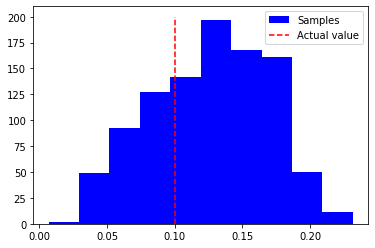

In [27]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

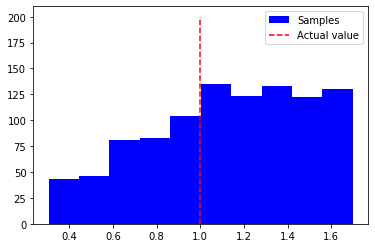

In [28]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

In [33]:
res_adaptive = np.array(samples)

In [35]:
print(res_adaptive.tolist())

[[0.08534276301701305, 0.7829719435480677], [0.12249706920708486, 1.0070866888079975], [0.14810247690626505, 1.4786146856287994], [0.07399457602979864, 0.693642847498172], [0.13705874410217267, 1.4238811617808698], [0.09705498050939254, 0.9007453897251363], [0.15466780467111996, 1.242850884404623], [0.1306398433124371, 1.218014949670333], [0.1286793463617989, 1.114065257990986], [0.11698558468969605, 1.058754056887573], [0.17596451844681488, 1.4730025048045559], [0.1549889913671384, 1.3807839987524118], [0.16458490017034538, 1.3064449078651554], [0.1029214784828561, 0.7915127213131955], [0.1468913971516413, 1.1872594165311183], [0.13321883803053935, 1.0288950635367538], [0.17814754752587675, 1.5916384196825168], [0.12029389770466578, 1.079398773217215], [0.12760438546728484, 1.2344582452689745], [0.15397376911239657, 1.3349481472701035], [0.17380134666270308, 1.494441649197404], [0.18037438427425564, 1.622025548794043], [0.06541345116953057, 0.48465163420165785], [0.12137330238406215, 

In [75]:
samples_adaptive_pmc = [[0.08534276301701305, 0.7829719435480677], [0.12249706920708486, 1.0070866888079975], [0.14810247690626505, 1.4786146856287994], [0.07399457602979864, 0.693642847498172], [0.13705874410217267, 1.4238811617808698], [0.09705498050939254, 0.9007453897251363], [0.15466780467111996, 1.242850884404623], [0.1306398433124371, 1.218014949670333], [0.1286793463617989, 1.114065257990986], [0.11698558468969605, 1.058754056887573], [0.17596451844681488, 1.4730025048045559], [0.1549889913671384, 1.3807839987524118], [0.16458490017034538, 1.3064449078651554], [0.1029214784828561, 0.7915127213131955], [0.1468913971516413, 1.1872594165311183], [0.13321883803053935, 1.0288950635367538], [0.17814754752587675, 1.5916384196825168], [0.12029389770466578, 1.079398773217215], [0.12760438546728484, 1.2344582452689745], [0.15397376911239657, 1.3349481472701035], [0.17380134666270308, 1.494441649197404], [0.18037438427425564, 1.622025548794043], [0.06541345116953057, 0.48465163420165785], [0.12137330238406215, 1.183115751417003], [0.07010805370528142, 0.5960559165398681], [0.09814092049570802, 0.9519280190237565], [0.03804554473189237, 0.4009072763215639], [0.1533385694235525, 1.3671701040943034], [0.13136732626074865, 1.0835808313114619], [0.116474925493013, 1.1531970455996263], [0.0504924862633605, 0.44854824139006955], [0.058764699732781984, 0.5825443883973211], [0.13405632823080688, 1.0992113943788286], [0.13790530450407354, 1.0436515672211575], [0.16152987155614104, 1.5573770419537458], [0.07135947422593936, 0.47447746921394196], [0.13226312375812882, 1.2500945218944233], [0.03658833280321785, 0.3087808163184352], [0.11683681485799718, 1.2841729548383012], [0.12629988846142925, 1.0128670463688887], [0.1296473321613796, 1.052417216139169], [0.07564711278398556, 0.7011141538872159], [0.12043744698737902, 1.0593717391630986], [0.14205081437370287, 1.2920321494764822], [0.17027598589065246, 1.3998445491102531], [0.08477911999490917, 0.7405471885120434], [0.1510062825223346, 1.3185897698908635], [0.0725110629299529, 0.712649319929127], [0.17486793177767673, 1.5066669298126758], [0.06022694015467206, 0.5267840763981397], [0.20400681597815695, 1.658432210219742], [0.07915091697461728, 0.564284661548822], [0.09119737166742949, 0.708105001318981], [0.14111360968721637, 1.2910658013466279], [0.19826440250104813, 1.6811967940317556], [0.1552768177570834, 1.307359729997619], [0.15964089360584105, 1.653621762079922], [0.1925918574629238, 1.6784002988502655], [0.051977978855209286, 0.42941801782529304], [0.14763879052323126, 1.3417887488193943], [0.15370461443069025, 1.5775584925481843], [0.08964737131859583, 0.7662647995381648], [0.1503613548341538, 1.1598878530353156], [0.12521467469708766, 0.9145761539528744], [0.20316538929180838, 1.6884422446251401], [0.12189090524896437, 1.1123302756116642], [0.15028705135539658, 1.3447750864896701], [0.05609670318559249, 0.6593805056218593], [0.17496883286083406, 1.4317526260914444], [0.184836584225744, 1.4526763434380698], [0.17120878906016068, 1.419455393776677], [0.1627780169657995, 1.4724016914139793], [0.07810333835936151, 0.6610939045133268], [0.11754912180864818, 1.2421538465590096], [0.1894802898472617, 1.521296567818759], [0.20391203706299282, 1.512813202162456], [0.12475026174628154, 1.0656022049986054], [0.0985108222347515, 0.9767187822058718], [0.23158951318877494, 1.6659935814525184], [0.06069304011573549, 0.40991971799818416], [0.15665750962836097, 1.3492430060834524], [0.18451089269563603, 1.6721981811798898], [0.13903010388025866, 1.4055670621832284], [0.056702096072586985, 0.5378293714421021], [0.11952774787504936, 1.1840170890843404], [0.07539025659966223, 0.7942740217919284], [0.06939672706509503, 0.6437739135410814], [0.09395803667002686, 0.7794363295813651], [0.17442160394343148, 1.379497698947753], [0.036498013077703076, 0.37120684089502753], [0.07311042090699371, 0.6616439257868522], [0.16968577225691756, 1.374525284521168], [0.09173859451044787, 0.7454356428554718], [0.07717339411983214, 0.7198494062261439], [0.1913782668925476, 1.6123829699013046], [0.14861053721441878, 1.2499597270893115], [0.14359061372130855, 1.3656089478123126], [0.17908386413641192, 1.5475503788455407], [0.15368787547968987, 1.3488911158856012], [0.06889742963229144, 0.57837432101746], [0.08468839742649872, 0.7106329025527666], [0.13463621398795614, 1.332472647833773], [0.0935072890348457, 0.8488877487910436], [0.153909493482867, 1.2051024955385545], [0.11638637886650398, 1.2127644084764575], [0.1793641477153573, 1.406026822348575], [0.05586337435533806, 0.535891270804446], [0.15669342329478075, 1.560696361401949], [0.1724824393099078, 1.6260575434561524], [0.17596353593654906, 1.6010803230742416], [0.17046257203995166, 1.421317478867825], [0.1406131413316874, 1.2780831923731761], [0.09940307938314555, 0.9356823253993997], [0.16209388145014292, 1.496770243154309], [0.11930094688341679, 0.9187113812099618], [0.12761924465599853, 1.106943728772152], [0.21499167099870037, 1.4846815888227138], [0.12503167177783955, 1.343811535490553], [0.1146132437910865, 1.1200644453944903], [0.08981727781972237, 0.8068945135251138], [0.17573048866846602, 1.4898097862339061], [0.15331163005772036, 1.2567389224640504], [0.19610036716543602, 1.5303876855362792], [0.18305286456432984, 1.3118896543633052], [0.05867944862082004, 0.4865087495849939], [0.0963621827751425, 0.8950856600981855], [0.09789457562782045, 0.9617954178020625], [0.1340197535916241, 1.0250256214890185], [0.07844665451355134, 0.9415611723914681], [0.17652920801371258, 1.5813505305104438], [0.14190657534521267, 1.2707188898426733], [0.07526828188479408, 0.6191607165089454], [0.1695230126469835, 1.4371319297993144], [0.14446654705940914, 1.2251436899968242], [0.1729120753836882, 1.6240459332287198], [0.0576074257118669, 0.5350385446115536], [0.14181693692979827, 1.48886947558659], [0.1544288669159997, 1.2950590485661913], [0.06502156347948632, 0.7214536810719465], [0.203095427646218, 1.6813802406609182], [0.1760230922901419, 1.6350159284738748], [0.16045970626277675, 1.407948127133655], [0.11869692974394848, 1.0727275236313194], [0.15801829352761612, 1.492258093257264], [0.18220768645792051, 1.6959296974885363], [0.09816609462873048, 0.8423950715169645], [0.16445659192129095, 1.5962195928196907], [0.09737574972201532, 0.8088470029854674], [0.03463897318244413, 0.4148456299613526], [0.13594391202395878, 1.2555299112215015], [0.18173568430909282, 1.6542505839518564], [0.13253746819013631, 1.2777991367515056], [0.09869114607007481, 0.9925052832572832], [0.13448367162400338, 1.3784338832794485], [0.19584283779561812, 1.6948174717318745], [0.047422061282007474, 0.41781179839688876], [0.12630633638899993, 1.1016687190692622], [0.06564969677218382, 0.6470803640181241], [0.10092445620865219, 1.0379187674006793], [0.09556440166282236, 0.8788795567355244], [0.13361186966851735, 1.3282125620421168], [0.07792356584567586, 0.7206454376350775], [0.1929928456610878, 1.669437782473047], [0.16217444784523838, 1.3094150264796476], [0.15243505657962353, 1.2738154621360205], [0.19368943543942488, 1.5490474157016223], [0.183707583604341, 1.459870721894725], [0.14800977395025497, 1.1150671009933442], [0.10992256040533871, 0.9062553277131684], [0.1525606856352498, 1.45229832862845], [0.05015022446396414, 0.399079745664893], [0.12702086755067998, 1.3217760001899097], [0.14946806503876042, 1.1998857702419885], [0.10758358314087058, 1.078704827479865], [0.18711197370384752, 1.587109524902313], [0.13319993886361317, 1.092403994800904], [0.09835580897970238, 0.787378960563164], [0.11587752435907002, 0.8899387527439254], [0.047810155567979504, 0.5447328492229107], [0.052855704120619414, 0.45737932035733675], [0.09181656180307209, 0.7811127106047908], [0.1459280770446109, 1.3341669994906433], [0.1971420754110504, 1.6384303166132508], [0.1286779763342351, 1.0971834127245446], [0.10516131982944074, 0.8294061443778578], [0.08358177379069279, 0.5996714370064486], [0.1061918698864681, 1.0345176136876033], [0.1512092657022106, 1.2206467085416168], [0.1374386480434769, 1.0915329534493865], [0.12855479630930194, 1.3137576206862065], [0.161080970297063, 1.4333576843321822], [0.13483546819890754, 1.1696089349030407], [0.16489383226795643, 1.4247514414266975], [0.14750156385833355, 1.3198785775443596], [0.12669214917922564, 1.1291013634207359], [0.1499565543590259, 1.6033256350434177], [0.14710273036903865, 1.2523734634317907], [0.14049098201224847, 1.2809638554758718], [0.17989246740901557, 1.5919101894505867], [0.15285961968556033, 1.3492729835478623], [0.14837820629062487, 1.5473691340575777], [0.1907753596226753, 1.4950268771872257], [0.12872992411151346, 1.078413212768754], [0.11003277208199896, 1.0381364737125216], [0.12331383820326758, 1.1204974962450327], [0.16626089538980982, 1.517867309708054], [0.1410022370131859, 1.0966547878112127], [0.12099497108804208, 1.045010868776745], [0.13000116883541063, 1.0385804300666777], [0.08438120445455166, 0.8392201774195417], [0.10640734174959746, 0.9698248192518895], [0.13903155068078166, 1.2944363765799936], [0.16962801134396874, 1.422122547003024], [0.10984981719317928, 1.1427103062125066], [0.18562480795142333, 1.5601893721890694], [0.12920943220034217, 0.9833200589119949], [0.13804972141934266, 1.387292974028928], [0.1186190547549631, 1.1657093325913312], [0.10838373919219699, 1.041502198308818], [0.04603475941958354, 0.4083542218186083], [0.1411063257964855, 1.1082620690922638], [0.1415783362297523, 1.2771907259309732], [0.16841635746303302, 1.4659016848631437], [0.1781219544466266, 1.6429314908084522], [0.05816221661973276, 0.5795409175798978], [0.13897943818290176, 1.2731083519769704], [0.150943238189668, 1.5004869708055177], [0.16821222476442538, 1.4674690197640157], [0.05571284511333095, 0.480025379034575], [0.1618572015690646, 1.4128235241306475], [0.12674336925342133, 0.9979515219463835], [0.11107158907076473, 1.1879063808279464], [0.13271278840824977, 1.1879189863279036], [0.170185931656928, 1.5387832839993054], [0.09309513853642032, 0.8071425399131429], [0.12248711392574861, 1.2198865484356922], [0.11361605742945556, 1.0738770105916169], [0.06257938083302687, 0.5590208201000888], [0.08223395918412982, 0.6371146573540816], [0.1536290715989714, 1.1134452929134515], [0.1793526564037635, 1.5654818667636492], [0.09630230555826791, 0.8776482560383221], [0.04443364711450351, 0.31660472167434517], [0.08767329031383314, 0.7060642751236375], [0.16802455783678477, 1.3152398368991285], [0.10790164487217382, 1.0298885468764738], [0.17571751768770594, 1.5361989565269003], [0.18021551609566014, 1.594320184705855], [0.16224961759507134, 1.4973658205556721], [0.08956539820772219, 0.7229050874130435], [0.12183185273115328, 0.9939836044135992], [0.07244693622264912, 0.6266598189595486], [0.16167611083751318, 1.3471050232738548], [0.12229942871234539, 1.056524155795738], [0.16313176805544272, 1.4659498617544462], [0.09807437071808492, 0.9389769433316096], [0.10118586417881725, 0.9702736222046149], [0.09298574845653099, 0.922109099163936], [0.16021296535737958, 1.554072171462566], [0.17342462287966065, 1.2964735044257998], [0.09582709552610955, 0.8970476925834069], [0.1442753525539667, 1.4088397732776619], [0.17457855497390484, 1.5469573260638343], [0.06535372209354769, 0.6577241031678922], [0.1681073453645343, 1.4064738030590709], [0.14196026281966084, 1.4208467901869948], [0.1699474837650864, 1.56207164622802], [0.06297265543638618, 0.6612814196550716], [0.17029973398356937, 1.696370161812826], [0.04691356898666401, 0.4217759490026164], [0.1389826144302221, 1.4845812198253152], [0.09141099921433392, 0.9537841772374805], [0.11327162461732959, 1.228005137195604], [0.16914348787044833, 1.6599453554630954], [0.08943666839977722, 0.6570638103676002], [0.1874448286071609, 1.6240553477226176], [0.12537517380329843, 1.329330795455049], [0.13143488168715162, 1.2051298472395122], [0.05603962382591429, 0.5444840746208568], [0.16689673142227684, 1.5625409628876785], [0.1529788428582175, 1.5614844032426154], [0.20189452341360542, 1.663974845218261], [0.18640237764352455, 1.6884239802642105], [0.15081430229640305, 1.4152437272834966], [0.07569184901927296, 0.512254109714023], [0.16302856844729166, 1.2450267740292837], [0.13934470647081043, 1.0717099460103225], [0.12233621489421068, 1.056059065702295], [0.04259288400539848, 0.49698249283379275], [0.14109736385073185, 1.2597661475953106], [0.10722912516602665, 0.8969721608880792], [0.13427932257453062, 1.2010678662188312], [0.11110301016510554, 1.0196348357685836], [0.04421646792972328, 0.334358733106609], [0.05084906077556513, 0.4614225881160809], [0.13929761976195995, 1.357946942467594], [0.049750439497262766, 0.5045032836497937], [0.1242984791259053, 1.3301015810699117], [0.08487640212824683, 0.6280266456028925], [0.15511967227237342, 1.3283698524038368], [0.1898271487969151, 1.6395695828521757], [0.1682938375427452, 1.3505656384194455], [0.16153296483265192, 1.5152242194319112], [0.2110009106075257, 1.6474063859095422], [0.06720903173912468, 0.6563984456405532], [0.17995369636516506, 1.6299803700359026], [0.12844917536136108, 1.1921034565610293], [0.09061344009069189, 0.8272328801715024], [0.19486831815046957, 1.600045959112977], [0.11617793205245458, 1.033428322134931], [0.1647925746823446, 1.6634191426758007], [0.09789452297831061, 0.8905639171133195], [0.13228632278355928, 1.1704608369776115], [0.1697178557812437, 1.6171073753241316], [0.11823966812197546, 1.197023795616151], [0.16570470670118426, 1.5845922067581482], [0.09507959407157193, 0.905768372580821], [0.17334097876219046, 1.5279158648005853], [0.12994901474290532, 1.2210807620588486], [0.12781882357780092, 1.0537176566979278], [0.07076725560597763, 0.6110626911196375], [0.1376387288778157, 1.3633757836756564], [0.14896247648574118, 1.2742603814526756], [0.16735098610825322, 1.6159282101249097], [0.18834266337848765, 1.6562618474394206], [0.09353346903853735, 0.8380539737615094], [0.09224329919633406, 0.9179258978112748], [0.05714996827196547, 0.585677425963514], [0.12254672366815494, 1.0865896927393237], [0.15949001753298458, 1.5616127550608345], [0.1665865473922041, 1.4685062468520171], [0.18770745423094773, 1.5894704534036292], [0.16906672033807768, 1.6492078934014516], [0.1327967740926227, 1.1144274180961644], [0.14866672687475554, 1.450604325540688], [0.15053388799184095, 1.2382424178663907], [0.04266635942392653, 0.35826434391841294], [0.09755809595736514, 0.8594527054945204], [0.058112711013763044, 0.504206565446746], [0.09211453685629702, 0.7605952941826088], [0.12383104750828183, 1.2774391270440828], [0.11414252454135775, 1.1681348140631633], [0.0631485621760565, 0.67035048451204], [0.12922493079312072, 1.188212956504419], [0.13327141804235165, 1.3951463719747421], [0.04818317761738002, 0.4294930655632065], [0.158352043711436, 1.5122583501177527], [0.1294605985180828, 1.3209384795391816], [0.1656406564530273, 1.5738551020572917], [0.17666942835432478, 1.5403844470987353], [0.04834829447392572, 0.3144752625327769], [0.134413610158192, 1.2070791581265032], [0.1122039527777056, 1.164118952372941], [0.1471208154970447, 1.3299759505481377], [0.20556015929988225, 1.6670763809070352], [0.12473914702718165, 1.088562706722171], [0.18929331742742045, 1.6319438961283168], [0.14210156105855568, 1.4023883833871342], [0.19540149090027337, 1.4638978771658655], [0.05996321809435953, 0.4991012748587768], [0.09538854643677314, 0.788478553704383], [0.06019939820220958, 0.4848863060751094], [0.07096854475139606, 0.6733186276486319], [0.12753500617571578, 1.2225358400452415], [0.0515341195113625, 0.41380675282838253], [0.07836847864773228, 0.8384027530642304], [0.16004892159306972, 1.3837466417442494], [0.17469878144889323, 1.4192086364971255], [0.032743635318507006, 0.3096323308974708], [0.09059237424718744, 0.8511625098848922], [0.1898742923539221, 1.6687531837390899], [0.07671293527919451, 0.7493148678085715], [0.0730336827209611, 0.6382782542153409], [0.12725406901149508, 1.0409932319296138], [0.13277069635677607, 1.3994452279867218], [0.13632513979941885, 1.0810669878075032], [0.1536956875166341, 1.6229873050260193], [0.0835134531584613, 0.7369846653647785], [0.13030084822940435, 1.0689447447652238], [0.16826614273648036, 1.5211508915383516], [0.08469038222594945, 0.6739113492623505], [0.14842791735298125, 1.3168178578970549], [0.07934292609362209, 0.7087060183052619], [0.08309063709662837, 0.7270015125001936], [0.03673780500079278, 0.3261922864031066], [0.12086164767930124, 1.095394791457636], [0.05348844501397411, 0.4834947240482737], [0.09118367897035376, 0.8109466002953171], [0.0886196615974077, 0.77186174850896], [0.13545417407395471, 1.2467079495223001], [0.15727064051514505, 1.3577918398839022], [0.11327904852672996, 1.1263629182554324], [0.13893360950616582, 1.1511370986056673], [0.17469571850056262, 1.5488581798853436], [0.15902648987337514, 1.5435743504946056], [0.08662209347312802, 0.7649148075271242], [0.09943664502347219, 0.982324046082046], [0.05774107033808755, 0.5365748965099668], [0.12072440955760178, 1.1924353714260867], [0.14267064755115677, 1.6358183143643226], [0.12706972148652018, 1.1170177685378926], [0.1605106315998668, 1.502619572079983], [0.13906178383348056, 1.173431823771027], [0.12384545038032486, 1.1064593469178112], [0.15769790069552647, 1.417788472648267], [0.18878041751095911, 1.406214447487696], [0.06723576146952819, 0.6825407748576724], [0.03965851270332836, 0.3299025914380025], [0.09867764100568645, 0.832842020529259], [0.15854256316647028, 1.4812648024163861], [0.07747699682202892, 0.6114916909890905], [0.07549766741501726, 0.8219914507124918], [0.12897244593989535, 1.1107113411643685], [0.148404566822864, 1.5235748418282242], [0.12971462368232847, 1.0278386513775695], [0.08309111001813602, 0.7386028407893452], [0.1559220140411896, 1.6676344312352822], [0.1454693965546543, 1.24851422818317], [0.06376543523952088, 0.6597440099035449], [0.12111273775452674, 1.0831229758700767], [0.18153389087120927, 1.654328720106628], [0.10398912729194094, 1.016428332495656], [0.056909839854233216, 0.4758759537021323], [0.16016188725007133, 1.3766007182698772], [0.13658637052259898, 1.4046879692264516], [0.15494047004537442, 1.2221365411618013], [0.1648419790323552, 1.3950860482887106], [0.07395723657146049, 0.7837370924706593], [0.18798698432478558, 1.6205031142102828], [0.08865594169406235, 0.7644652195195794], [0.1410849902007259, 1.1266602349179708], [0.1039547504086871, 0.8433449104309709], [0.15580532635040048, 1.5033637736646677], [0.13876178612326834, 1.2175515118585865], [0.13868671114054595, 1.2617638559523305], [0.1719860779215715, 1.6001475744142535], [0.03858278823996681, 0.335172982813293], [0.05857945606097119, 0.6166304266618594], [0.09247069558056109, 0.935805031282521], [0.14427780601824525, 1.1893276108009943], [0.10709068941840298, 1.1120640759072455], [0.1822172156972841, 1.4961955882565419], [0.1276209995219519, 1.1093496407063372], [0.16998144823457656, 1.5635479529926477], [0.11287877984303915, 0.9662610047746037], [0.1190041623827663, 1.0634901211149395], [0.10782852812945555, 1.068416827077958], [0.18237499597292503, 1.4460397493490296], [0.10765370961971182, 0.8634734854304216], [0.12590564983678254, 1.125259643903299], [0.09977212267514303, 0.88139180945941], [0.04175121554024965, 0.39699765431497225], [0.16594728593824654, 1.308775459675218], [0.15457046224298518, 1.27516243402173], [0.06817215972358046, 0.7030031114862666], [0.17320174328274918, 1.5330744962483478], [0.19193384708033293, 1.5513378410941296], [0.1022192988304439, 1.04966609377945], [0.15883102693762624, 1.301546154532904], [0.09987521374508132, 0.9409652455300195], [0.08390977414714033, 0.7848364864888849], [0.1256175359952282, 0.9332589967811098], [0.17074767488967527, 1.5063265961437597], [0.1776935051729827, 1.5966479661617075], [0.18082779867261314, 1.4809389740451577], [0.14295710413547927, 1.269594734966593], [0.09200030586465391, 0.8956083243067996], [0.11582095808465083, 1.0295145173087668], [0.15017779190657624, 1.4960503811621166], [0.17105692088821584, 1.3958374647673042], [0.130509430695109, 1.1250297194096692], [0.17244577988632637, 1.3877771034373945], [0.16669013830838425, 1.4090555967840697], [0.16952516829640982, 1.3957500744789546], [0.12471246407097138, 1.1598136074791143], [0.13019032008073173, 1.2176253748417574], [0.15982859232593644, 1.3844515228443384], [0.15133135923695962, 1.3126896721100896], [0.13111353932586584, 1.2529014484039553], [0.12478513904909788, 1.206544533273037], [0.15162617232732067, 1.2784871532110924], [0.14269297182977844, 1.24893459487836], [0.11823410787385934, 1.057416135803725], [0.049438459355460054, 0.4666292377273395], [0.08809225518073147, 0.7817860319471754], [0.1499038995279877, 1.249149604329231], [0.1754151185944068, 1.4718109244842694], [0.10325991696434318, 0.9677272444634738], [0.17326364334319078, 1.625748126663046], [0.17255617514025537, 1.4519607189925101], [0.097756979188304, 0.8340567287324252], [0.1499919418893767, 1.3511368308736724], [0.06845546570923233, 0.6239779357873668], [0.09242392515648282, 0.9720766708873395], [0.10989832899043832, 0.8731524693825966], [0.0443106338650699, 0.34732998911606394], [0.17448010850063142, 1.4540514656589214], [0.08887190975328634, 0.7347858276900336], [0.18490474387193848, 1.5309762787128087], [0.184463098833475, 1.602142414714295], [0.03766370306103445, 0.3428921158515238], [0.16268497131575166, 1.6556873767378222], [0.11389821981189763, 1.2108408405990019], [0.06488624194215456, 0.542069103469977], [0.13923489017515725, 1.4043418684622635], [0.058709973256282855, 0.4742046202661278], [0.09861112792227443, 0.8758948010694254], [0.1603725806927609, 1.508877155900799], [0.031375572731830975, 0.348132708580305], [0.14454706362426528, 1.4457622522398257], [0.09547982546494764, 0.9457280960292092], [0.0667694063466703, 0.5828484280965675], [0.06495352284831979, 0.6778967403380323], [0.16938939837149602, 1.6239734277031193], [0.16562812379371616, 1.410248115018911], [0.09048209666347444, 0.8385186922135576], [0.11628670544179856, 1.0571401433209116], [0.13808391807738968, 1.2296809108501328], [0.15162880029795128, 1.4886058871267054], [0.15664483179527644, 1.3533214852055946], [0.06524190290665713, 0.6077975485565363], [0.061503621221301416, 0.5947495134733596], [0.12169208407007609, 1.3257473002071003], [0.16841312711113177, 1.5201924372660742], [0.10871628375841626, 1.0690010647928552], [0.04093637334586331, 0.34009095890702024], [0.14094870104511442, 1.156784229167828], [0.05034640891010178, 0.5130114190476944], [0.08918113163682813, 0.8845973508443925], [0.15344934638178961, 1.3892571368977862], [0.15486802632872532, 1.6403106402315482], [0.1373415187386094, 1.2711890436674036], [0.0760612770938574, 0.7162617986561981], [0.07943809668178968, 0.7666315579972487], [0.13670648658268703, 1.2951506690652967], [0.1374858690300257, 1.4661160560664452], [0.11481917010409519, 0.8698538317518436], [0.14437389047785046, 1.2622577537533233], [0.16178977365253094, 1.6572349663698576], [0.09250413800647006, 0.9426074075226877], [0.09633282285456152, 1.0326400481467692], [0.10934879869140779, 1.1262086075748963], [0.17414075864008388, 1.4677805871971628], [0.13165516989113643, 1.3747395013098598], [0.113036567900854, 1.000205691441164], [0.1840765886781502, 1.5753953047688216], [0.10670698785312403, 1.07718134930318], [0.15967760885864052, 1.2801406786773422], [0.08648584906864881, 0.8447310439242552], [0.13636105484264976, 1.3211632383348748], [0.061567893628863266, 0.6299114748824741], [0.09567709678789825, 0.8840528774153138], [0.19242938461779013, 1.6540629745612883], [0.10040751922555324, 0.8196363417891536], [0.1632538529441838, 1.3872282332387331], [0.09998441642495556, 0.9403537614985567], [0.14120856501725706, 1.4773621524931437], [0.10362405989124615, 0.9403701873451803], [0.1534512993719753, 1.3483942209613464], [0.13569338294967992, 1.1763225019630164], [0.15446627393626644, 1.5065103078967208], [0.16688157544005155, 1.3915893979838574], [0.07411498526995275, 0.69806073490271], [0.1565097607241106, 1.3713764563047486], [0.07394884316175179, 0.6454462428699603], [0.1155342309607518, 0.921841752688319], [0.11846498426048743, 1.1000476032913538], [0.08213110877674656, 0.7330549559471881], [0.10837529645024348, 0.8726519583621772], [0.1685344741856623, 1.2739048288330508], [0.12409313588461555, 1.0993227871062174], [0.1782223279553254, 1.536913283044872], [0.10341956235806714, 0.9173051068038354], [0.1747197690444159, 1.662633989652448], [0.07542201044619615, 0.6851921511354451], [0.11146396722130204, 1.0252884689189752], [0.08700521033111056, 0.8115336489029727], [0.09886313552622052, 0.94663549131178], [0.1452895636713864, 1.327822822866216], [0.13282811699742358, 1.2831110223223783], [0.056196957723951856, 0.3864374033451418], [0.12400906117307196, 1.3149896429191954], [0.0872656344947392, 0.7371995652852593], [0.15252709140676735, 1.4596575349678726], [0.15194674749869025, 1.5318382201113616], [0.17136265042445464, 1.639161947859393], [0.11027005111563323, 0.9016767910538036], [0.1658803248373767, 1.4161502752083588], [0.09154920410627773, 0.8164884205329073], [0.17651555291173987, 1.384347452912445], [0.12289658363032427, 1.080905758359398], [0.1115201568668603, 1.0399076907714786], [0.14714863343794726, 1.1724411489518145], [0.07214931685473924, 0.6753485919916911], [0.08109199618593868, 0.7802922339120821], [0.09737611690004343, 0.8153369044945495], [0.10698395935645545, 0.9980046075781493], [0.1591778115526596, 1.3721605000121118], [0.11180209497767658, 0.9972800177928263], [0.18584920935686217, 1.6808699075228781], [0.1829927207829782, 1.4526047150754569], [0.13945731782207327, 1.3163117979312196], [0.11291416039790021, 1.0138064670574438], [0.12883699836492984, 1.076960064816428], [0.19483548193594613, 1.5456595919029665], [0.07780674076624669, 0.6594976187468262], [0.0706806669351855, 0.6210445829934134], [0.08617893886219241, 0.7651025756039328], [0.14924287842658887, 1.5984134010072895], [0.1295442727587679, 1.247036363681697], [0.09602978140857879, 0.8705432168775358], [0.13614076444359274, 1.1139965461424755], [0.06532210885748954, 0.6017718269847772], [0.05443511062861675, 0.500968814954214], [0.08122877898792744, 0.7469967877020008], [0.053341513013879106, 0.531788476366705], [0.049155720121163385, 0.38709785862954116], [0.13610573131403203, 1.234432325350871], [0.150617492853899, 1.1679528837434558], [0.10628166172840442, 0.8904667042924981], [0.17806488624928726, 1.470729348654877], [0.18654973040417475, 1.6866448450541591], [0.09226299722426153, 0.9568401101619496], [0.18360817747540198, 1.6370699637909585], [0.14524402769405095, 1.3726464224061963], [0.1859827806706953, 1.6631328454843244], [0.13401172357826968, 0.9177105854400703], [0.18560864314356212, 1.5948815098189058], [0.17116841370004893, 1.3150985219145563], [0.0946206171625099, 0.9083432348643844], [0.18101615900396886, 1.600841581616697], [0.20988718921787525, 1.642058386382722], [0.14775245135006096, 1.2433315581846878], [0.06355390067836558, 0.55171987966473], [0.17414229089688027, 1.4690226548550116], [0.1825119774937619, 1.6311967758583918], [0.07787514377894958, 0.6471829435373245], [0.10247604135316335, 1.0131215767975583], [0.14788874262003918, 1.2494597198566832], [0.20332762648321767, 1.6959528942893727], [0.13756728922590097, 1.5841242630104735], [0.17699719910487538, 1.5408472426891642], [0.19183467503312843, 1.429723860981839], [0.1210135196412215, 1.0253159615527045], [0.10312824982100399, 1.0813814940435125], [0.18832776544853871, 1.5691085024218083], [0.17568971112383475, 1.5429713002467542], [0.11109382194556384, 0.8943424283339837], [0.1845436882097177, 1.6941682706813976], [0.13897759353905637, 1.2240867984705306], [0.11598866739334497, 1.088702437171134], [0.0732574528262135, 0.7042990536835614], [0.1814359559260646, 1.6157563505339478], [0.18493970652102548, 1.4945331753553552], [0.12544318626358428, 1.1810079047787596], [0.18768245896115054, 1.5172385500117096], [0.13490235324453023, 1.1393596465918612], [0.09939016712464978, 1.0032237100338566], [0.17036528035845608, 1.6366722697290879], [0.11063491845682678, 0.8923700272483532], [0.16091788095114445, 1.5488774748697667], [0.1413233129622153, 1.3320001413557812], [0.19102977913342145, 1.5785525904959543], [0.16715034331342032, 1.362259207285328], [0.08492199602393859, 0.7627523523053347], [0.15010289679449101, 1.4702426645990525], [0.07793301353007306, 0.6701295776756577], [0.12461989370769358, 1.2449191185397792], [0.12475873031644373, 0.9433579356837407], [0.09735205114451254, 0.8806246983874501], [0.11713375406925883, 1.2233585166699408], [0.17815518584702295, 1.6689712452727932], [0.10357988166071219, 0.9084900970989409], [0.154019810658112, 1.3115922980094386], [0.1512776889954844, 1.4115810251498733], [0.12777419695794812, 1.2512216176976731], [0.0514496567272331, 0.520846094575109], [0.04832985870906799, 0.36505584704359695], [0.0678407179604698, 0.6639483667522154], [0.13051386467296866, 1.0734458158318707], [0.036146479993494005, 0.3049104261069433], [0.12564402537487782, 1.3100684659729083], [0.15928067549926772, 1.376637997452282], [0.0683246205165191, 0.6255704812822335], [0.11116104222652358, 1.1030704243920264], [0.16118468330261135, 1.6110829814193148], [0.11050918637214903, 0.9779077353683555], [0.16364511932317008, 1.412248518949667], [0.1695616988400659, 1.407663093695285], [0.12282509529064085, 1.137776066209622], [0.06627813216957076, 0.6068727076543283], [0.17048758654114718, 1.3576497916598118], [0.12256896543111688, 1.0198283363504441], [0.17859253611741252, 1.5942851508803928], [0.16655372570445998, 1.443889665925675], [0.11375727131952196, 0.7723415928863858], [0.11939862266837006, 1.0452778277566674], [0.13471701288214605, 1.1248574253423431], [0.05838337949242654, 0.6333877723315282], [0.19339955499010375, 1.6800634662733658], [0.21680020209823236, 1.6248830816947555], [0.1745462868922169, 1.5973398166019566], [0.12519456738123477, 1.1805823807440137], [0.07905916803978655, 0.8192082884093703], [0.18690028042406603, 1.5750708486417697], [0.093353238593733, 0.8448559772567492], [0.18858779029015976, 1.5213886042085265], [0.1320699238831522, 1.2727603383607282], [0.0966746176552149, 0.9027907989497675], [0.14637733172173512, 1.2331463380594188], [0.06785559423928551, 0.6557561071311977], [0.03266450798110465, 0.3135437647547855], [0.13152724941387517, 1.1027684544512866], [0.03175955503679889, 0.3932335499701657], [0.11662968098862335, 1.1453881755860476], [0.17748433304695452, 1.5186211259116136], [0.10323310261706398, 0.873672718486929], [0.0682055474325178, 0.6515382545951194], [0.1968012191436969, 1.508849197517013], [0.11484608351364325, 0.9901597799998625], [0.04678689301158894, 0.42715193499178067], [0.054976286355174944, 0.5822828923396078], [0.1470595750956473, 1.2931916216792938], [0.18198628358822305, 1.6945374203974288], [0.07823984590015845, 0.7846992297811664], [0.15051966207400092, 1.682971288199337], [0.17200273352278317, 1.5969882698523068], [0.1604609214967464, 1.5548941610140488], [0.1417721717843474, 1.1396847899748734], [0.12041058198183248, 1.1167788942614774], [0.09321878441918925, 0.889380481395792], [0.1732056331616213, 1.3739378917717877], [0.12233133693190724, 1.3517188913202869], [0.13264054474402284, 1.1840437837729292], [0.039393502527306785, 0.341634170198857], [0.060601494574032605, 0.5354726746555393], [0.21112786860128735, 1.6623351478996868], [0.06062853567682473, 0.5097037047080701], [0.17914827623340412, 1.531653357962716], [0.11590574490926689, 1.053553051792147], [0.13203605901037468, 1.3797464457327664], [0.09726650683622623, 0.9673931856108261], [0.0765640676505894, 0.6435030997689988], [0.11922874771431466, 1.133996116710422], [0.11130341068680814, 1.0726235683409913], [0.054994386624381185, 0.49858137906942557], [0.10458873248401548, 0.9118007714006887], [0.10650952461521526, 0.9044224438767825], [0.17013411196128314, 1.2120592735824867], [0.10372263614398264, 0.9380710627077069], [0.16715263961132668, 1.637464394280576], [0.11223271493316252, 0.9053951721964335], [0.14572096367393816, 1.5027883806251328], [0.08446664376283283, 0.7582027850204145], [0.1520773482353324, 1.265961791866012], [0.18854637133364588, 1.4652096403364345], [0.15822528880261605, 1.2098495438450463], [0.13939340500908265, 1.4593813023622408], [0.12895521565815188, 1.2547476147803869], [0.13456737087770576, 1.2657469843253828], [0.12550755989085757, 1.1805139646298652], [0.17059728257607037, 1.693161378702963], [0.12776015328055979, 0.9796107095209905], [0.2012276404034693, 1.6833254087410894], [0.15510815756491483, 1.508055259148142], [0.13487699762347052, 1.033455962921676], [0.06013853855884958, 0.598957180432949], [0.04419154204134834, 0.3577869150370844], [0.071439156632361, 0.6316964914136199], [0.12270148777210187, 1.0503374888263448], [0.13139510307254076, 1.18784201176624], [0.15906367881521555, 1.4414297447078919], [0.11932434349596407, 1.1282453466225575], [0.14231675412110806, 1.1093067493463333], [0.12817270662213912, 1.2354236684570568], [0.1550912554881559, 1.4730969663442273], [0.12282782717983745, 1.0745967546979043], [0.15372197671322488, 1.2373040997484979], [0.11678596911942987, 1.1275857035767634], [0.0680777366391507, 0.6507473547320961], [0.16560116059090368, 1.4010266589159972], [0.1599210057404506, 1.4146613859871056], [0.11908504672962102, 1.2887313628635495], [0.060861677071422884, 0.5888705181155021], [0.0965917277568157, 0.8572298026282638], [0.15055158129012347, 1.421480346204424], [0.17657048920395896, 1.5925048003994557], [0.18109180535259906, 1.277562196381416], [0.11632832914432037, 1.1756630812568447], [0.1315358718874186, 1.2570712635149555], [0.05521501140988085, 0.6308164826478342], [0.09991246356111279, 0.7781758781104087], [0.18262134033415323, 1.5939147737599728], [0.12744173558994387, 1.1163042841199367], [0.16217289058030787, 1.6109137661596387], [0.09033790976529507, 0.8544150539705324], [0.11797477784627132, 1.0559937363736547], [0.0943444529100684, 0.8555845399009182], [0.13907695340994, 1.2239788774599851], [0.0776343312808587, 0.7738319125702922], [0.16534913125902354, 1.6911556393758609], [0.13147130582502814, 1.239819610748925], [0.0943637529392414, 0.9222615457884558], [0.16451118935721565, 1.592741443499018], [0.19609004145959424, 1.5860328644212003], [0.07747660107891932, 0.7859787322726941], [0.1765976516851326, 1.5419044162772293], [0.11595967259455708, 1.0524837955157265], [0.08578777728580475, 0.8494370077772153], [0.11821161924510798, 1.0184349234471868], [0.14978410568703493, 1.442386521170609], [0.08308121976823521, 0.8622808957603108], [0.08322631941839159, 0.7151861947325422], [0.09922363719893032, 0.9611762229120058], [0.16548597221425587, 1.5387854933830003], [0.07721995857243419, 0.6026543650362747], [0.11511133666930853, 1.0608110612470054], [0.18472998210963276, 1.634330563338382], [0.13559456203995157, 1.1637878527158851], [0.1586018225031876, 1.3597040606135011], [0.1102624833177435, 0.9858391894880087], [0.04440549770113973, 0.39060768571943655], [0.1351447414701211, 1.4177142344124816], [0.1626465547673695, 1.3646688254548236], [0.12641552631992076, 1.2069923024711664], [0.17938803706862028, 1.6433648353665413], [0.11817033594507659, 1.1371175741766426], [0.04374723282061194, 0.34940183712831757], [0.16532289208004985, 1.4934649013386865], [0.180258958730123, 1.6992256695619932], [0.08117823374871723, 0.6445901429663863], [0.14980112612884544, 1.4474033657630618], [0.08109985884922825, 0.7720383544933351], [0.09748983948946338, 0.8059330485891637], [0.10156291980217381, 0.9633553689568007], [0.0950539901448978, 0.9295835121999876], [0.14634381852376005, 1.3968946020615294], [0.15924455413441754, 1.2058067113894866], [0.1669946017558962, 1.553016548563641], [0.09617855277802209, 0.8679908446970691], [0.17793995496341491, 1.6131604904128216], [0.04404056936534925, 0.35773724092433157], [0.06288996028897656, 0.6131174979326235], [0.11491303388619145, 0.9879751374242891], [0.16421042514363496, 1.3913691064680787], [0.15688711461520605, 1.5423256630757376], [0.07488107796711765, 0.6714820742433121], [0.176605823910653, 1.4741084804746931], [0.062278291384208456, 0.6340718580734199], [0.14327385024405548, 1.2428355330871463], [0.08963509687607622, 0.752870405921612], [0.16663102027162838, 1.3962911658246666], [0.14011620776551165, 1.1569072299193937], [0.18369555397720433, 1.6093026546461553], [0.13187988443917714, 1.2689544517717573], [0.1435277827148477, 1.4109475561863802], [0.17716985796714652, 1.5975727734380447], [0.1903141971279981, 1.57929159606439], [0.11246782701077307, 1.040248671819723], [0.14897271517952465, 1.2961928024158802], [0.1170492682999254, 1.246915689590326], [0.14159222638410998, 1.463690390427583], [0.1482208014006587, 1.2949872372363678], [0.18051520801661533, 1.6881077296560902], [0.1506499562374234, 1.3867632907966596], [0.15446465789478384, 1.5839972363383086], [0.09622579395262609, 0.8586903265662896], [0.12400797400776739, 1.1017210695781736], [0.08498680173876257, 0.7696768131621338], [0.06922251537717974, 0.7007514908877985], [0.16783396177186471, 1.5492687737801853], [0.11702001105767894, 0.9832949855165332], [0.09807374254009069, 0.9303825737404768], [0.06979417396513729, 0.5112454902374737], [0.21104872354653578, 1.6969201431204184], [0.0747023550463327, 0.6987896470241912], [0.11817424019182705, 1.1468957351659097], [0.14739639056948867, 1.224020524863212], [0.1803800156737234, 1.3789778201319869], [0.10623996002801897, 0.9786184781809578], [0.1514322975398657, 1.2754908813117263], [0.11098497332328183, 1.015971177233979], [0.1197506644404917, 1.0020387990608803], [0.13155364784058404, 1.2832076671741577], [0.06393396921992571, 0.5776935290441575], [0.15316781331214457, 1.3656849169691854], [0.15086780421647383, 1.4552004901686997], [0.06752715889101327, 0.607918901530433], [0.12904879887204715, 1.0972000787072067], [0.2125034348179693, 1.5837151971937056], [0.07827598437967866, 0.7733243640365882], [0.14073414427110648, 1.2848983404982353], [0.08989355008107533, 0.817886061477938], [0.06373386620713967, 0.7300441897974782], [0.10342140919925488, 0.8947084309117739], [0.1744770303491182, 1.695282099299725], [0.12533761443102936, 1.2710648587288647], [0.1013408361802645, 0.9829157127537427], [0.13398437797403226, 1.144831509946532], [0.09762394355144233, 0.8258528780587656], [0.12849113503428258, 1.1701029232739781], [0.00673761581966997, 0.4071560064300492], [0.13757619339706845, 0.8922669947002763], [0.12618761460046107, 1.09530012817911], [0.21261109615540133, 1.5262098953622918], [0.03080049224096204, 0.6050651698153195], [0.13342022475451956, 1.6841903007664358], [0.11832473175951154, 1.0267105361765996], [0.0915151699183785, 1.0058850984906784], [0.0719571572884412, 0.8601729164340126], [0.07564010014695782, 1.0288274072282997], [0.2004408671563107, 1.6662611417956545], [0.08315319940415979, 0.3786800181805103], [0.1592939227968348, 1.367233447231298], [0.111795694574908, 1.3611519799870457], [0.08182610907636688, 0.7097164008052729], [0.12522431451267432, 1.0349143986266272], [0.18715454464043801, 1.323498444456079], [0.16563845527340584, 1.5818847274804917], [0.15078599549141625, 1.2104799137737126], [0.0947424387877491, 0.8631491208689791], [0.19614883473725203, 1.50629271923968], [0.03137222515384752, 0.5195422653447361], [0.09738694591323098, 0.8368546119314992], [0.05672073321021448, 0.5508017160160519], [0.15217414432501736, 1.5197309213225438], [0.10787262818396426, 0.922433542835621], [0.10461242653870262, 1.024097172381727], [0.16948709839275955, 1.621104036826989], [0.21470695170192453, 1.4547108161997357], [0.08899684395488153, 0.7561609858394989], [0.05530447466298885, 0.7781847382212742], [0.13149347963535946, 1.1675848007711054], [0.12647497567790583, 1.1132061138708191], [0.11783449502311578, 0.868369879942127], [0.08278443415923398, 0.9815080762658145], [0.15846630243834936, 1.2830811156090005], [0.04142243410779699, 0.35393887223900017], [0.15716016029496208, 1.556139678591383], [0.07314982725312548, 0.8602546296517338], [0.12539033535996044, 1.0988340228962148], [0.0846429957401064, 0.6023094196194692], [0.13696807877131428, 1.1083141621462091], [0.14787734441164924, 1.2841179491979435], [0.13028789155163953, 1.5088288840758646], [0.06543757299120401, 0.6932249233868105], [0.03980530467976322, 0.6720993655804417], [0.06605346010343693, 0.8987258596097001], [0.1880644441398428, 1.4819682692218443], [0.146624858429838, 1.175882721180051], [0.12901989272109893, 1.0957240017946912], [0.12977555945557007, 1.4267481215029], [0.1536813228257397, 1.1314897148282723], [0.1295768466681526, 1.6255911548465594], [0.08263394743634259, 0.8864959039702803], [0.05619006735973857, 0.4114994114147021], [0.13497645832296468, 1.2564545929230686], [0.07709376389795453, 0.6197616420107612], [0.08690498464351337, 0.7345479848893824], [0.12113057916112333, 0.7380792678083252], [0.04094237684545941, 0.611330006851546], [0.15972274455596674, 1.1346687957916441], [0.12102496149590355, 0.9488704849811231], [0.1259017299037687, 0.9586121129801257], [0.17393665905994277, 1.479818838223073], [0.045838137279665514, 0.5647325369484713], [0.14392464233287686, 1.1507086115894958], [0.1838438211719539, 1.437768919649542], [0.0748578045846778, 0.9415373970697041], [0.14516175010011106, 1.111139357952374], [0.09257884672353975, 1.1089486552322867], [0.1674006010399431, 1.2255756394787953], [0.06955322195053941, 1.1012086956893596], [0.10403776171432758, 1.1126550704580531], [0.1901074167262086, 1.638388045712348], [0.05589921206738367, 0.40580977000673685], [0.08271434995479829, 0.8982846478777907], [0.10807197256782872, 0.962688313646443], [0.09737567853558107, 1.0150033200120436], [0.07518302483119603, 0.8857656812324376], [0.2185367034461213, 1.6741902098597197], [0.12594479557140942, 1.356540736727401], [0.17114088896830756, 1.5071626855942521], [0.09713059974266672, 0.7938178570552779], [0.1212070098881036, 0.8644079923593966], [0.18186035175939969, 1.6520179279692182], [0.15202274678689293, 1.1212679670598205], [0.15144845791649458, 1.3866119498434535], [0.1589541333346122, 1.3339900177392816], [0.16566504404092608, 1.3588230524190281], [0.19651777007651966, 1.683078544888997], [0.16600271225807833, 1.1064367168824807], [0.11414927772184523, 0.9458476890844986], [0.0849904512660335, 0.5671280825372178], [0.01050247976569093, 0.35765967778181235], [0.05022662173269747, 0.75960811820158], [0.1866929273617881, 1.0826721813474094], [0.10537776840144639, 0.9546855552163636], [0.13411018618701523, 1.0875405136140446], [0.1720103154784316, 1.3781670209665435]]
print("done")

done


# SGLD Hamiltonian

In [21]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        
        # vals[i] = the i-th datapoint
        # vals[i][j] = the population at time t[j]
        for j in range(len(self._y)):
            for i in range(len(vals)):
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        

        # t_cov[i] = covariance matrix for time i
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
#         print("t_cov=")
#         print(t_cov)
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))


        rez = np.log(rez)
        return rez

In [51]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        self._grads = None
        if (len(theta.shape) > 1):
            dim = len(theta[0])
        else:
            dim = len(theta)
        g = np.zeros(dim)
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(dim)
            for i in range(dim):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
                
            term = (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta
            g += term

        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        # if len(grad_val.shape) > 1:
            # grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [self._theta0]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=2, R=1)
                    ran_term = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                    next_theta = curr_theta + self._eps * np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        print("FAILED")
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            print("FAILED")
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [64]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.15, 0.8])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return model.simulate(theta, times)


abc = HABCsgld(1000, theta0, 5, np.array([0.003, 0.01]), 0.1, log_prior, sim_f, 0.001, y)

print("abc started")        

results = abc.run()

print("abc finished")
print(results)

abc started
t= 1, curr_theta =[0.15773541 0.84488983]
t= 2, curr_theta =[0.17348824 0.8510676 ]
t= 3, curr_theta =[0.15686111 0.94709573]
t= 4, curr_theta =[0.16760786 0.87952384]
t= 5, curr_theta =[0.1631084 0.7727538]
t= 6, curr_theta =[0.16168957 0.84769172]
t= 7, curr_theta =[0.1672011  0.75809366]
t= 8, curr_theta =[0.14378042 0.52956434]
t= 9, curr_theta =[0.15335665 0.67182935]
t= 10, curr_theta =[0.14999416 0.74686409]
t= 11, curr_theta =[0.15095231 0.73903738]
t= 12, curr_theta =[0.13910122 0.88471244]
t= 13, curr_theta =[0.13213415 0.80430791]
t= 14, curr_theta =[0.14006073 0.8995968 ]
t= 15, curr_theta =[0.13068379 0.64219774]
t= 16, curr_theta =[0.13106873 0.49253945]
t= 17, curr_theta =[0.1583963  0.66498685]
t= 18, curr_theta =[0.14883434 0.78688122]
t= 19, curr_theta =[0.11152556 0.77001271]
t= 20, curr_theta =[0.09834764 0.64216416]
t= 21, curr_theta =[0.09175449 0.65497038]
t= 22, curr_theta =[0.04631752 0.9372338 ]
t= 23, curr_theta =[0.04359319 1.05930532]
t= 24, cur

In [65]:
results = np.array(results)
print(results)

[[0.15       0.8       ]
 [0.15773541 0.84488983]
 [0.17348824 0.8510676 ]
 ...
 [0.32046666 0.58844874]
 [0.34949011 0.53231898]
 [0.36318215 0.60570012]]


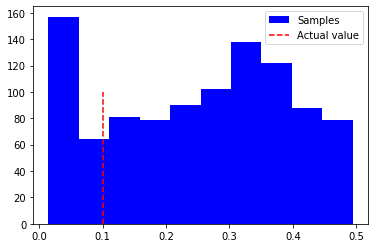

In [66]:

plt.hist(results[:, 0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=100, label="Actual value", color="red")
plt.legend()
plt.show()

# plt.hist(rest_res[:,0], color="blue", label="Samples")
# plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.legend()
# plt.show()

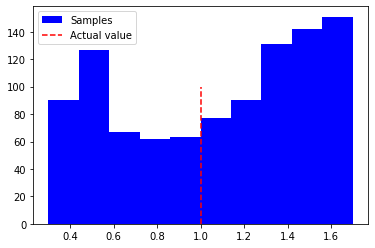

In [67]:
plt.hist(results[:, 1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=100, label="Actual value", color="red")
plt.legend()
plt.show()

In [69]:
samples_hamiltonian = results

# Visualizations

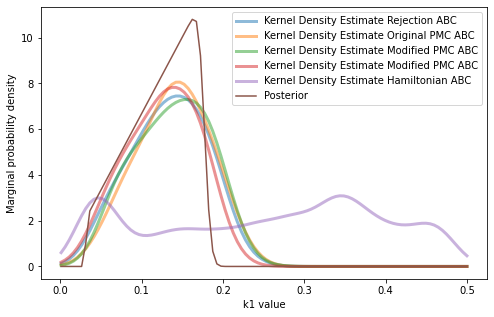

In [91]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.3, 1.7)[0]


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.5, 100)

vals = []
for x in x_grid:
    vals.append(marginal_distribution_x(x))

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))
ax.plot(x_grid, kde_sklearn(np.array(samples_rej_abc)[:, 0], x_grid, bandwidth=0.02),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.02),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.02),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive_pmc)[:, 0], x_grid, bandwidth=0.02),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 0], x_grid, bandwidth=0.02),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, vals, label='Posterior')
ax.legend()
plt.ylabel("Marginal probability density")
plt.xlabel("k1 value")
import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_kde_x.pdf')
# plt.show()

# plt.show()

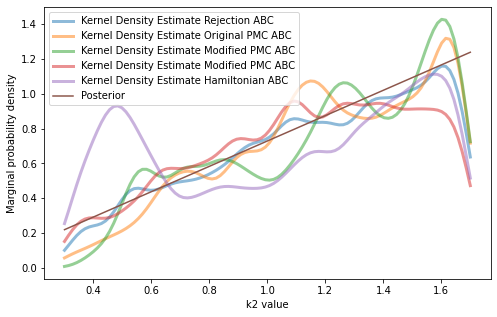

In [92]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.5)[0]

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.3, 1.7, 100)

vals = []
for x in x_grid:
    vals.append(marginal_distribution_y(x))

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))
ax.plot(x_grid, kde_sklearn(np.array(samples_rej_abc)[:, 1], x_grid, bandwidth=0.05),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=0.05),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=0.05),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive_pmc)[:, 1], x_grid, bandwidth=0.05),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 1], x_grid, bandwidth=0.05),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, vals, label='Posterior')
ax.legend()
plt.ylabel("Marginal probability density")
plt.xlabel("k2 value")

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_kde_y.pdf')
# plt.show()

# plt.show()

In [93]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.3, 1.7)[0]

def kl_func_x(y, kde_skl):
    part = marginal_distribution_x(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_x(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.025, 0.5)

# computing the KDE and KL functions for x
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.5)[0]

def kl_func_y(y, kde_skl):
    part = marginal_distribution_y(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 0.3, 1.7)

# print(marginal_distribution_y(0.3))
saved_x = kl_div_x(np.array(samples_hamiltonian)[:, 0], 0.02)[0]
saved_y = kl_div_y(np.array(samples_hamiltonian)[:, 1], 0.05)[0]
saved_ham = saved_x + saved_y 
saved_rej = kl_div_x(np.array(samples_rej_abc)[:, 0], 0.02)[0] + kl_div_y(np.array(samples_rej_abc)[:, 1], 0.05)[0]
saved_pmc_fake = kl_div_x(np.array(samples_pmc_fake)[:, 0], 0.02)[0] + kl_div_y(np.array(samples_pmc_fake)[:, 1], 0.05)[0]
saved_pmc_true = kl_div_x(np.array(samples_pmc_true)[:, 0], 0.02)[0] + kl_div_y(np.array(samples_pmc_true)[:, 1], 0.05)[0]
saved_adaptive = kl_div_x(np.array(samples_adaptive_pmc)[:, 0], 0.02)[0] + kl_div_y(np.array(samples_adaptive_pmc)[:, 1], 0.05)[0]


print("rejection kl = " + str(saved_rej))
print("modified pmc kl = " + str(saved_pmc_fake))
print("original pmc kl = " + str(saved_pmc_true))
print("adaptive pmc kl = " + str(saved_adaptive))
# both can be negative values????? 
print("hamiltonian kl = " + str(saved_ham))
print("s_x = "+str(saved_x) + ", s_y = "+str(saved_y))

rejection kl = 0.27073236468585876
modified pmc kl = 0.34231258414382476
original pmc kl = 0.3124436642809947
adaptive pmc kl = 0.22430780083697793
hamiltonian kl = 1.5905027231839735
s_x = 1.4685544359982112, s_y = 0.12194828718576221


In [135]:
print(samples_hamiltonian.tolist())

[[0.1516036496651253, 0.7645729060784477], [0.16287282504087433, 0.8027624328704848], [0.1446492225093211, 0.7209328642990187], [0.16045250663021676, 0.7497752713471988], [0.13806499559425853, 0.5719360467896721], [0.15567580343904447, 0.591407073324153], [0.20855957268748304, 0.6738149131242152], [0.2190713083453965, 0.6774224702862367], [0.2682341302971282, 0.7265698353956861], [0.2689825489328102, 0.7462788834019023], [0.34526333686394367, 0.7708572355875063], [0.33345968097645373, 0.7641624266909856], [0.37573263409611307, 0.7711061380631916], [0.35860366848130676, 0.7599050863159807], [0.35677800722325276, 0.7725444177605104], [0.3377014797460028, 0.7576615880448664], [0.3722138199023544, 0.7733306655155547], [0.3410608178157644, 0.7550017260624999], [0.40571912521025744, 0.7524949923798442], [0.3622849739516959, 0.7570534824876926], [0.4691523750891607, 0.6957370111039698], [0.41933695522757025, 0.6932377866076386], [0.37909708567136174, 0.6888383450906885], [0.3458873571731913, 